<h1 style="color:SteelBlue; font-size:200%"> Исследование объявлений о продаже квартир</h1>

Входные данные предоставлены сервисом "Яндекс.Недвижимость". Содержат архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно установить параметры, которые определяют рыночную стоимость недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<h1 style="color:SteelBlue"> 1. Импорт данных и изучение общей информации.</h1>

<h2 style="color:DodgerBlue">1.1 Импорт данных, первичная оценка</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set(style="whitegrid")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
flat_data = pd.read_csv("datasets/real_estate_data.csv", sep='\t')
pd.set_option('display.max_columns', None)
flat_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

In [3]:
flat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
def NaN_estimation_graph(df, figsize=(8,6)):
    NaN_percent = (100*df.isna().sum()/len(df)).sort_values()
    colors = (NaN_percent  / NaN_percent.max()).tolist()
    colors = [(color, 0.5*(1-color), 0.5*(1-color)) for color in colors] #подготовка градиентной окраски
    plt.figure(figsize=figsize)
    plt.grid(alpha=0.1)
    plt.xticks(range(0,110,10))
    plt.xlim(0,NaN_percent.max()+20)
    plt.xlabel('% пропущенных значений')
    plt.ylabel('признак')
    plt.hlines(y=NaN_percent.index, xmin = 0, xmax = NaN_percent, alpha=0.7, linewidth=10, colors=colors)
    for x, y, txt in zip(NaN_percent+1, NaN_percent.index, df.isna().sum().sort_values()):
        plt.text(x, y, f'{txt} шт.', verticalalignment='center')
    plt.title('Оценка количества и доли (%) пропусков в данных')
    plt.tight_layout(rect=(0, 0, 0.97, 0.97))
    plt.show()

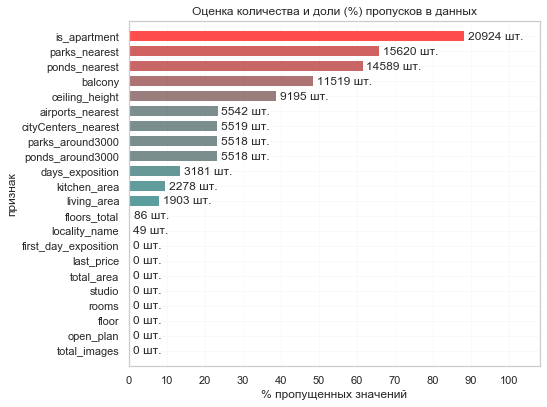

In [5]:
NaN_estimation_graph(flat_data)

Столбцы с числовыми данными имеют числовые типы, в этом смысле всё в порядке. Можно построить гистограммы и посмотреть, что из себя данные представляют, какие есть очевидные проблемы: выбросы, сомнительные данные и т.д.

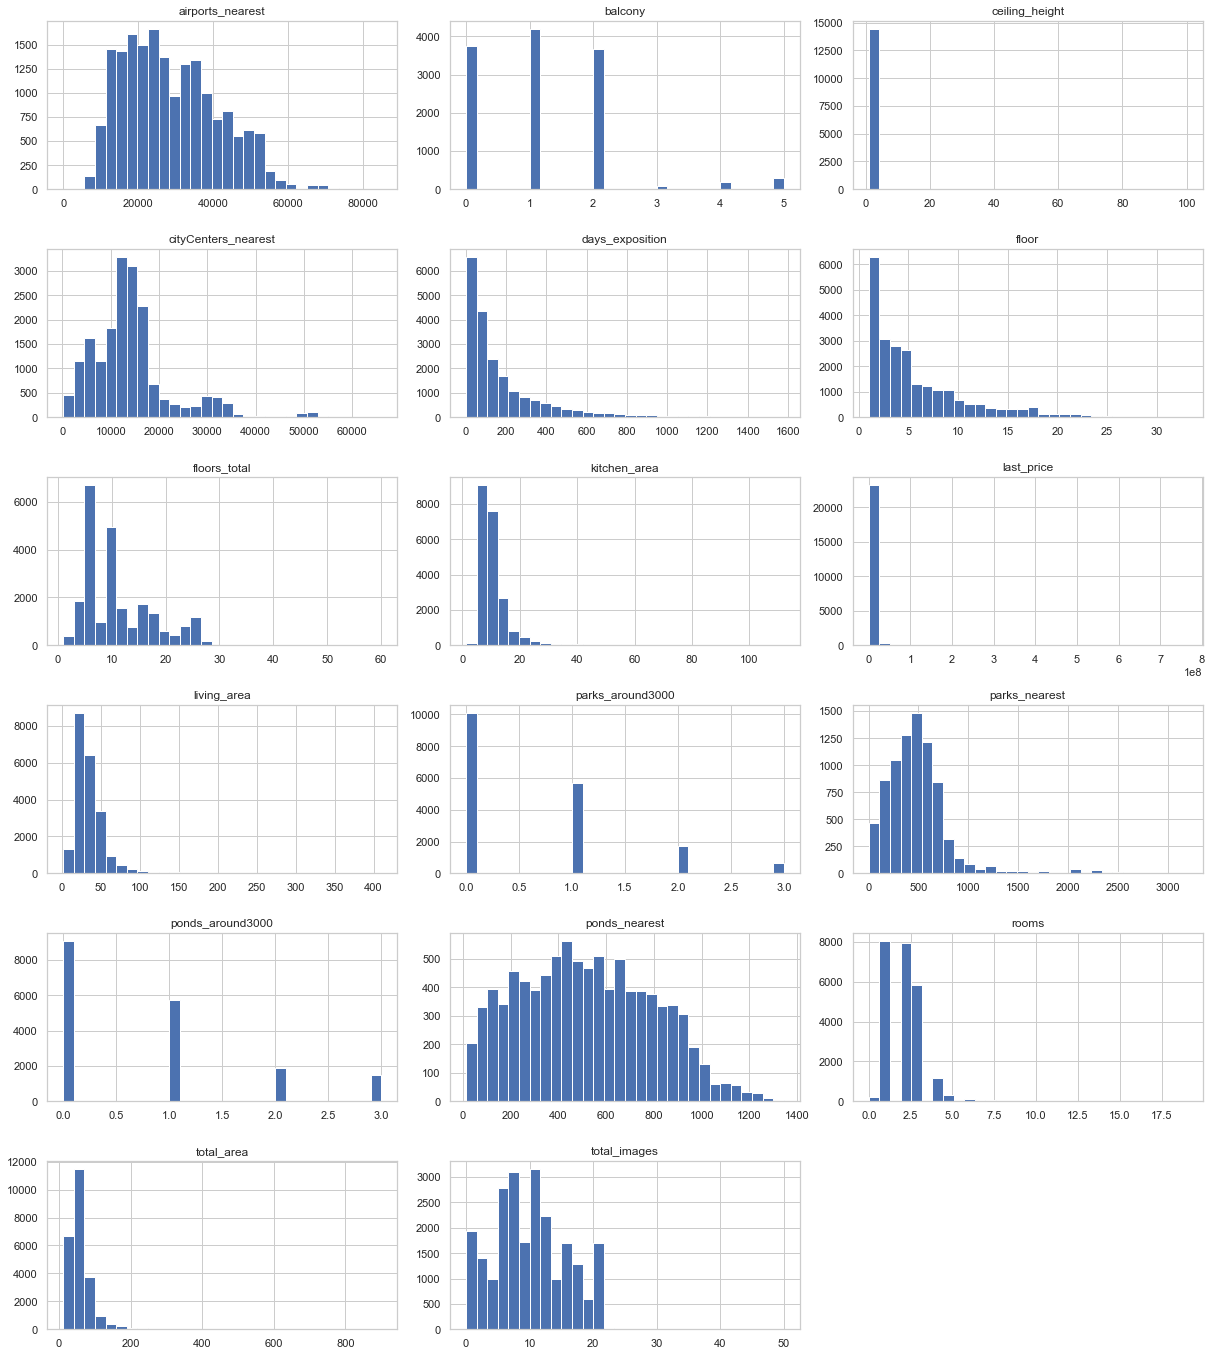

In [6]:
numeric_dtypes = ['float16', 'float32', 'float64', 'int8', 'int16', 'int32', 'int64']
#выделяю числовые столбцы и печатаю сетку гистограмм
flat_data.select_dtypes(include=numeric_dtypes).hist(figsize=(17, 20), bins = 30, layout=(6,3))
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

<h2 style="color:DodgerBlue">1.2 Результаты первичной оценки данных</h2>

Данные - pandas DataFrame, 22 столбца (параметра) и 23699 записей. Параметры представлены четырьмя типами данных: bool(2), float64(14), int64(3), object(3). 

Есть пропущенные значения. Некоторые параметры почти не представлены (например, в колонке is_apartment только 2775 non-null, т.е. для 88% записей нет данных по этому параметру). Надо разбираться.

Есть выбросы: ceiling_height, floors_total, kitchen_area, last_price, living area, living area, rooms, total area, total_images

Сомнительно выглядит график сроков продаж days_exposition: большой пик возле нуля

Стоимость недвижимости в рублях плохо читается. В части столбцов надо изменить типы данных (first_day_exposition надо привести к формату datetime, число этажей, ближайших парков, водоёмов и дней до продажи - в идеале к int (если получится убрать пропуски) и т.д.). Столбец населённых пунктов удобно разделить на типы и названия. Ряд значений (расстояние до аэропорта, центра города, цены) удобнее округлить и перевести в другие единицы. Требуется обработка.

- total_images — число фотографий квартиры в объявлении
- last_price — цена на момент снятия с публикации
- total_area — площадь квартиры в квадратных метрах (м²)
- first_day_exposition — дата публикации
- rooms — число комнат
- ceiling_height — высота потолков (м)
- floors_total — всего этажей в доме
- living_area — жилая площадь в квадратных метрах(м²)
- floor — этаж
- is_apartment — апартаменты (булев тип)
- studio — квартира-студия (булев тип)
- open_plan — свободная планировка (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- balcony — число балконов
- locality_name — название населённого пункта
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- cityCenters_nearest — расстояние до центра города (м)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

<h2 style="color:DodgerBlue">1.3 Предварительные гипотезы</h2>

Предварительно выдвенем ряд **гипотез**:


- **Гипотеза 1 - в зависимости от расположения объекта вклад некоторых параметров в рыночную стоимость будет различным. Но, например, площадь всегда будет связана со стоимостью: чем больше площадь, тем дороже**


- **Гипотеза 2 Стоимость зависит от (в порядке уменьшения значимости)**
    - типа населённого пункта (и отдельно - столица или нет)
    - расстояния до центра города
    - площади
    - типа (жилая/апартаменты)
    - этажа размещения (первый, последний либо промежуточные этажи) и, возможно, этажности дома
    - числа комнат 
    - высоты потолков
    - числа балконов


Важно, где ты живёшь, как далеко до центра города (где обычно работа, культурная жизнь и проч.), насколько большая жилплощадь, какая застройка (малоэтажный квартал или многоэтажка), на каком этаже (первый и последний обычно не самые лучшие - где-то холоднее, где-то нет балкона и меньше освещённость и т.д.), не "давит" ли потолок, есть ли возможность уединиться в отдельной комнате и есть ли балкон (или несколько; для home-office, надлюдения за небом или старых лыж)


- **Гипотеза 3 - стоимость объектов в центре столицы/крупных городов также зависит от: наличия поблизости парков и, возможно, водоёмов.** 


Для объектов "в центре столицы" расстояние до аэропорта не должно играть роли, т.к. аэропорты отдалены от центра. Парки и водоёмы поблизости от жилья в условиях центра крупного города, наверное, довольно важны. Есть, где погулять и подышать свежим воздухом.


- **Гипотеза 4 - объекты на окраине столицы и в прочих городах. Преимуществом будет отсутствие поблизости аэропортов. Парки и водоёмы тоже будут важны, но в меньшей степени.**


Когда рядом с жильём аэропорт - это, в основном, шум самолётов. И только пару раз в год возможность доехать до аэропорта на час быстрее остальных (например). Парки тоже важны, но в меньшей степени, т.к. обычно в спальных районах есть обширные скверы и внутренние дворики. Тем не менее, если это неудачный район или промзона - парк необходим.


- **Гипотеза 5 - объекты за городом. Преимущество - отсутствие аэропортов поблизости. Более важны будут водоёмы, нежели парки.**


С аэропортом - аналогично предыдущему. Парки за городом обычно есть априори, а вот с водоёмами не всегда так. Но всегда приятно иметь возможность пойти на реку или озеро.


**Общие замечания:**

Площадь, скорее всего, везде прямо связана со стоимостью, так что нужно будет вводить понятие **"цена квадратного метра"**, как характеристику вклада иных факторов.

Ряд параметров надо будет категоризовать. На первый взгляд таковыми кажутся: тип населённого пункта (город, посёлок и т.д.), столица - не столица, этаж (первый - последний - другой), этажность (малоэтажная застройка, среднеэтажная, высокоэтажная, индивидуальный дом), расстояние до центра города (близко, средняя удалённость, далеко). Нужно посмотреть, есть ли апартаменты за городом в принципе, или этот тип недвижимости характерен только для города и проч.

Не ясно сразу, например, влияет ли на стоимость жилья площадь кухни и отношение общей площади к жилой площади (чем оно больше тем, видимо, больше площадь санузла/кyxни/гapдepoбных/кладовок/балконов и проч). Как связано число балконов и площадь кухни с отношением общей площади к жилой. Связана ли площадь кухни с площадью квартиры. Возможно, какие-то параметры можно исключить из рассмотрения вообще.

Нужен критерий оценки корректности заявленной стоимости. Т.е. насколько долго провисело объявление, нет ли аномально быстрых снятий объявлений или аномально долгих размещений. Вероятно, более популярны объявления с достаточным количеством фото.

<h2 style="color:DodgerBlue"> 1.4 План действий:</h2>

- **Обработать дубликаты**
    - если возможно, сразу убрать явные дубли
    - проверить на скрытые дубли (обработать столбец названий населённых пунктов)
    

- **Обработать пропущенные значения, выполнить сопутствующую очистку данных**
    - подготовить таблицу для анализа пропусков (сделать очевидные преобразования и округления данных)
    - выявить критичные пропуски, некритичные удалить
    - критичные пропуски обработать: проанализировать причины появления, разобраться, какие данные можно сохранить или восстановить и как это сделать
    - на основе полученной информации удалить/заполнить/не трогать критичные пропуски
    - если при работе с пропусками видна необходимость очистки данных - очистить


- **Подготовить таблицу для анализа**
    - если остались неприведённые, то: привести типы данных к правильным, категоризовать данные
    - проверить, нужно ли досчитывать какие-то признаки в таблицу. Если нужно, то досчитать
    - убрать столбцы и строки, которые не нужны для анализа. упорядочить столбцы
    - удалить выбросы и экстремальные значения, если остались
    - оценить гистограммы данных и корректность обработки


- **Проверить связь рыночной стоимости с прочими параметрами, выделить основные.**


- **Сделать общий вывод**
***

<h1 style="color:SteelBlue">2. Предобработка данных</h1>

<h2 style="color:DodgerBlue"> 2.1 Обработка дубликатов </h2>

В данных много пропущенных значений и, чтобы их грамотно заполнить или удалить, желательно привести данные в порядок. При поиске вариантов заполнения будем использовать анализ распределений и т.д., а дубликаты могут внести искажения. Некоторые пропущенные значения можно попытаться восстановить по информации о месте расположения объекта недвижимости (например, расстояние до аэропорта). Но, если в этих объектах дубли, то ничего не получится. Так что удалим сперва дубликаты, явные и неявные.

Неявные дубликаты могут быть в названиях населённых пунктов. Вообще, имеет смысл отделить тип населённого пункта от названия, чтобы можно было отдельно посмотреть, например, на разницу цен на недвижимость в городских и сельских поселениях. 

План обработки дубликатов:

1. проверить на явные дубли и удалить, если есть
2. проверить на скрытые дубли:
    - проверить дублирование по регистру, если нужно - привести к общему регистру
    - проверить на дублирование по е - ё, при необходимости заменить ё на е
    - проверить на правильность типа населённого пункта (нет ли деревень, названных сёлами или посёлками и т.д.)
    - удалить скрытые дубли

### 2.1.1 Полные дубли

Полных дублей в данных нет:

In [7]:
flat_data.duplicated().sum()

0

### 2.1.2 Неявные дубликаты

Неявные дубликаты могут быть в названиях населённых пунктов. Из-за разного регистра или, например, "е" и "ё". 

Посмотрим, есть ли смысл приводить все названия к одному регистру:

In [8]:
len(flat_data.loc[:, "locality_name"].unique())

365

In [9]:
len(flat_data.loc[:, "locality_name"].str.upper().unique())

365

Нет смысла. А текущее представление выглядит неплохо, удобно читать. 

Посмотрим визуально, какие могут быть ещё проблемы (выведем первые 50 объектов):

In [10]:
flat_data.loc[:, "locality_name"].unique()[:50]

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Сразу видно "поселок" и "посёлок". Заменим везде "ё" на "е".

In [11]:
flat_data.loc[:, "locality_name"] = flat_data.loc[:, "locality_name"].str.replace('ё','е')
len(flat_data.loc[:, "locality_name"].unique())

331

Убрали 34 скрытых дубликата.

Хорошо бы отделить название населённого пункта от его типа, так всё станет прозрачнее. Возможно, получится найти скрытые дубликаты, когда деревня названа, например, селом.

Соберём все названия населённых пунктов в список <code>ndarray:</code>

In [12]:
#получаю series уникальных названий населённых пунктов (без NaN)
#по нему вручную собираю типы населённых пунктов 
#основные и так понятны: село, деревня, поселок, поселок годского типа. быстро просматриваю на неочевидные
locality_names_list = flat_data.loc[~flat_data.loc[:, "locality_name"].isna(), "locality_name"].unique()
locality_names_list

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

Из списка выделим список типов населённых пунктов. Затем в цикле проверим вхождения типов в названия, пользуясь тем, что строка - это список символов. Чтобы не усложнять цикл, первыми в списке типов поставим те, в которые входят последующие (напр., "поселок городского типа" перед "поселок", "поселок" перед "село"). Типов немного, можно всё сделать вручную. 

Результатом цикла будет словарь. Его ключи - названия населённых пунктов в оригинальном виде. Данные - разделённые название населённого пункта и его тип.

In [13]:
#ВАЖНО. В types_list первыми должны идти названия типов, в которые входят более короткие
#Например, "городской поселок" перед "поселок". Или "поселок" перед "село"
#В цикле сорировки не будет, нет задачи унификации   
locality_types_list = ["садоводческое некоммерческое товарищество",
                      "поселок городского типа",
                      "городской поселок",
                      "коттеджный поселок",
                      "садовое товарищество",
                      "поселок",
                      "деревня", 
                      "село"
                      ]

In [14]:
def name_type_split(df, locality_types_list, locality_names_list):
    #объявляю словарь названий и типов населённых пунктов (понадобится для замены)
    locality_dict = {}
    
    #цикл извлечения из уникального названия населённого пункта собственно названия и типа
    #добавление их в словарь
    for locality_name in locality_names_list:
        city_flag = True #маркер "если город" (для городов тип населённого пункта не указан)
        for locality_type in locality_types_list:
            if locality_type in locality_name:
                city_flag = False
                locality_dict[locality_name] = [locality_name[len(locality_type)+1:], locality_type] 
                locality_name = locality_name[len(locality_type)+1:]
        
        #если тип населённого пункта не указан (только название, например, "Санкт-Петербург")
        #назначаю тип "город". Это соответствует тому, что я вижу в данных
        if city_flag:
            locality_dict[locality_name] = [locality_name, "город"]
    return locality_dict

In [15]:
#проверю, что получается
#чтобы не забивать вывод, делаю list из пар (ключ, значение), полученных методом dict.items(), вывожу первые 10 пар
list(name_type_split(flat_data, locality_types_list, locality_names_list).items())[0:10]

[('Санкт-Петербург', ['Санкт-Петербург', 'город']),
 ('поселок Шушары', ['Шушары', 'поселок']),
 ('городской поселок Янино-1', ['Янино-1', 'городской поселок']),
 ('поселок Парголово', ['Парголово', 'поселок']),
 ('поселок Мурино', ['Мурино', 'поселок']),
 ('Ломоносов', ['Ломоносов', 'город']),
 ('Сертолово', ['Сертолово', 'город']),
 ('Петергоф', ['Петергоф', 'город']),
 ('Пушкин', ['Пушкин', 'город']),
 ('деревня Кудрово', ['Кудрово', 'деревня'])]

В DataFrame создадим 2 новых столбца, один - с названием населённого пункта, другой - с типом. Для этого удобно использовать 2 словаря.

In [16]:
locality_dict = name_type_split(flat_data, locality_types_list, locality_names_list)
locality_names_dict = {}
locality_types_dict = {}

for locality in locality_dict:
    locality_names_dict[locality] = locality_dict[locality][0]
    locality_types_dict[locality] = locality_dict[locality][1]

Получили 2 словаря python. Один содержит соответствие вида <code>"locality_name": "название населённого пункта"</code>.
Другой - <code>"locality_name": "тип населённого пункта"</code>
Создадим в DataFrame 2 новых столбца, в одном будет только название, а в другом - только тип. Воспользуемся заменой по словарю. Это быстро, т.к. выполняется встроенными методами пандас.

In [17]:
flat_data.loc[:, "locality_name_new"] = flat_data.loc[:, "locality_name"].replace(locality_names_dict)
flat_data.loc[:, "locality_type_new"] = flat_data.loc[:, "locality_name"].replace(locality_types_dict)

In [18]:
flat_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   поселок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition locality_name_new locality_type_new  
0          755.0              NaN   Санкт-Петербург             город  
1            NaN             81.0            Шушары           поселок  
2          574.0            558.0   Санкт-Петербург             город  
3          234.0            424.0   Санкт-Петербург             город  
4           48.0            121.0   Санкт-Петербург             город

Теперь посмотрим, что с уникальными населёнными пунктами:

In [19]:
flat_data.loc[:, "locality_name_new"].unique().size

309

На 22 меньше, чем было. Либо повторяются названия у разных населённых пунктов, либо где-то дубликаты. Проверим. Для этого выведем названия и соответствующие ему типы населённых пунктов для тех названий, которым соответствуют более 1 типа.

In [20]:
def dupl_types_check(df):
    series_duplicates = df.groupby("locality_name_new")["locality_type_new"].unique()
    list_duplicates=[]
    dupl_types_dict={}
    for i in range(0, len(series_duplicates)):
        if len(series_duplicates[i]) > 1:
            #list_duplicates.append(series_duplicates.index[i])
            dupl_types_dict[series_duplicates.index[i]] = series_duplicates[i].tolist()
    return dupl_types_dict

In [21]:
dupl_types_check(flat_data)

{'Большая Ижора': ['городской поселок', 'поселок городского типа'],
 'Гарболово': ['деревня', 'поселок'],
 'Зимитицы': ['поселок', 'деревня'],
 'Калитино': ['деревня', 'поселок'],
 'Кудрово': ['деревня', 'город'],
 'Лесное': ['поселок', 'коттеджный поселок'],
 'Лесогорский': ['городской поселок', 'поселок городского типа'],
 'Любань': ['город', 'поселок'],
 'Мга': ['городской поселок', 'поселок городского типа'],
 'Мурино': ['поселок', 'город'],
 'Назия': ['городской поселок', 'поселок городского типа'],
 'Никольское': ['город', 'село'],
 'Павлово': ['село', 'городской поселок', 'поселок городского типа'],
 'Приладожский': ['поселок городского типа', 'садовое товарищество'],
 'Рабитицы': ['деревня', 'поселок'],
 'Рахья': ['поселок городского типа', 'садовое товарищество'],
 'Рощино': ['поселок городского типа', 'городской поселок'],
 'Рябово': ['поселок', 'поселок городского типа'],
 'Советский': ['поселок городского типа', 'городской поселок'],
 'Федоровское': ['деревня', 'городской п

Теперь, когда получена вся информация, попробуем навести порядок.
Начнём с того, что, [согласно областному закону Ленинградской области](http://docs.cntd.ru/document/891832035 "закон Об административно-территориальном устройстве Ленинградской области и порядке его изменения (с изменениями на 6 апреля 2020 года)") городской поселок и посёлок городского типа определены одинаково. Т.е. это одно и то же. 

Чтобы не было путаницы в данных, заменим все вхождения "городской поселок" на "поселок городского типа" и повторим проверку.

В том же законе определены: деревня, село, поселок, поселок городского типа и город. Кроме того, городскими поселками (поселками городского типа) являются населенные пункты, отнесенные к категории рабочих, курортных или дачных поселков.

In [22]:
flat_data.loc[flat_data.loc[:, "locality_type_new"] == "городской поселок", "locality_type_new"] = "поселок городского типа"

In [23]:
dupl_types_check(flat_data)

{'Гарболово': ['деревня', 'поселок'],
 'Зимитицы': ['поселок', 'деревня'],
 'Калитино': ['деревня', 'поселок'],
 'Кудрово': ['деревня', 'город'],
 'Лесное': ['поселок', 'коттеджный поселок'],
 'Любань': ['город', 'поселок'],
 'Мурино': ['поселок', 'город'],
 'Никольское': ['город', 'село'],
 'Павлово': ['село', 'поселок городского типа'],
 'Приладожский': ['поселок городского типа', 'садовое товарищество'],
 'Рабитицы': ['деревня', 'поселок'],
 'Рахья': ['поселок городского типа', 'садовое товарищество'],
 'Рябово': ['поселок', 'поселок городского типа'],
 'Федоровское': ['деревня', 'поселок городского типа'],
 'Щеглово': ['поселок', 'деревня']}

После объединения городских поселков с поселками городского типа осталось ещё несколько админимстративно-территориальных единиц с одинаковыми названиями и разными типами. Проверим по [официальным данным об административно-территориальном устройстве](https://lenobl.ru/o-regione/administrativno-territorialnoe-ustrojstvo/naselennye-punkty/ "Населённые пункты - Правительство Ленинградской области") и Яндекс.Картам
- **Гарболово:** есть только деревня. <font style="color:FireBrick">**Ошибка в данных.**</font>
- **Зимитицы:** есть и деревня, и поселок
- **Калитино:** есть и деревня, и поселок
- **Кудрово:** город. Это внутри КАД. <font style="color:FireBrick">**Ошибка в данных.**</font>
- **Лесное:** по официальным данным есть только посёлок. По Яндекс.Картам есть и коттеджный посёлок Лесное: Россия, Ленинградская область, Ломоносовский район, Ропшинское сельское поселение, деревня Малые Горки.
- **Любань:** есть и город и посёлок. Территориально одно и то же место.
- **Мурино:** город. Посёлок Мурино - прежнее название. <font style="color:FireBrick">**Ошибка в данных.**</font>
- **Никольское**: есть и город, и село, и даже несколько деревень с таким названием
- **Павлово**: Есть и поселок городского типа (городской поселок) и село, и даже деревня
- **Приладожский**: поселок городского типа (городской поселок). Садовое товарищество найти не удалось. Зато есть СНТ "Приладожское" в этом поселке. Проверим, что это за объект.

In [24]:
flat_data.loc[flat_data.loc[:, "locality_name_new"] == "Приладожский", :]

total_images  last_price  total_area first_day_exposition  rooms  \
2288              6   2400000.0        60.0  2016-11-10T00:00:00      2   
5082             10   2299000.0        44.0  2018-11-06T00:00:00      2   
8020             14   1990000.0        43.1  2018-08-28T00:00:00      2   
8065             13   2600000.0        60.7  2018-11-25T00:00:00      3   
11550             3   1650000.0        45.0  2017-05-16T00:00:00      2   
14611             6   1950000.0        44.4  2017-11-01T00:00:00      2   
19635            11   2650000.0        60.0  2016-06-05T00:00:00      3   
19704            10   2200000.0        61.0  2018-03-06T00:00:00      3   
23237             8   2100000.0        47.0  2019-01-26T00:00:00      2   
23423             8   2450000.0        48.0  2017-08-29T00:00:00      2   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
2288             2.56          12.0         35.0      1          NaN   False   
5082             2.60           5.0         28.0      5          NaN   False   
8020             2.50           9.0         27.7      9          NaN   False   
8065             2.50           9.0         44.0      3          NaN   False   
11550            2.56           9.0         27.0      9        False   False   
14611            2.70           9.0         26.7      1          NaN   False   
19635             NaN           9.0         44.0      8          NaN   False   
19704            2.50           9.0         43.0      5          NaN   False   
23237             NaN          12.0         27.5     12          NaN   False   
23423            2.75           5.0          NaN      5          NaN   False   

       open_plan  kitchen_area  balcony                         locality_name  \
2288       False           9.7      0.0  поселок городского типа Приладожский   
5082       False           7.0      NaN  поселок городского типа Приладожский   
8020       False           6.0      NaN  поселок городского типа Приладожский   
8065       False           5.5      NaN  поселок городского типа Приладожский   
11550      False           7.0      2.0  поселок городского типа Приладожский   
14611      False           6.0      2.0  поселок городского типа Приладожский   
19635      False           7.0      0.0     садовое товарищество Приладожский   
19704      False           6.0      NaN  поселок городского типа Приладожский   
23237      False           7.2      1.0  поселок городского типа Приладожский   
23423      False           9.0      1.0  поселок городского типа Приладожский   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
2288                NaN                  NaN               NaN            NaN   
5082                NaN                  NaN               NaN            NaN   
8020                NaN                  NaN               NaN            NaN   
8065                NaN                  NaN               NaN            NaN   
11550               NaN                  NaN               NaN            NaN   
14611               NaN                  NaN               NaN            NaN   
19635               NaN                  NaN               NaN            NaN   
19704               NaN                  NaN               NaN            NaN   
23237               NaN                  NaN               NaN            NaN   
23423               NaN                  NaN               NaN            NaN   

       ponds_around3000  ponds_nearest  days_exposition locality_name_new  \
2288                NaN            NaN            363.0      Приладожский   
5082                NaN            NaN             77.0      Приладожский   
8020                NaN            NaN             45.0      Приладожский   
8065                NaN            NaN              NaN      Приладожский   
11550               NaN            NaN             82.0      Приладожский   
14611               NaN            NaN              Na

8й этаж 9ти этажного дома в садовом товариществе сомнителен. Кроме того, СНТ "Приладожское" пимыкает к посёлку, а СНТ "Приладожский" поиском не пробивается (точнее, пробивается как СНТ "Приладожское"). По параметрам запись походит на аналогичные для ПГТ "Приладожский". С учётом данных фактов заменим садовое товарищество Приладожский на поселок городского типа Приладожский. Тем более, такая запись только 1.

In [25]:
flat_data.loc[flat_data.loc[:, "locality_name_new"] == "Приладожский", "locality_type_new"] = 'поселок городского типа'

Продолжаем с "дублями":
- **Рабитицы**: есть и деревня и посёлок. Находятся рядом
- **Рахья**: есть и городской посёлок и садовое товарищество. Находятся рядом
- **Рябово** есть и посёлок, и посёлок городского типа.
- **Федоровское** есть только городской посёлок Фёдоровское, такой деревни нет. <font style="color:FireBrick">**Ошибка в данных.**</font>
- **Щеглово** есть и посёлок, и деревня

Исправим данные и посмотрим, как распределились записи по группам:

In [26]:
def replace_data_by_key(df, data_dict, column_to_search = "", column_to_replace = ""):
#df - dataframe
#data_dict - словарь
#данные data_dict - значения в столбце data_column, 
#для которых надо заменить соответствующие значения в столбце key_column
#ключи - то, НА ЧТО надо заменить значения в столбце key_column

#например "город": ["Кудрово", "Мурино"] (key - "город", data_dict[key] - ["Кудрово", "Мурино"])
#если для строки значение из data_column совпадает с "Кудрово" или "Мурино"
#то заменяем значение в key_column на "город"

    for key in data_dict:
        df.loc[df.loc[:, column_to_search].isin(data_dict[key]), column_to_replace] = key   

In [27]:
changes_dict = {"деревня": ["Гарболово"],
                "город": ["Кудрово", "Мурино"],
                "поселок городского типа": ["Федоровское"]}
replace_data_by_key(flat_data, 
                    changes_dict, 
                    column_to_search="locality_name_new", 
                    column_to_replace="locality_type_new")
changes_dict = {} #обнуляю словарь во избежание ошибок

In [28]:
dupl_types_check(flat_data)

{'Зимитицы': ['поселок', 'деревня'],
 'Калитино': ['деревня', 'поселок'],
 'Лесное': ['поселок', 'коттеджный поселок'],
 'Любань': ['город', 'поселок'],
 'Никольское': ['город', 'село'],
 'Павлово': ['село', 'поселок городского типа'],
 'Рабитицы': ['деревня', 'поселок'],
 'Рахья': ['поселок городского типа', 'садовое товарищество'],
 'Рябово': ['поселок', 'поселок городского типа'],
 'Щеглово': ['поселок', 'деревня']}

Исправлено, ОК.

In [29]:
flat_data.groupby("locality_type_new")["total_area"].count()

locality_type_new
город                                        20863
деревня                                        642
коттеджный поселок                               3
поселок                                       1547
поселок городского типа                        559
садоводческое некоммерческое товарищество        1
садовое товарищество                             3
село                                            32
Name: total_area, dtype: int64

Есть садоводческое некоммерческое товарищество и садовое товарищество, которые точно можно объединить, и ещё - коттеджный поселок. [Согласно областному закону Ленинградской области](http://docs.cntd.ru/document/891832035 "закон Об административно-территориальном устройстве Ленинградской области и порядке его изменения (с изменениями на 6 апреля 2020 года)"), статья 5, К городским населенным пунктам относятся города и городские поселки. Городскими поселками (поселками городского типа) являются населенные пункты, отнесенные к категории рабочих, курортных или дачных поселков. Т.е. можно эти 3 маленькие категории включить в посёлки городского типа. Так и поступим.

In [30]:
changes_dict = {"поселок городского типа": ["коттеджный поселок", 
                                            "садовое товарищество", 
                                            "садоводческое некоммерческое товарищество"],
                }
replace_data_by_key(flat_data, 
                    changes_dict, 
                    column_to_search="locality_type_new", 
                    column_to_replace="locality_type_new")
changes_dict = {}#обнуляю словарь во избежание ошибок

Повторно проверим категории населённых рунктов и вхождения в них:

In [31]:
flat_data.groupby("locality_type_new")["total_area"].count()

locality_type_new
город                      20863
деревня                      642
поселок                     1547
поселок городского типа      566
село                          32
Name: total_area, dtype: int64

В таблицу добавим столбец, содержащий полное исправленное название населённого пункта. Назовём его "locality_fullname_new"

In [32]:
flat_data.loc[:, "locality_fullname_new"] = (
    flat_data.loc[:, "locality_type_new"] + ' ' + flat_data.loc[:, "locality_name_new"]
)

In [33]:
flat_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   поселок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition locality_name_new locality_type_new  \
0          755.0              NaN   Санкт-Петербург             город   
1            NaN             81.0            Шушары           поселок   
2          574.0            558.0   Санкт-Петербург             город   
3          234.0            424.0   Санкт-Петербург             город   
4           48.0            121.0   Санкт-Петербург             город   

   locality_fullname_new  
0  город Санкт-Петербург  
1         поселок Шушары  
2  город Санкт-Петербург  
3  город Санкт-Петербург  
4  город Санкт-Петербург

Всё хорошо и даже соответствует областному закону Ленинградской области.
Теперь, исключив из рассмотрения колонку locality_name, которую как раз исправляли, проверим на дубли ещё раз.

In [34]:
del flat_data["locality_name"]

In [35]:
flat_data.duplicated().sum()

0

<h2 style="color:DodgerBlue"> Вывод по обработке дубликатов:</h2>

***
Отлично, полных дублей нет, скрытые дубли обработаны (были ошибки в данных и повторяющиеся названия с "е" и "ё", 34 скрытых дубля), населённые пункты отнесены к нужным типам (исправлено несколько ошибок, когда один и то же населённый пункт был отнесён к разным типам: 4 населённых пункта). В отдельные столбцы вынесены названия и типы населённых пунктов: <code>locality_name_new, locality_type_new.</code> Добавлен столбец <code>locality_fullname_new</code> - скорректированное полное название (взамен <code><strike>locality_name</strike></code>). Типы населённых пунктов теперь согласуются с законодательством Ленинградской области.

Обнаруженные дубли и ошибки, скорее всего, связаны с отсутствием или нарушением стандарта ввода (е и ё), а также - с путаницей в типах населённых пунктов (возможно - ошибки в базе населённых пунктов)
***

<h2 style="color:DodgerBlue"> 2.2 Обработка пропущенных значений и предварительная очистка данных</h2>

### 2.2.1 Подготовка и дополнение таблицы для визуального анализа

### Цена квадратного метра, округление цен до тысяч рублей и дата-время

Работа с пропусками потребует анализа данных. Т.к. важнейший параметр, стоимость квадратного метра, отсутствует, сразу его добавим. Будем считать по общей площади и метражу, т.к. для этих параметров нет пропусков. Далее, если понадобится стоимость квадратного метра жилой площади, её можно будет получить из отношения нежилой площади к жилой.

In [36]:
flat_data.loc[:, "price_per_square_meter"] = flat_data.loc[:, "last_price"] / flat_data.loc[:, "total_area"]

Цены со множеством нулей визуально сложно анализировать, сразу округлим до тысяч рублей и приведем к целочисленному типу столбцы <code>last_price</code> и <code>price_per_square_meter</code>.

In [37]:
flat_data.loc[:, "price_per_square_meter"] = (flat_data.loc[:, "price_per_square_meter"] / 1000).round(0).astype(int)
flat_data.loc[:, "last_price"] = (flat_data.loc[:, "last_price"] / 1000).round(0).astype(int)

Приведём столбец с датой и временем к формату datetime, используем <code>pd.to_datetime</code>. Часы, минуты и секунды, похоже, для всех записей равны 0, выполним смену типа и проверим

In [38]:
flat_data.loc[:, "first_day_exposition"] = pd.to_datetime(flat_data.loc[:, "first_day_exposition"], 
              format="%Y-%m-%dT%H:%M:%S")

In [39]:
flat_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000       108.0           2019-03-07      3   
1             7        3350        40.4           2018-12-04      1   
2            10        5196        56.0           2015-08-20      2   
3             0       64900       159.0           2015-07-24      3   
4             2       10000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
0      False          25.0      NaN           18863.0              16028.0   
1      False          11.0      2.0           12817.0              18603.0   
2      False           8.3      0.0           21741.0              13933.0   
3      False           NaN      0.0           28098.0               6800.0   
4      False          41.0      NaN           31856.0               8098.0   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0               1.0          482.0               2.0          755.0   
1               0.0            NaN               0.0            NaN   
2               1.0           90.0               2.0          574.0   
3               2.0           84.0               3.0          234.0   
4               2.0          112.0               1.0           48.0   

   days_exposition locality_name_new locality_type_new  locality_fullname_new  \
0              NaN   Санкт-Петербург             город  город Санкт-Петербург   
1             81.0            Шушары           поселок         поселок Шушары   
2            558.0   Санкт-Петербург             город  город Санкт-Петербург   
3            424.0   Санкт-Петербург             город  город Санкт-Петербург   
4            121.0   Санкт-Петербург             город  город Санкт-Петербург   

   price_per_square_meter  
0                     120  
1                      83  
2                      93  
3                     408  
4                     100

Визуально стало сущёственно лучше.

### 2.2.2 Общая информация по пропускам

В данных много пропусков. Упорядочим по уменьшению числа пропущенных значений, посмотрим на общую картину:

In [40]:
flat_data[~flat_data.isna()].count().sort_values()

is_apartment               2775
parks_nearest              8079
ponds_nearest              9110
balcony                   12180
ceiling_height            14504
airports_nearest          18157
cityCenters_nearest       18180
ponds_around3000          18181
parks_around3000          18181
days_exposition           20518
kitchen_area              21421
living_area               21796
floors_total              23613
locality_type_new         23650
locality_name_new         23650
locality_fullname_new     23650
total_images              23699
studio                    23699
floor                     23699
rooms                     23699
first_day_exposition      23699
total_area                23699
last_price                23699
open_plan                 23699
price_per_square_meter    23699
dtype: int64

В небольшом числе записей нет важной информации: 49 объектов без расположения, 86 - без данных об этажности дома. Расположение - один из важнейших параметров. Этажность позволяет отделить первый, последний и промежуточный этаж. Записей с пропусками немного, удалим.

In [41]:
flat_data.dropna(subset=['floors_total', 'locality_fullname_new'], inplace=True)

### 2.2.3 Слишком быстрые и слишком медленные продажи

У более чем 3000 записей пропуски в данных о продолжительности размещения объявления. Важный показатель, по которому можно оценить качество данных. Если объявление "висело" пару дней или несколько лет - это странно, данные из этого объявления вызывают недоверие.

In [42]:
flat_data.loc[~flat_data.loc[:, "days_exposition"].isna(), "days_exposition"].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Есть проблемы. Четверть всех объявлений снимают уже через месяц. Минимальное время размещения - 1 день. Крайне сомнительно, что можно продать квартиру за день, даже демпингуя цену. Максимальное время размещения - более 4х лет. Тоже странно, разве что продаётся что-то особое. Медиана почти в 2 раза меньше среднего. Посмотрим на гистограмму распределения числа продаж квартир в зависимости от длительности размещения объявления. Ожидаемое распределение - асимметричное распределение с "тяжёлым хвостом", типа хи-квадрат. С малым числом значений в районе нуля, последующим плавным и быстрым ростом, плавным пиком (с характером "колокола") и медленным спадом. 

In [43]:
#объявлю функцию построения графиков для среза данных по значениям "days_exposition"

def hists_full_slice_plot(hist_data, lower_limit, upper_limit, bins1 = 50, bins2 = 50, hist_title = ''): 
    
    #объём и среднее оригинальной серии данных
    mean_orig = hist_data.mean()
    count_orig = hist_data.count()
    
    #срез серии:
    hist_data_slice = hist_data[(hist_data >= lower_limit) & (hist_data <= upper_limit)]
    mean_slice = hist_data_slice.mean()
    count_slice = hist_data_slice.count()
    
    #Хочу сделать 2 графика в 1 ряд. Для этого:
    #объявляю объект Figure
    plt.figure(figsize=(14,5))
    
    #объявляю Axes, сообщаю ему, что в рамках Figure 1 ряд, 2 столбца и он - 1й (левый)
    plt.subplot(1, 2, 1)  
    
    #создаю гистограмму в этом Axes
    plt.hist(hist_data, bins=bins1)
    #назначаю подписи осей, заголовок и сетку
    plt.title(f"Весь диапазон\n среднее: {mean_orig:.1f}, объём выборки: {count_orig}\n")
    plt.grid(True)
    
    #объявляю Axes, сообщаю ему, что в рамках Figure 1 ряд, 2 столбца и он - 2й (правый)
    plt.subplot(1, 2, 2)
    
    #создаю гистограмму в этом Axes для сроков продажи от lower_limit до upper_limit
    plt.hist(hist_data, bins=bins2, range=(lower_limit, upper_limit))
    
    #назначаю подписи осей, заголовок и сетку
    plt.title(f"Срез: от {lower_limit} до {upper_limit}\n среднее: {mean_slice:.1f}, объём выборки: {count_slice}\n")
    plt.grid(True)
    if hist_title != '':
        plt.suptitle(hist_title)
    
    #чтобы названия графиков не наезжали друг на друга, применяю plt.tight_layout
    plt.tight_layout(rect=(0, 0, 0.95, 0.95))    
    plt.show()

In [44]:
#собираю Series c данными по "days_exposition" без NaN для гистограмм
days_exposition_all_NOTnan = flat_data.loc[~flat_data.loc[:, "days_exposition"].isna(), "days_exposition"]

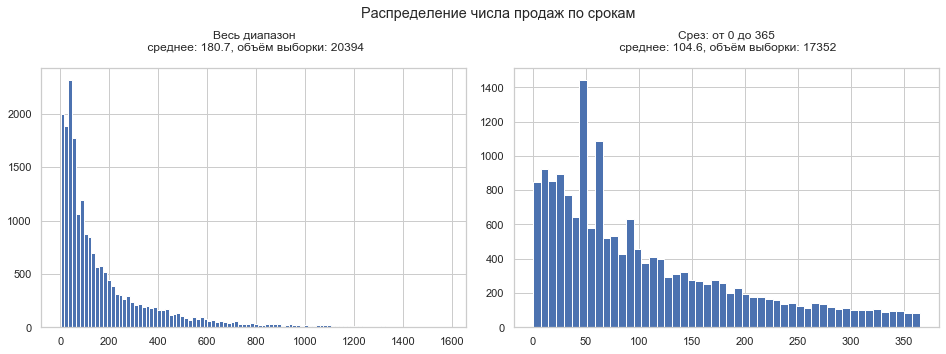

In [45]:
hists_full_slice_plot(days_exposition_all_NOTnan, 
                      0, 365, bins1=100, bins2=50, hist_title = "Распределение числа продаж по срокам")

Большие отличия от ожидаемого. Возле 0 никакого спада. Очевидно, что данные нужно очищать. Оценим, для какого года характерны пропуски. **Сразу досчитаем столбец года в датафрейм, назовём** <code>'start_year'</code>

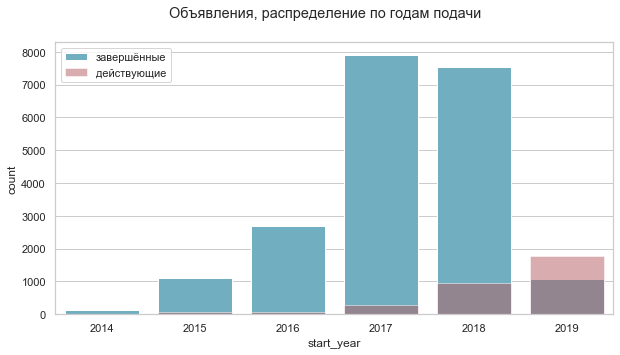

In [46]:
#добавление столбца с годом
flat_data['start_year'] = flat_data['first_day_exposition'].dt.year

#series с годом подачи объявлений с пропусками в days_exposition
year_days_exposition_nan = flat_data.loc[flat_data.loc[:,'days_exposition'].isna(), 'start_year']

#series с годом подачи объявлений БЕЗ пропусков в days_exposition
year_days_exposition_NOTnan = flat_data.loc[~flat_data.loc[:,'days_exposition'].isna(), 'start_year']

#печатаю гистограмму в фигуре, в одном Axes 2 графика
plt.figure(figsize=(10,5))
#использую сиборн
sns.countplot(x=year_days_exposition_NOTnan, label='завершённые', color='c')
sns.countplot(x=year_days_exposition_nan, label='действующие', color='r', alpha=0.5)
plt.suptitle('Объявления, распределение по годам подачи')
plt.legend()
plt.show()

Почти 2/3 данных отсутствуют для 2019 года. В 2018 - около 13%. Очень не хотелось бы терять столько информации. Посмотрим, какое в 2019 году распределение звершённых и действующих объявлений по месяцам. **Сразу досчитаем столбец с месяцем подачи объявления в датафрейм.** Назовём <code>'start_month'</code>

In [47]:
#создаю столбец с месяцем подачи объявления
flat_data['start_month'] = flat_data['first_day_exposition'].dt.month

In [48]:
#для оценки распределения по месяцам 2019г создаю 2 серии (по ним построю графики):

#1. серия куда кладётся месяц из 'start_month', если в данной записи в столбце "days_exposition" пропуск
month2019_days_exposition_nan = flat_data.loc[
    flat_data.loc[:,'days_exposition'].isna() & (flat_data.loc[:, 'start_year'] == 2019), 'start_month']

#2. серия куда кладётся месяц из 'start_month', если в данной записи в столбце "days_exposition" пропуска нет
month2019_days_exposition_NOTnan = flat_data.loc[
    ~flat_data.loc[:,'days_exposition'].isna() & (flat_data.loc[:, 'start_year'] == 2019), 'start_month']

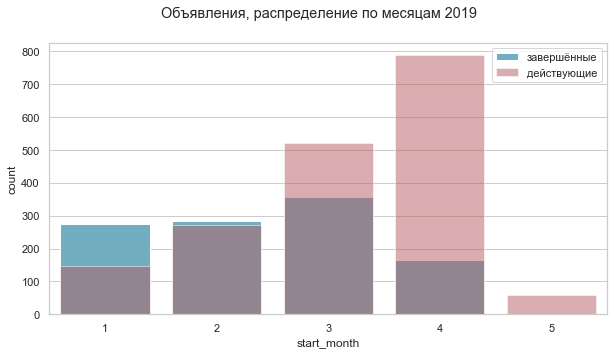

In [49]:
plt.figure(figsize=(10,5))
sns.countplot(x=month2019_days_exposition_NOTnan, label='завершённые', color='c')
sns.countplot(x=month2019_days_exposition_nan, label='действующие', color='r', alpha=0.5)
plt.suptitle('Объявления, распределение по месяцам 2019')
plt.legend()
plt.show()

В 2019 с 5 месяца нет данных. Похоже, 5 месяц - месяц, когда была выгружена база данных для анализа (можно трактовать как ***прекращение наблюдений за выборкой***).  <font style="Color:FireBrick">**За 2019 почти 2/3 объявлений не завершены. Видимо, не успели до выгрузки базы. При дальнейших оценках продаж за 2019 нужно учитывать, что по этому году данные по продажам не полные!**</font> Но нам необходимы данные о сроках, нужны только подтверждённые покупателем цены. По открытым данным из интернет, продавец может снижать цену при продаже. Хотелось бы найти компромиссное решение.

**Интересное наблюдение**: из поданных в январе объявлений 2/3 к маю были завершены. Из февральских завершена половина. Похоже, 2/3 недвижимости продаётся в течение 4 месяцев, половина - в течение трёх. Значит, медиану продолжительности надо ожидать в районе 90 дня. 

**Проблема: объявления без иформации о продолжительности продажи нельзя оценить на адекватность цены.**


С точки зрения объективной оценки стоимости, есть 2 проблемы: 
- слишком низкая цена и быстрое закрытие объявления (срочный выкуп с демпингом и т.д.)
- завышенная цена и долгий срок размещения 


Если по быстрым закрытиям особых проблем нет (мы сохраним достаточно данных даже в 2019, отфильтровав сроки в 2-3 недели от подачи объявления),  то о долгих продажах ничего нельзя сказать, пока объявление не провисит несколько месяцев, а то и год-полтора. Непроданные "висяки", не связанные с выгрузкой базы, легко отфильтруем (объявления, которые на момент выгрузки базы не были завершены, но провисели дольше порога "долгая продажа"). Но удалять все относительно новые незакрытые до выгрузки объявления (например, за март и апрель 2019) - расточительно.


**Попробуем смоделировать ситуацию с продажей недвижимости на основе того, что нам известно время выгрузки базы.**


*Прекращение наблюдений* может имитировать начало продажи усреднённой квартиры, если развернуть события в обратную сторону. Допустим, есть данные, что в январе подано 400 объявлений. За оставшееся время наблюдений (4 месяца до выгрузки базы) завершено 250 из них (отслеживаем закрытие объявлений именно данного месяца). Значит, в период с января по май, за 4 месяца, продали 62,5% январских квартир. В феврале подали 550 объявлений и за оставшиеся 3 месяца наблюдений из них была закрыта половина. Т.е. за 3 месяца продано 50% февральских квартир. И так далее. Можно на основании этих данных ожидать, что в 50% случаев некая усреднённая квартира продаётся за 3 месяца, в 62,5% - за 4 и т.д.


Построим график, в котором по оси x будет время наблюдения в месяцах (от подачи объявления до выгрузки базы). Нулю будет соответствовать май 2019, единице - апрель 2019 и т.д. По оси y будет, доля завершённых за время наблюдений объявлений ЭТОГО месяца среди всех всех поданных в ЭТОТ месяц. Пример: пусть в мае 2018 подано 300 объявлений, завершено из них до мая 2019 - 280. Маю 2018 будет соответствовать цифра 12 на оси x, по оси y будет отложено 280/300. Далее аналогично.

Для расчётов понадобится столбец с числом месяцев, оставшимся до выгрузки базы (столбец времени наблюдения). Создадим 2 столбца: <code>"start_month_year"</code> - месяц и год подачи объявления (воспользуемся <code>dt.to_period('M')</code>) и <code>"observation time"</code> - время наблюдения (целое число месяцев от подачи объявления до мая 2019 - выгрузки базы). Для помесячной статистики создадим отдельный датафрейм

In [50]:
#столбец с месяцем и годом подачи объявления для расчёта времени до выгрузки базы
flat_data["start_month_year"] = flat_data['first_day_exposition'].dt.to_period('M')

#столбец с числом месяцев, оставшихся до выгрузки: max() - месяц выгрузки базы 
#int - чтобы с индексами потом можно было работать в графиках
flat_data["observation_time"] = flat_data["start_month_year"].astype(int).max() - flat_data["start_month_year"].astype(int)

In [51]:

def create_ad_statistics(df, too_fast_limit=14, too_slow_limit=15*30):
    #функция для создания датафрейма со статистикой объявлений
    #df - dataframe, из которого берутся данные объявлений
    #too_fast_limit - граница "слишком быстрых" продаж, по умолчанию 2 недели
    #too_slow_limit - граница "слишком медленных" продаж, по умолчанию 450 дней
    
    #создаю датафрейм
    #столбец обавляю, чтобы были упорядоченные индексы
    #индексы соответствуют номеру месяца от момента выгрузки базы
    #0-май 2019, 1-апрель 2019, 2-март 2019, 3-февраль 2019, 4-январь 2019 и т.д.
    
    d={'started':[0 for i in range(0,df['observation_time'].max()+1)]}
    sold_data = pd.DataFrame(data=d)
    
    #вношу данные
    #1. число объявлений, поданных в каждый из месяцев
    sold_data['started'] = df['observation_time'].value_counts()
    
    #2. число завершённых объявлений для каждого месяца
    #для этих объявлений 'days_exposition' - не NaN.
    #пример: 'sold'=100 для индекса 4 значит, что из всех объявлений, поданных в январе 2019, были до мая 2019 закрыты 100
    sold_data['sold'] = df.loc[~df.loc[:,'days_exposition'].isna(), 'observation_time'].value_counts()
    
    #3. из всех объявлений месяца продано быстрее, чем за too_fast_limit дней:
    sold_data['too_fast'] = df.loc[df.loc[:,'days_exposition'] < too_fast_limit, 'observation_time'].value_counts()
    
    #4.не продано из всех объявлений месяца за время наблюдений:
    sold_data['not_sold_at_all'] = sold_data['started']-sold_data['sold']
    
    #5. не продано за too_slow_limit дней:
    sold_data['too_slow'] = flat_data.loc[flat_data.loc[:,'days_exposition'] > too_slow_limit, 
                                          'observation_time'].value_counts()
    
    #заполнение образовавшихся пропусков нулями (это соответствует действительности: 
    #NaN появляется там, где нет информации за конкретный месяц, т.к. индексы есть для всех месяцев)
    sold_data = sold_data.fillna(0)
    
    #доля закрытых за время наблюдений
    sold_data['sold_vs_started'] = sold_data['sold'] / sold_data['started']
    #доля быстрых
    sold_data['too_fast_vs_started'] = sold_data['too_fast'] / sold_data['started']
    #доля медленных
    sold_data['too_slow_vs_started'] = sold_data['too_slow'] / sold_data['started']
    #доля очищенных от быстрых продаж и медленных продаж
    sold_data['good_sold'] = (sold_data['sold']-sold_data['too_fast']-sold_data['too_slow']) / sold_data['started']
   
    return sold_data

**За границы быстрых и медленных продаж примем 14 дней и 17 месяцев. Далее будет пояснение**

In [52]:
#граница слишком быстрых продаж
TOO_FAST_LIMIT = 14
#граница слишком долгих продаж
TOO_SLOW_LIMIT = 17*30

In [53]:
sold_statistic = create_ad_statistics(flat_data, too_fast_limit=TOO_FAST_LIMIT, too_slow_limit=TOO_SLOW_LIMIT)

In [54]:
print("""Таблица с помесячной статистикой объявлений. 
started - объявлений подано, 
sold - объявлений завершено
too_fast - завершено слишком быстро
not_sold_at_all - не завершено до мая 2019 года
too_slow - провисело слишком долго, но завершено
sold_vs_started - доля завершенных объявлений относительно поданных
too_fast_vs_started - доля завершенных слишком быстро
too_slow_vs_started - доля завершенных слишком медленно
good_sold - доля завершенных без учёта слишком быстрых и медленных завершений
""")
display(sold_statistic.head(), sold_statistic.tail())

Таблица с помесячной статистикой объявлений. 
started - объявлений подано, 
sold - объявлений завершено
too_fast - завершено слишком быстро
not_sold_at_all - не завершено до мая 2019 года
too_slow - провисело слишком долго, но завершено
sold_vs_started - доля завершенных объявлений относительно поданных
too_fast_vs_started - доля завершенных слишком быстро
too_slow_vs_started - доля завершенных слишком медленно
good_sold - доля завершенных без учёта слишком быстрых и медленных завершений



started  sold  too_fast  not_sold_at_all  too_slow  sold_vs_started  \
0       61     1       1.0               60       0.0         0.016393   
1      953   166     112.0              787       0.0         0.174187   
2      877   356     104.0              521       0.0         0.405929   
3      557   285      46.0              272       0.0         0.511670   
4      423   275      46.0              148       0.0         0.650118   

   too_fast_vs_started  too_slow_vs_started  good_sold  
0             0.016393                  0.0   0.000000  
1             0.117524                  0.0   0.056663  
2             0.118586                  0.0   0.287343  
3             0.082585                  0.0   0.429084  
4             0.108747                  0.0   0.541371

started  sold  too_fast  not_sold_at_all  too_slow  sold_vs_started  \
50      109   103       0.0                6      84.0         0.944954   
51       62    58       0.0                4      55.0         0.935484   
52       67    55       0.0               12      55.0         0.820896   
53      116   101       0.0               15     101.0         0.870690   
54       20    17       0.0                3      17.0         0.850000   

    too_fast_vs_started  too_slow_vs_started  good_sold  
50                  0.0             0.770642   0.174312  
51                  0.0             0.887097   0.048387  
52                  0.0             0.820896   0.000000  
53                  0.0             0.870690   0.000000  
54                  0.0             0.850000   0.000000

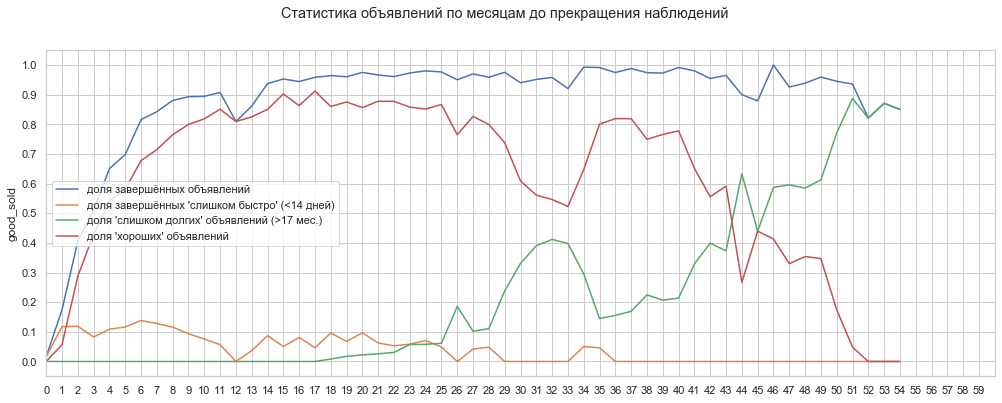

In [55]:
plt.figure(figsize=(17,6))
plt.subplot()
sns.lineplot(x=sold_statistic.index,y=sold_statistic['sold_vs_started'], 
             label="доля завершённых объявлений" )
sns.lineplot(x=sold_statistic.index,y=sold_statistic['too_fast_vs_started'], 
             label=f"доля завершённых 'слишком быстро' (<{TOO_FAST_LIMIT} дней)")
sns.lineplot(x=sold_statistic.index,y=sold_statistic['too_slow_vs_started'], 
             label=f"доля 'слишком долгих' объявлений (>{int(TOO_SLOW_LIMIT/30)} мес.)")
sns.lineplot(x=sold_statistic.index,y=sold_statistic['good_sold'], label="доля 'хороших' объявлений")
plt.xticks(range(0,60))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlim(0,60)
plt.suptitle('Статистика объявлений по месяцам до прекращения наблюдений')
plt.show()

Представленный выше график содержит следующую инормацию: 
- доля завершённых объявлений: в каждом месяце подано$\ N $ объявлений о продаже. За ними успели понаблюдать $\ x $ месяцев. $\ M $ из них было завершено за эти$\ x $ месяцев. Каждому$\ x $ соответствует значение$\ M / N $ на оси $\ y $
- доля быстрых продаж: доля объявлений, закрытых менее чем за 2 недели после подачи
- доля медленных продаж: доля объявлений, закрытых более чем за 17 месяцев
- доля "хороших" объявлений": доля завершённых за вычетом быстрых и медленных

Если оставить в рассмотрении данные всех незакрытых объявлений, мы рискуем получить завышенные цены или "висяки" - непродающиеся объекты. Но, как показывает график, такие вещи характерны не более чем для 5% случаев. Удалив же все данные без сроков продаж, потеряем за 2019г 2/3 данных, за 2018 - 13%. Это серьёзнее.

**Чтобы их можно было отделить от других, но учитывать в расчётах и не потерять при срезах с операциями $\ >, < $, заполним <code>NaN</code> в <code>'days_exposition'</code> нехарактерными значениями: <code>-100</code>**

In [56]:
flat_data['days_exposition'] = flat_data['days_exposition'].fillna(-100)

In [57]:
flat_data['days_exposition'].isna().sum()

0

**Почему 17 месяцев выбрано как порог "медленных" продаж.** Судя по графику, зависимость доли продаж от времени наблюдений есть примерно до 17го месяца. С 14 оно ослабевает, а с 18 месяца график выходит на плато. Т.е., то, что не продаётся за 17 месяцев - редко продаётся вообще. А за 17 месяцев успешно завершается более 95% объявлений. Т.е. 17 месяцев отбросит "висяки" и сохранит то, что всё же продаётся, но долго.


На всех графиках спад в районе цифры 12. Это май 2018 года. В районе 12 апреля произошёл скачок доллара примерно на 10%, все крупные сделки совершались с осторожностью.

Скачок медленных продаж с 28 по 35 месяц и скачки быстрых продаж по границам этого диапазона: Это время колебаний, после которого начало расти число объявлений на платформе (видно по таблице). Возможно, время развития платформы. Было много некорректных объявлений, или популярность платформы была низкой, квартиры долго продавались. Далее доля долгих продаж ещё растёт. Опять же, наверное, это связано с развитием продающей платформы, отсутствием популярности, должной модерации и т.д.


Быстрые продажи более-менее стабильно занимают около 10% всех продаж около в течение 2х последних лет (с провалом в мае 2018, когда провалилось всё). Видимо, это стабильные демпинговые операции по срочному выкупу или чему-то подобному. Возможно, снятие ошибочных объявлений или удаление объявлений в связи с модерировнием платформы.


Фактически, с мая 2017 года статистика объявлений на платформе Яндекс.Недвижимость стабильная. 

**Почему 2 недели выбрано в качестве границы "быстрых продаж":**

Информация в интернет, личный опыт и здравый смысл говорят о том, что шансов продать квартиру за рыночную цену менее чем за 2 недели по объявлению практически нет. Например, с портала [КВАРТИРА-БЕЗ-АГЕНТА.ру](https://kvartira-bez-agenta.ru/melochi/skolko-vremeni-zanimaet-prodazha-kvartiry/):

>Cобственно сделка купли-продажи квартиры (подготовка + оформление + регистрация) длится недолго, буквально, считанные дни, иногда – недели. Основная потеря времени уходит на рекламу квартиры и поиск/ожидание Покупателя (может растянуться на месяцы).
>Самый быстрый вариант продажи квартиры (через срочный выкуп):
>Поиск Покупателя = 1 день (если обратиться за услугой по срочному выкупу квартир);
>Подготовка сделки и экспресс-проверка документов = 2-3 дня (если нет явных препятствий, обременений или неожиданных сюрпризов с документами);
>Оформление сделки (подготовка и подписание Договора купли-продажи, действия по передаче денег) = 1 день;
>Регистрация перехода права по сделке в Росреестре = 3 дня. 
>ИТОГО: 6 – 7 рабочих дней.

>Типовой (усредненный) вариант продажи квартиры на основе реальной практики рынка (на примере Москвы):
>Поиск Покупателя = 1-3 месяца (если цена адекватна рынку, и сам рынок не находится в состоянии падения);
>Подготовка сделки, сбор документов и их проверка Покупателем = 5-10 рабочих дней (в зависимости от необходимости >получения справок из Опеки, НД и ПНД, техпаспорта и других документов для особых случаев);
>Оформление сделки (подготовка и подписание Договора купли-продажи, действия по передаче денег) = 1 день;
>Регистрация в Росреестре = 3-5 рабочих дней (в зависимости от способа заключения договора – нотариальный или в >простой письменной форме). 
>ИТОГО: 1,5 – 4 месяца. 

[domofond.ru](https://www.domofond.ru/statya/vo_skolko_oboydetsya_srochnaya_prodazha_nedvizhimosti/100605):
>"... средний срок продажи однокомнатных квартир составляет 1–2 месяца, двухкомнатных — 2–4 месяца, трехкомнатных — до 6 месяцев" © Гита Герасимова, директор по маркетингу компании ПИК-Брокер:

>"В среднем реализация объекта при срочной продаже занимает 1–2 месяца" © Мария Литинецкая, управляющий партнер компании «Метриум», участник партнерской сети CBRE

>"...иная картина наблюдается на проектах, где квартира с фиксацией цены бронируется застройщиком всего на 15 рабочих дней — за это время почти нереально реализовать вторичную квартиру, имеющуюся у потенциального покупателя новостройки" © Ирина Доброхотова, председатель совета директоров «БЕСТ-Новострой»:

Таким образом, 2 недели, вроде бы, та граница, на которой только должны начинаться продажи. Вероятно, рост продаж можно ожидать с 3й - 4й недели от подачи объявления. На графике так и есть: примерно после 1го месяца график "хороших продаж" начинает расти.

Boxplot и скрипичный график распределения сроков продаж:

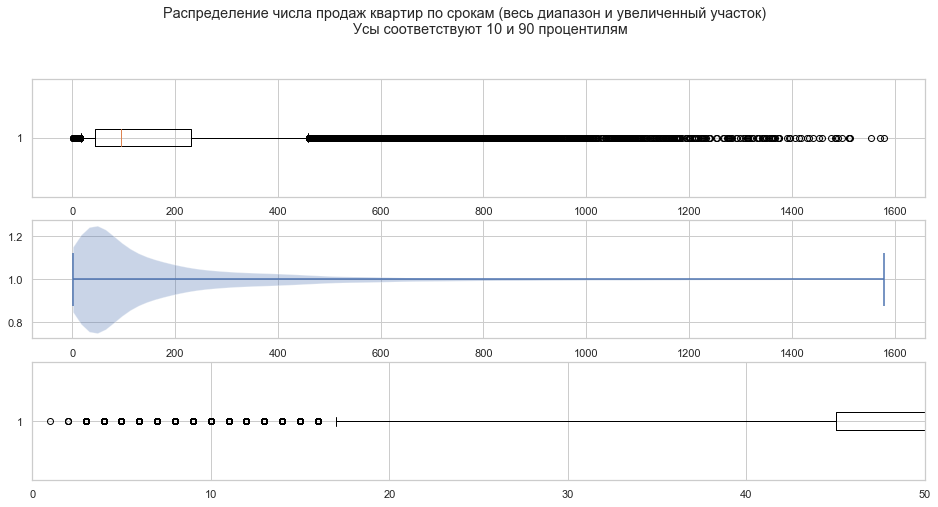

In [58]:
plt.figure(figsize=(16, 10))

plt.subplot(4,1,1)
plt.boxplot(days_exposition_all_NOTnan, whis=(10, 90), vert=False)
plt.grid(True)

plt.subplot(4,1,2)
plt.violinplot(days_exposition_all_NOTnan, vert=False)
plt.grid(True)

plt.subplot(4,1,3)
plt.boxplot(days_exposition_all_NOTnan, whis=(10, 90), vert=False)
plt.xlim(0, 50)
plt.grid(True)

plt.suptitle("""Распределение числа продаж квартир по срокам (весь диапазон и увеличенный участок)
             Усы соответствуют 10 и 90 процентилям
             """)
plt.show()

Оценим, сколько данных находится в диапазоне 14 дней - 17 месяцев

In [59]:
flat_data.loc[flat_data.loc[:,'days_exposition'] > 0, 'days_exposition'].quantile([0.92, 0.08])

0.92    518.0
0.08     14.0
Name: days_exposition, dtype: float64

И сколько возьмём из незавершенных объявлений:

In [60]:
#left_until_unloading < (TOO_SLOW_LIMIT / 30)
#незакрытые объявления, провисевшие менее (@TOO_SLOW_LIMIT / 30) месяцев до выгрузки базы
flat_data.query('(days_exposition < 0) and (observation_time <= (@TOO_SLOW_LIMIT / 30))')['days_exposition'].count()

2782

Около 84% от всех завершённых объявлений и 2782 из незавершённых. Похоже, это то, с чем можно работать, остальное придётся отбросить. Прежде, чем это сделать, надо попытаться определить, есть ли особенности у записей из "быстрых" и "медленных" продаж.

**Построим гистограммы плотности распределения для быстрых и медленных продаж и посмотрим, в чём отличия.**

In [61]:
#функция построения гистограмм по срезам в общих осях
def fast_slow_hist(df, column, up_to=14, more_than=30, N_bins = 50):
    clean_df = df.loc[~df.loc[:, column].isna(), :]
    range_lower = clean_df[column].quantile(0.00)
    range_upper = clean_df[column].quantile(0.98)
    range_hist = (range_lower, range_upper)
    hist_title = column
  
    label_up_to = f"За {up_to} или быстрее"
    label_more_than = f"За {more_than} или дольше"
    plt.hist(clean_df.query("@up_to >= days_exposition > 0")[column], 
             bins=N_bins, density=True, range=range_hist, label=label_up_to)
    
    plt.hist(clean_df.query('@more_than <= days_exposition')[column],
             bins=N_bins, density=True, range=range_hist, alpha=0.6, label=label_more_than)
    plt.title(hist_title)
    plt.legend()
    plt.grid(True)

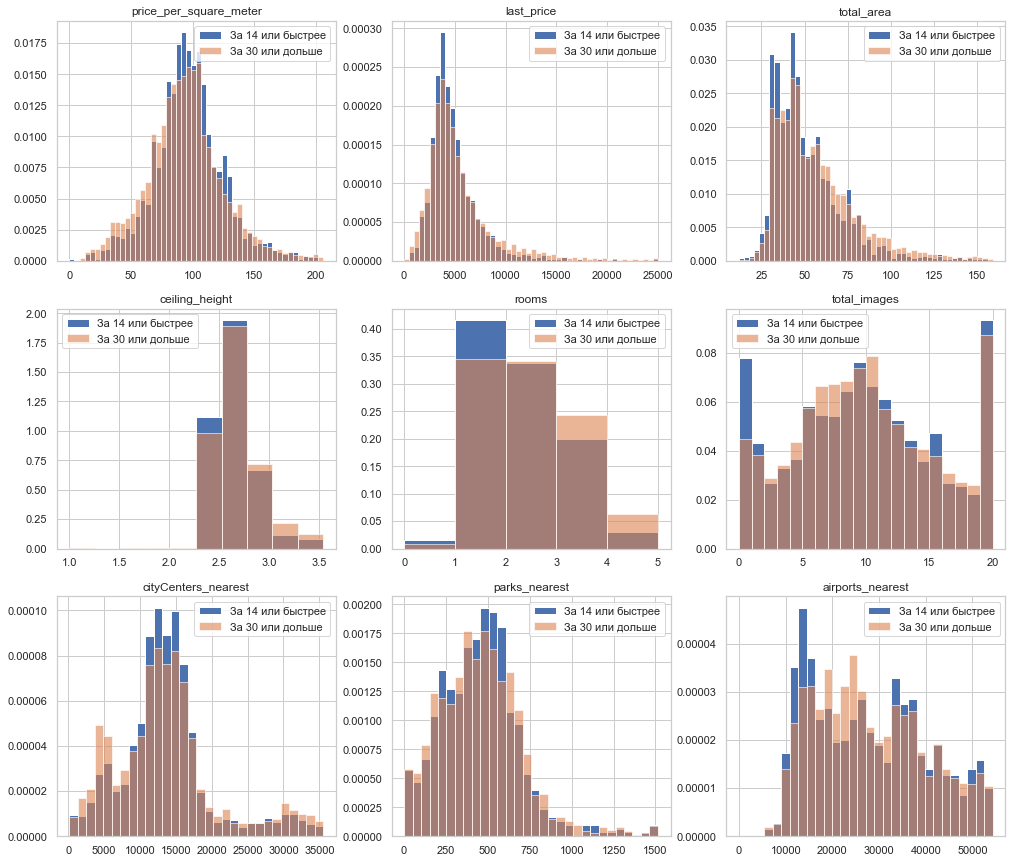

In [62]:
plt.figure(figsize=(17, 15))
plt.subplot(3, 3, 1)
fast_slow_hist(flat_data, "price_per_square_meter")
plt.subplot(3, 3, 2)
fast_slow_hist(flat_data, "last_price")
plt.subplot(3, 3, 3)
fast_slow_hist(flat_data, "total_area")
plt.subplot(3, 3, 4)
fast_slow_hist(flat_data, "ceiling_height", N_bins=10)
plt.subplot(3, 3, 5)
fast_slow_hist(flat_data, "rooms", N_bins=5)
plt.subplot(3, 3, 6)
fast_slow_hist(flat_data, "total_images",N_bins=20)
plt.subplot(3, 3, 7)
fast_slow_hist(flat_data, "cityCenters_nearest", N_bins=30)
plt.subplot(3, 3, 8)
fast_slow_hist(flat_data, "parks_nearest", N_bins=30)
plt.subplot(3, 3, 9)
fast_slow_hist(flat_data, "airports_nearest", N_bins=30)

plt.show()

Характерен пик на расстояниях пимерно 10-15 км от Пулково и от центра. Возможно, в каком-то населённом пункте быстрых продаж больше?

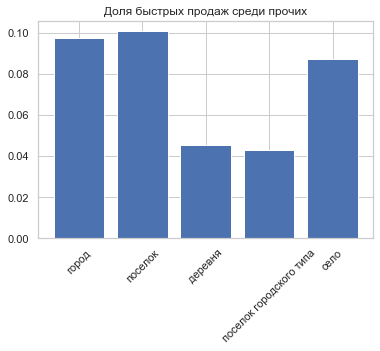

In [63]:
fast_ads_ratio = (
    flat_data.query("14 >= days_exposition > 0")["locality_type_new"].value_counts() / 
    flat_data.query("14 < days_exposition")["locality_type_new"].value_counts()
)

plt.bar(x=fast_ads_ratio.index, height=fast_ads_ratio)
plt.title('Доля быстрых продаж среди прочих')
plt.xticks(rotation=45)
plt.show()


Получается, что **основная доля быстрых продаж - в городах и посёлках. В ПГТ и деревнях их меньше всего (видимо, невыгоден срочный выкуп и в целом меньше спрос). Быстрых объявлений больше, чем, остальных, в районе 10-15км от Пулково и на таком же расстоянии от центра Петербурга (т.е. это юг Санкт-Петербурга в районе Пуково). "Быстрых" объявлений без фото в 2 раза больше, чем прочих бех фото. В "быстрых" объявлениях чаще встречаются квартиры малой и средней площади (пик в районе 20-40м^2) и, соответственно, средней цены (3-4 млн). Немного чаще среди быстрых попадаются однокомнатные квартиры со стандартными потолками 2.5 метра**

Всё вполне логично, кроме сроков продажи. Возможно, это какой-то сбой системы или результат очистки данных на продающей площадке (удаление объявлений - дублей), а также - ошибочное размещение, возможный демпинг и срочный выкуп.

**Посмотрим, для каких квартир характерно долгое время продажи:**

In [64]:
slow_up_to = 365
slow_more_than = 500

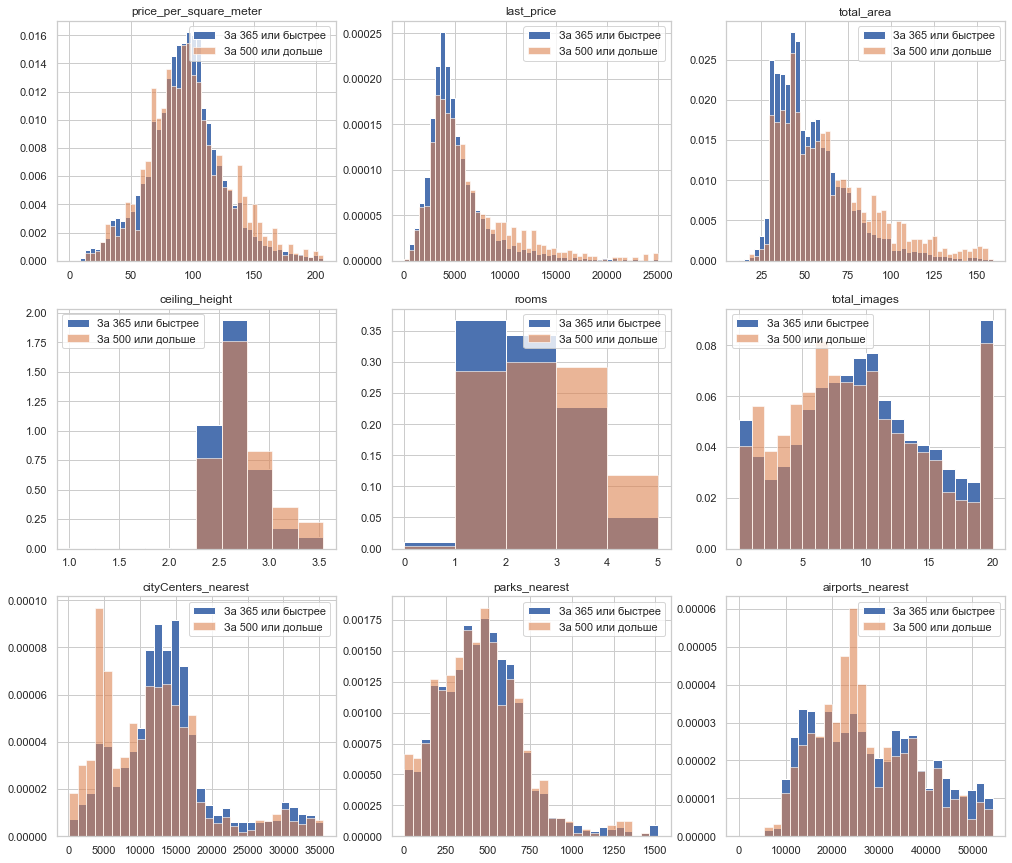

In [65]:
plt.figure(figsize=(17, 15))

plt.subplot(3, 3, 1)
fast_slow_hist(flat_data, "price_per_square_meter", up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 2)
fast_slow_hist(flat_data, "last_price", up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 3)
fast_slow_hist(flat_data, "total_area", up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 4)
fast_slow_hist(flat_data, "ceiling_height", up_to=slow_up_to, more_than = slow_more_than, N_bins=10)
plt.subplot(3, 3, 5)
fast_slow_hist(flat_data, "rooms", N_bins=5, up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 6)
fast_slow_hist(flat_data, "total_images",N_bins=20, up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 7)
fast_slow_hist(flat_data, "cityCenters_nearest", N_bins=30, up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 8)
fast_slow_hist(flat_data, "parks_nearest", N_bins=30, up_to=slow_up_to, more_than = slow_more_than)
plt.subplot(3, 3, 9)
fast_slow_hist(flat_data, "airports_nearest", N_bins=30, up_to=slow_up_to, more_than = slow_more_than)
plt.show()

In [66]:
flat_data.query('20 < airports_nearest < 30' and 'days_exposition > 500')['locality_name_new'].value_counts().head(5)

Санкт-Петербург    1210
Кудрово              37
Мурино               34
Всеволожск           31
Пушкин               29
Name: locality_name_new, dtype: int64

Вполне ожидаемо, что **среди долго продающихся квартир растёт доля квартир в центре города, с большим числом комнат и высокими потолками. Кстати, гистограмма числа фото для таких квартир смещена в меньшую сторону. На гистограммах стоимости, цены и площади они утяжеляют хвост, т.е. среди долго продающихся квартир немного больше доля больших и дорогих. Однако основной пул схож с пулом жилья, проданного менее чем за год. Видимо, цены относительно рынка завышены.** Что, всё же, указывает на необходимость очистки.

Ситуация вполне логична, но данные необходимо очистить, чтобы исключить демпинг рынка и завышенные цены. 

**Оптимальным выглядит срез от 2 недель до 17 месяцев. Потеряем 18% сомнительных данных, но сохраним данные для больших и дорогих квартир в центре, а также - ликвидных недорогих объектов, которые быстро продаются.**

In [67]:
fast_flats = flat_data.query("@TOO_FAST_LIMIT > days_exposition > 0")
#left_until_unloading > (TOO_SLOW_LIMIT / 30)
#незакрытые объявления, провисевшие дольше, чем (@TOO_SLOW_LIMIT / 30) месяцев до выгрузки базы
slow_flats = flat_data.query("(@TOO_SLOW_LIMIT < days_exposition) or (days_exposition < 0 and observation_time > @TOO_SLOW_LIMIT / 30)")
flat_data_good = flat_data.query("(@TOO_FAST_LIMIT <= days_exposition <= @TOO_SLOW_LIMIT) or (days_exposition < 0 and observation_time < @TOO_SLOW_LIMIT / 30)")

**Полученные после среза гистограммы распределения продаж по продолжительности:** (пик в отрицательной области - незавершённые объявления; теперь их видно и они не потярились; среди них остались только те, что младше 17 месяцев)

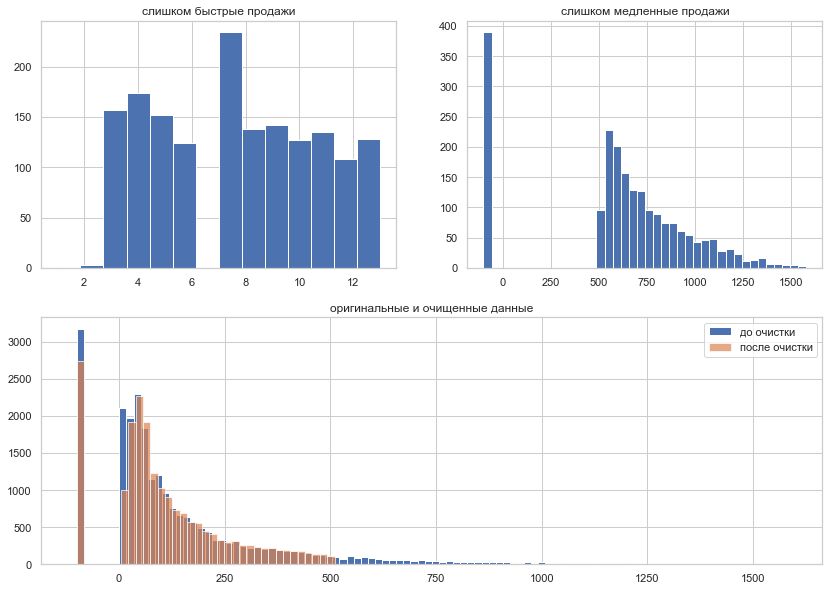

In [68]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.title('слишком быстрые продажи')
fast_flats.days_exposition.hist(bins=14)
plt.subplot(2,2,2)
plt.title('слишком медленные продажи')
slow_flats.days_exposition.hist(bins=40)
plt.subplot(2,1,2)
plt.title('оригинальные и очищенные данные')
flat_data.days_exposition.hist(bins=100, label='до очистки')
flat_data_good.days_exposition.hist(bins=35, alpha=0.7, label='после очистки')
plt.legend()
plt.show()

In [69]:
flat_data_good.loc[flat_data_good.loc[:, 'days_exposition'] > 0, 'days_exposition'].describe()

count    17104.000000
mean       139.881841
std        120.735406
min         14.000000
25%         45.000000
50%         95.000000
75%        196.000000
max        510.000000
Name: days_exposition, dtype: float64

In [70]:
flat_data_good.loc[flat_data_good.loc[:, 'days_exposition'] > 0, 'days_exposition'].quantile([0.1, 0.9])

0.1     28.0
0.9    337.0
Name: days_exposition, dtype: float64

In [71]:
flat_data_good.shape[0]/flat_data.shape[0]

0.8423085083810736

### Выводы по обработке "days_exposition"

- В 2019 с 5 месяца нет данных о завершении объявлений. 5 месяц - месяц, когда были выгружены предоставленные данные. За 2019 год почти 2/3 объявлений не завершены. 


- Необходимы для анализа пропусков и досчитаны в таблицу <code>start_year, start_month, start_month_year, observation_time</code> год, месяц, месяц + год подачи объявления, время прошедшее с подачи объявления до выгрузки базы ("время наблюдения" за объявлением в месяцах)


- Границы быстрых и медленных продаж установлены на 14 днях и 510 днях соответственно. Даны пояснения. Значения за границами исключены из рассмотрения


- Среди объявлений с пропусками в "days_exposition" отсеяны слишком долгие продажи. Признак - со старта объявления до выгрузки базы прошло дольше, чем установленный пророг долгих продаж. Прочие сохранены. Выполнена замена NaN на нехарактерное значение -100 для возможности учёта и упрощения работы на срезах.


- Быстрые объявления преобладают на юге Санкт-Петербурга, в 10-15 км от Пулково. В 2 раза чаще, чем прочие, встречаются быстрые объявления без фото. Быстрые продажи - это чаще квартиры малой и средней площади (пик в районе 20-40м^2) и, соответственно, средней цены (3-4 млн). Среди них больше однокомнатных со стандартными потолками 2.5 метра. По месяцам всей истории наблюдений в последние 2 года быстрые продажи распространены относительно равномерно. Есть провал в мае 2018г по всем продажам. Совпадает со скачком доллара. Среди объявлений старше двух лет быстрые продажи встречаются скачками: два пика 27-28 и 34-35 месяцев до выгрузки базы. Прочие "старые" объявления - без быстрых продаж.


- Среди медленных объявлений чаще встречаются квартиры в центре, с высокими потолками и большей площадью. Соответственно, более дорогие. Но высока доля квартир, аналоги которых успешно были проданы другими продавцами за меньшее время. Возможно, цена на них завышена. Долгие продажи наблюдались в больших количествах более 2 лет назад. После ситуация с ними стабилизировалась на уровне ниже 10%. Непроданного жилья - менее 5%. Подробнее можно посмотреть на графике.


- Вид распределения продаж по срокам после очистки стал больше похож на ожидаемый. В среднем продажа квартиры занимает около 140 дней (4.5 месяца). В 80% случаев сделка совершается в интервале примерно от 1 до 11 месяцев. Половина продаж приходится на первые 3 месяца, а остальные растягиваются во времени почти на год.

### 2.2.4 Тип недвижимости: жилое помещение или апартаменты 
### is_apartment 

In [72]:
flat_data_good.count().sort_values()

is_apartment               2250
parks_nearest              6630
ponds_nearest              7517
balcony                   10201
ceiling_height            12111
airports_nearest          15082
cityCenters_nearest       15100
parks_around3000          15101
ponds_around3000          15101
kitchen_area              17902
living_area               18205
locality_type_new         19849
price_per_square_meter    19849
days_exposition           19849
start_year                19849
start_month               19849
locality_fullname_new     19849
locality_name_new         19849
total_images              19849
open_plan                 19849
studio                    19849
floor                     19849
floors_total              19849
rooms                     19849
first_day_exposition      19849
total_area                19849
last_price                19849
start_month_year          19849
observation_time          19849
dtype: int64

Больше всего пропущено маркеров апартаментов. С них и начнём:

In [73]:
display(f'не апартаменты: {flat_data_good.loc[~flat_data.loc[:, "is_apartment"].isna(), "is_apartment"].count()}',
        f'апартаменты: {flat_data_good.loc[flat_data.loc[:, "is_apartment"] == True, "is_apartment"].sum()}',
        f'пропуски: {flat_data_good.loc[:, "is_apartment"].isna().sum()}')

'не апартаменты: 2250'

'апартаменты: 33'

'пропуски: 17599'

Вероятно, что жилой недвижимости на рынке гораздо больше, чем апартаментов. Также вероятно, что, если на продажу выставляют апартаменты, это отмечают особо. Скорее всего, графа "аппартаменты" не была заполнена для обычной жилой недвижимости. 


Апартаментов слишком мало, чтобы использовать их для оценок. Посмотрим, отличается ли общая статистика записей для не-апартаментов (False) и для апартаментов (True)? И вообще, есть ли шансы найти апартаменты среди отсутствующих значений?

Посмотрим средние, СКО и медианы для стоимости, общей площади, этажа, этажности здания, числа комнат

In [74]:
apart_pivot_params = ["price_per_square_meter", "total_area", "floor", "floors_total", "rooms", 
                      "ceiling_height","days_exposition"]

for func in ["mean","std","median"]:
    display(func, flat_data_good.pivot_table(index="is_apartment", 
                                   values = apart_pivot_params, 
                                   aggfunc=func, margins=True).round(1))

'mean'

ceiling_height  days_exposition  floor  floors_total  \
is_apartment                                                         
False                    2.9            134.8    5.8          10.7   
True                     7.0             49.7    4.5           6.5   
All                      3.0            131.6    5.7          10.4   

              price_per_square_meter  rooms  total_area  
is_apartment                                             
False                           98.0    2.1        60.3  
True                           136.8    2.0        69.9  
All                            100.5    2.1        62.5

'std'

ceiling_height  days_exposition  floor  floors_total  \
is_apartment                                                         
False                    1.8            144.0    4.8           6.5   
True                    17.8            138.4    4.1           5.4   
All                      3.2            151.4    4.7           6.4   

              price_per_square_meter  rooms  total_area  
is_apartment                                             
False                           51.2    1.0        31.4  
True                           110.3    1.2        28.5  
All                             51.3    1.0        31.6

'median'

ceiling_height  days_exposition  floor  floors_total  \
is_apartment                                                         
False                    2.7            100.0      4           9.0   
True                     3.0             44.0      3           4.0   
All                      2.7             98.5      4           9.0   

              price_per_square_meter  rooms  total_area  
is_apartment                                             
False                             93      2        53.0  
True                             111      2        58.7  
All                               95      2        55.2

В среднем, апартаменты выделяются. Дома, в которых они расположены  - более низкие, сами аппартаменты несколько больше по площади, цена квадратного метра у них выше, а этаж расположения - ниже, чем для не-аппартаментов. У апартаментов - высокие потолки. Апартаменты быстрее продаются в среднем. Пожалуй, наиболее выделяются апартаменты по высоте потолков, этажу, этажности и скорости продажи. Но СКО везде высокие, выборки явно асимметричные и с выбросами. 

Может, апартаменты - точно не студии и не свободной планировки?

In [75]:
flat_data_good.pivot_table(index="is_apartment", values = ["studio", "open_plan"], aggfunc=["sum"]).round(1)

sum       
             open_plan studio
is_apartment                 
False              6.0   13.0
True               0.0    0.0

Да, ни одних апартаментов-студии или свободной планировки. Но и в не-апартаментах суммарный процент студий и свободных планировок меньше 1%.

**Вывод:**

Уверенно разделить пропуски на апартаменты и не-апартаменты по имеющимся данным нельзя. Судить о влиянии типа жилья "апартаменты" на стоимость на основании подтверждённых 38 предложений - рискованно. Нет смысла заполнять пропуски. Удалять столбец пока тоже не будем, он может пригодиться при очистке данных

### 2.2.5 Парки, водоёмы и центр города: 

### parks_nearest, ponds_nearest, parks_around3000, ponds_around3000, cityCenters_nearest

Есть подозрение, что расстояние до ближайшего парка или водоёма не указано там, где в радиусе 3000м парков и водоёмов нет. Проверим:

Сложим число записей с пропусками в "parks_nearest" и нулём в "parks_around3000", и число записей без пропусков в "parks_nearest":

In [76]:
(flat_data_good.loc[
    flat_data_good.loc[:, "parks_nearest"].isna() & (flat_data.loc[:, "parks_around3000"] == 0), 
    "total_area"].count()
 +
flat_data_good.loc[~flat_data_good.loc[:, "parks_nearest"].isna(), "total_area"].count() 
)

15101

Аналогично для водоёмов:

In [77]:
(flat_data_good.loc[
    flat_data.loc[:, "ponds_nearest"].isna() & (flat_data.loc[:, "ponds_around3000"] == 0), 
    "total_area"].count()
 +
 flat_data_good.loc[~flat_data.loc[:, "ponds_nearest"].isna(), "total_area"].count())

15101

**Так и есть: о расстоянии до ближайшего нет данных там, где нет парков и водоёмов.** Всё логично и вряд ли можно чем-то заполнить, кроме "флагов". Посмотрим, есть ли данные о расстоянии до парков и водоёмов, если в радиусе 3км таковых нет:

In [78]:
display("водоёмы дальше 3км:", flat_data_good.loc[(flat_data.loc[:, "ponds_nearest"] > 3000), :],
       "парки дальше 3 км:", flat_data_good.loc[(flat_data.loc[:, "parks_nearest"] > 3000), :])

'водоёмы дальше 3км:'

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_name_new, locality_type_new, locality_fullname_new, price_per_square_meter, start_year, start_month, start_month_year, observation_time]
Index: []

'парки дальше 3 км:'

total_images  last_price  total_area first_day_exposition  rooms  \
10959             9        3000        31.1           2017-03-21      1   
19208            17       14950       187.0           2017-10-12      5   
19430             9        3900        30.5           2018-02-22      1   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
10959             NaN           5.0         17.7      2          NaN   False   
19208             3.0           2.0         80.0      2          NaN   False   
19430             2.6           5.0         16.5      1          NaN   False   

       open_plan  kitchen_area  balcony  airports_nearest  \
10959      False           5.5      0.0           14821.0   
19208      False          17.0      1.0           36805.0   
19430      False           5.5      NaN           14821.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
10959               9734.0               0.0         3190.0               1.0   
19208               8656.0               0.0         3013.0               3.0   
19430               9734.0               0.0         3190.0               1.0   

       ponds_nearest  days_exposition locality_name_new locality_type_new  \
10959          431.0            234.0   Санкт-Петербург             город   
19208          537.0             49.0   Санкт-Петербург             город   
19430          431.0            176.0   Санкт-Петербург             город   

       locality_fullname_new  price_per_square_meter  start_year  start_month  \
10959  город Санкт-Петербург                      96        2017            3   
19208  город Санкт-Петербург                      80        2017           10   
19430  город Санкт-Петербург                     128        2018            2   

      start_month_year  observation_time  
10959          2017-03                26  
19208          2017-10                19  
19430          2018-02                15

Для парков есть всего 4 записи, где в радиусе 3км парков нет, но есть данные о расстоянии до ближайшего парка. И все они чуть-чуть не дотянули до 3 км: 3190 самый далёкий. Т.е. снова убеждаемся: **если поблизости (в 3км) парка или водоёма нет, то нет и данных о расстоянии до него. Если парк или водоём есть поблизости, то и расстояние указано.**

Судя по цифрам, расстояние до центра города не указано для тех же записей, для которых нет данных о водоёмах и парках. Посмотрим, для каких типов населённых пунктов данные есть и для каких - нет:

In [79]:
 flat_data_good.groupby("locality_type_new")[["parks_around3000",
                                        "parks_nearest",
                                        "ponds_around3000",
                                        "ponds_nearest",
                                        "cityCenters_nearest"]].count()

parks_around3000  parks_nearest  ponds_around3000  \
locality_type_new                                                            
город                               14304           6607             14304   
деревня                                 0              0                 0   
поселок                               797             23               797   
поселок городского типа                 0              0                 0   
село                                    0              0                 0   

                         ponds_nearest  cityCenters_nearest  
locality_type_new                                            
город                             7301                14303  
деревня                              0                    0  
поселок                            216                  797  
поселок городского типа              0                    0  
село                                 0                    0

Т.е. в данных нет сёл, деревень и ПГТ с информацией о парках, водоёмах и расстоянии до центра города. Данные есть только для городов и для посёлков

Для посёлков: 

- для 63% есть данные о парках, водоёмах и расстоянии до центра города
- для 2% есть данные о расстоянии до парков
- для 17% есть данные о расстоянии до водоёмов

**Вывод:**


1. Там, где вблизи нет парков и водоёмов, нет и информации о расстоянии до них.


2. Информация о парках, водоёмах и расстоянии до центра города отсутствует у одних и тех же объявлений. Полностью отсутствует данная информация для деревень, ПТГ и сёл. В большинстве объявлений о продаже недвижимости в посёлках указан 0 количестве парков и водоёмов в радиусе 3км. Более-менее вразумительная выборка есть для городов, но и там парки и водоёмы есть поблизости менее чем в половине случаев.


3. Пропуски в расстоянии до ближайшего парка можно заполнить средними, но заполнение не делалось во избежание внесения смещения в данные.

Видимо, отсутствующие данные связаны с особенностями работы автоматической системы или отсутствием в ней картографических данных. Отсутствие данных о парках для деревень и сёл вполне логично, а вот отсутствие информации о водоёмах - удивляет, т.к. это важный показатель. Странно, что ни для одного ПГТ также нет информации.

### 2.2.6 Расстояние до ближайшего аэропорта в метрах (м) 
### airports_nearest

Расстояние до аэропорта в ряде случаев, наверное, можно восстановить, используя усреднённые данные для населённых пунктов. (Если только это не Санкт-Петербург или прилегающие к Пулково населённые пункты. Для них важно, в каком районе города находится недвижимость, усреднить по городу в целом не получится)
Посмотрим, для скольких населённых пунктов характерно отсутствие данных:

In [80]:
display(
    f"""нет данных для {flat_data_good.loc[
                                        flat_data_good.loc[:, "airports_nearest"].isna(), 
                                        "locality_fullname_new"].unique().size} населённых пунктов""",
    f'есть данные для:'
    )
display(flat_data_good.loc[~flat_data_good.loc[:, "airports_nearest"].isna(), "locality_fullname_new"].unique())

'нет данных для 287 населённых пунктов'

'есть данные для:'

array(['город Санкт-Петербург', 'поселок Шушары', 'поселок Парголово',
       'город Петергоф', 'город Пушкин', 'город Колпино',
       'город Ломоносов', 'город Кронштадт', 'поселок Металлострой',
       'город Павловск', 'город Сестрорецк', 'город Красное Село',
       'поселок Понтонный', 'город Зеленогорск',
       'поселок Александровская', 'поселок Стрельна', 'поселок Песочный',
       'поселок Петро-Славянка', 'поселок Саперный', 'поселок Молодежное',
       'поселок Репино', 'поселок Лисий Нос', 'поселок Левашово',
       'поселок Белоостров', 'поселок Усть-Ижора'], dtype=object)

Посмотрим, большая ли вариабельность расстояний для этих населённых пунктов? Выведем топ-10 по числу объектов недвижимости.

In [81]:
flat_data_good.pivot_table(index='locality_fullname_new', 
                           values='airports_nearest', 
                           aggfunc=(["median", "mean", "std", "count"])).round(0).sort_values(('count', 
                                                                                               'airports_nearest'), 
                                                                                              ascending=False).head(10)


median             mean              std  \
                      airports_nearest airports_nearest airports_nearest   
город Санкт-Петербург          26963.0          28154.0          11647.0   
поселок Шушары                 17486.0          16135.0           3835.0   
город Пушкин                   16332.0          16536.0           2554.0   
город Колпино                  26232.0          26377.0           1601.0   
поселок Парголово              53494.0          54138.0           3051.0   
город Петергоф                 39313.0          40347.0           4038.0   
город Сестрорецк               56781.0          56656.0           2144.0   
город Красное Село             25697.0          26678.0           2920.0   
город Ломоносов                48400.0          48342.0           1278.0   
город Кронштадт                67950.0          67525.0           1646.0   

                                 count  
                      airports_nearest  
город Санкт-Петербург            12972  
поселок Шушары                     383  
город Пушкин                       297  
город Колпино                      294  
поселок Парголово                  284  
город Петергоф                     171  
город Сестрорецк                   157  
город Красное Село                 155  
город Ломоносов                    102  
город Кронштадт                     85

Вариабельность небольшая (ожидаемо), кроме крупных городов, находящихся рядом с Пулково (ожидаемо). Кстати, это всё - населённые пункты в окрестностях Санкт-Петербурга и Пулково. Т.е. те, для которых "не всё равно", сколько до аэропорта. 
Есть ли среди них те, для которых часть данных отсутствует?

In [82]:
#объявляю список
airport_nearest_crosslist = []
#проверяю, есть ли города, для которых данные известны, в списке городов, для которых данных нет
for locality in flat_data_good.loc[flat_data_good.loc[:, "airports_nearest"].isna(), "locality_fullname_new"].unique():
    if locality in flat_data_good.loc[~flat_data_good.loc[:, "airports_nearest"].isna(), "locality_fullname_new"].unique():
            airport_nearest_crosslist.append(locality)

print(airport_nearest_crosslist)

['город Санкт-Петербург', 'поселок Шушары', 'город Красное Село', 'город Ломоносов', 'город Кронштадт', 'город Колпино']


И много пропущенных значений для них?

In [83]:
flat_data_good.loc[
    (flat_data_good.loc[:, "airports_nearest"].isna())
    & 
    (flat_data_good.loc[:, "locality_fullname_new"].isin(airport_nearest_crosslist)), 
    "locality_fullname_new"].value_counts()

город Санкт-Петербург    74
поселок Шушары            3
город Красное Село        2
город Ломоносов           1
город Колпино             1
город Кронштадт           1
Name: locality_fullname_new, dtype: int64

Не видно большого смысла для них заполнять пропуски. Навредить можно, улучшить данные - вряд ли. Посмотрим, как распределились пропуски в других населённых пунктах. Выведем топ-25

In [84]:
flat_data_good.loc[flat_data_good.loc[:, "airports_nearest"].isna(), "locality_fullname_new"].value_counts().head(25)

город Мурино                       504
город Кудрово                      393
город Всеволожск                   340
город Гатчина                      254
город Выборг                       212
город Сертолово                    122
деревня Новое Девяткино            122
город Кириши                       113
поселок Бугры                      106
город Волхов                       103
город Сланцы                       100
город Кингисепп                     93
город Тосно                         92
город Сосновый Бор                  78
город Санкт-Петербург               74
город Никольское                    72
город Кировск                       72
город Коммунар                      71
город Отрадное                      69
поселок городского типа Янино-1     65
деревня Старая                      59
город Приозерск                     56
город Луга                          52
город Тихвин                        42
город Шлиссельбург                  42
Name: locality_fullname_n

Достаточно крупные объекты, отсутствие которых может сказаться на трактовке распределения. Среди них относительно небольшие по площади (с низкой вариабельностью расстояний) и находящиеся в окрестностях СПб и Пулково:

Мурино, Кудрово, Янино-1, Новое Девяткино, Бугры, деревня Старая.

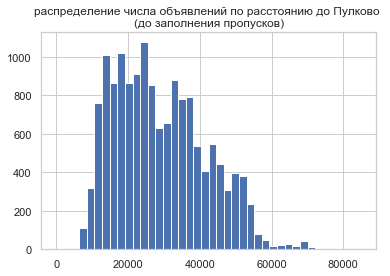

In [85]:
flat_data_good.loc[:, "airports_nearest"].hist(bins=40)
plt.title("распределение числа объявлений по расстоянию до Пулково \n(до заполнения пропусков)")
plt.show()

Логичное распределение, много объявлений в пределах 10 - 40км от Пулково и это, видимо, Санкт-Петербург и прилегающие площади. Есть провалы, видимо, связанные как раз с пропусками. Для крупных населённых пунктов, удалённых от столицы области, похоже, данные о расстоянии до аэропорта не вносились. Ну и вблизи аропорта (5-10км) просто мало жилых районов.


Попробуем сымитировать случайное распределение пропущенных расстояний в рамках ранее перечисленных населённых пунктов. Воспользуемся модулем random, данными о среднем расстоянии до аэропорта и их теоретическим разбросом (возьмём максимальный поперечник территории населённого пункта по Яндекс.Картам)

In [86]:
airports_NaN_dict = {'город Мурино': 50000,
                     'город Кудрово': 25000,
                     'деревня Новое Девяткино': 46000,
                     'поселок Бугры': 40000,
                     'поселок городского типа Янино-1': 30000,
                     'деревня Старая': 35000,
                    }
dist_variation_dict = {'город Мурино': 4300,
                       'город Кудрово': 4000,
                       'деревня Новое Девяткино': 1900,
                      'поселок Бугры': 4100,
                      'поселок городского типа Янино-1':5000,
                      'деревня Старая': 2000}
#ни в одной записи с этими населёнными пунктами о расстоянии до аэропорта нет данных
#поэтому можно по isna не фильтровать, а сразу внести в таблицу информацию.
for key in airports_NaN_dict:
    #случайно расстояние в диапазоне: 
    #расстояние от центра (согласно Яндекс) населённого пункта + 0,5*random[-поперечник, +поперечник]
    airport_rnd_dist = airports_NaN_dict[key] + 0.5*random.uniform( - dist_variation_dict[key], dist_variation_dict[key]) 
    flat_data_good.loc[flat_data_good.loc[:, "locality_fullname_new"] == key, "airports_nearest"] = airport_rnd_dist

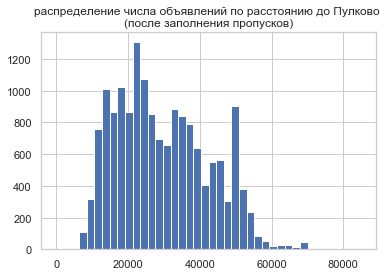

In [87]:
flat_data_good.loc[:, "airports_nearest"].hist(bins=40)
plt.title("распределение числа объявлений по расстоянию до Пулково \n(после заполнения пропусков)")
plt.show()

Гистограмма изменилась, но она отражает действительность

**Вывод:**

Данные о расстоянии до аэропорта заполнены для Санкт-Петербурга и прилегающих районов. Но не для всех. Многие населённые пункты данных не имеют (Мурино, Кудрово, Янино-1, Новое Девяткино, Бугры, деревня Старая, Гатчина и т.д.)

Для Мурино, Кудрово, Янино-1, Новое Девяткино, Бугры, деревня Старая пропуски заполнены значениями, случайно отличающимися от среднего расстояния по Яндекс.Картам в пределах размера населённого пункта. Применён <code>random.uniform</code>

### 2.2.7 Число балконов 
### "balcony"

Данных по балконам, вероятно, нет для объектов, у которых балконов нет. Сравним, как, в зависимости от этажа, распределены балконы. На каких этажах, преимущественно, нет балконов? На каких есть? Для каких - нет данных? Какие распределения похожи между собой?

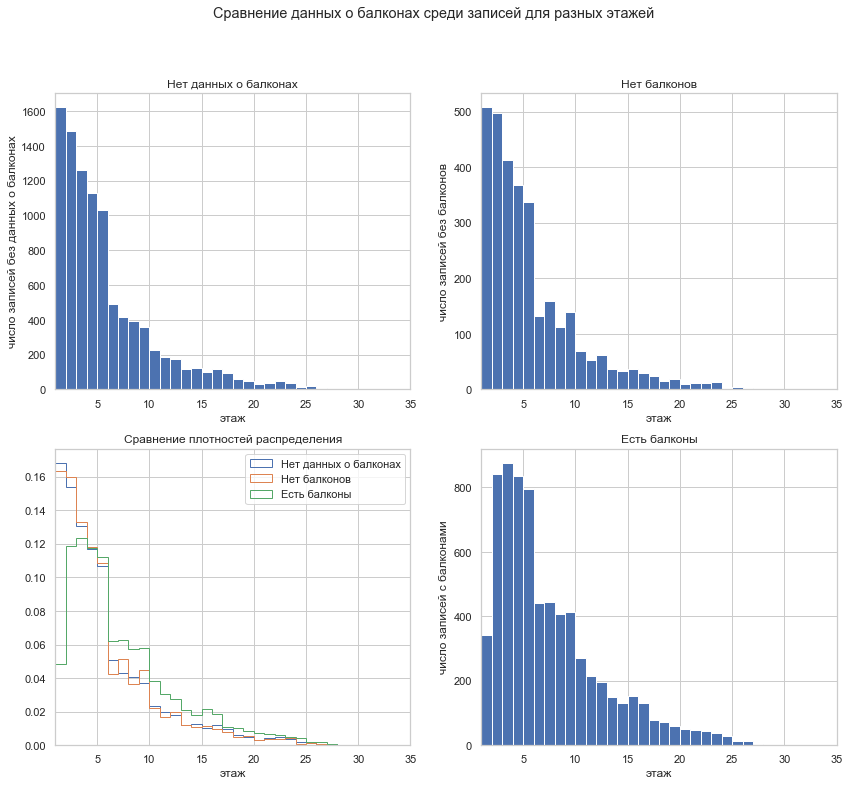

In [88]:
plt.figure(figsize=(14, 12))
bins_for_balcony = 34
range_for_balcony = (1,35)


plt.subplot(2,2,1)
plt.hist(flat_data_good.loc[flat_data_good.loc[:, "balcony"].isna(), "floor"], bins=bins_for_balcony, range=range_for_balcony)
plt.title('Нет данных о балконах')
plt.xlabel('этаж')
plt.ylabel('число записей без данных о балконах')
plt.xlim(range_for_balcony)

plt.subplot(2,2,2)
plt.hist(flat_data_good.loc[flat_data_good.loc[:, "balcony"] == 0, "floor"], bins=bins_for_balcony, range=range_for_balcony)
plt.title('Нет балконов')
plt.xlabel('этаж')
plt.xlim(range_for_balcony)
plt.ylabel('число записей без балконов')

plt.subplot(2,2,4)
plt.hist(flat_data_good.loc[flat_data_good.loc[:, "balcony"] > 0, "floor"], bins=bins_for_balcony, range=range_for_balcony)
plt.title('Есть балконы')
plt.xlabel('этаж')
plt.xlim(range_for_balcony)
plt.ylabel('число записей с балконами')

plt.subplot(2,2,3)
plt.hist(flat_data_good.loc[flat_data_good.loc[:, "balcony"].isna(), "floor"], 
         bins=bins_for_balcony, range=range_for_balcony, histtype='step', density=True, label="Нет данных о балконах")
plt.hist(flat_data_good.loc[flat_data.loc[:, "balcony"] == 0, "floor"], 
         bins=bins_for_balcony, range=range_for_balcony, histtype='step', density=True, label="Нет балконов")
plt.hist(flat_data_good.loc[flat_data.loc[:, "balcony"] > 0, "floor"], 
         bins=bins_for_balcony, range=range_for_balcony, histtype='step', density=True, label="Есть балконы")
plt.xlim(range_for_balcony)
plt.legend()
plt.title('Сравнение плотностей распределения')
plt.xlabel('этаж')
plt.suptitle("Сравнение данных о балконах среди записей для разных этажей")
plt.show()

Плотность распределения записей с balcony=0 по этажам практически совпадает с плотностью распределения записей balcony=NaN. Можно заменить NaN на 0, не опасаясь внести искажения в данные.

In [89]:
flat_data_good.loc[:, "balcony"].fillna(0, inplace=True)

In [90]:
flat_data_good.loc[:, "balcony"].isna().sum()

0

**Вывод:**

Гистограммы распределения по этажам записей с пропусками и записей с балконами очень близки. На этом основании пропуски в данных о балконах заполнены нулями.

### 2.2.8 Высота потолков "ceiling_height"

Оценим, сколько пропусков и сколько данных:

In [91]:
display(f'без пропусками: {(~flat_data_good.loc[:, "ceiling_height"].isna()).sum()}',
        f'с пропусками: {flat_data_good.loc[:, "ceiling_height"].isna().sum()}')

'без пропусками: 12111'

'с пропусками: 7738'

Посмотрим есть ли какая-то связь с населёнными пунктами:

In [92]:
flat_data.groupby("locality_type_new")[["ceiling_height", "locality_type_new"]].count()

ceiling_height  locality_type_new
locality_type_new                                         
город                             12953              20785
деревня                             384                641
поселок                             804               1543
поселок городского типа             324                564
село                                 16                 32

Приерно 40-50% пропусков для каждого типа населённого пункта. Похоже, всё достаточно равномерно и случайно.
Посмотрим гистограмму:

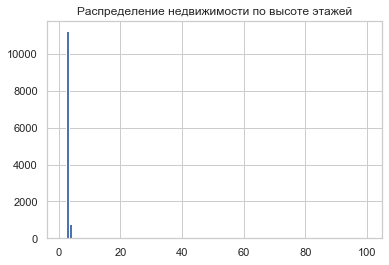

In [93]:
flat_data_good.loc[:, "ceiling_height"].hist(bins=100)
plt.title("Распределение недвижимости по высоте этажей")
plt.show()

Явно какие-то выбросы до 100 метров. Посмотрим "ящик с усами":

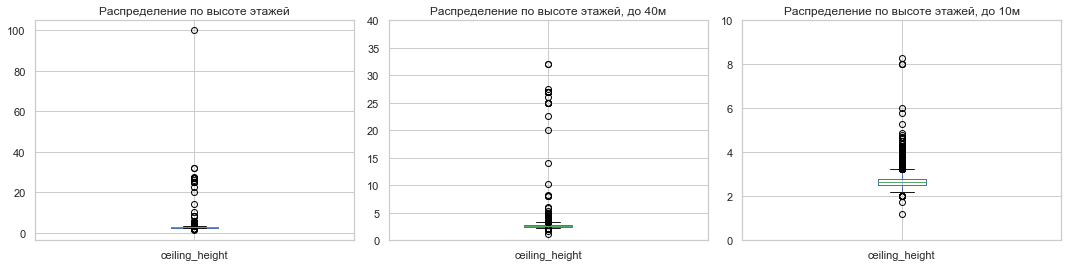

In [94]:
plt.figure(figsize=(15 , 4))
plt.subplot(1,3,1)
flat_data_good["ceiling_height"].plot(kind="box")
plt.title("Распределение по высоте этажей")

plt.subplot(1,3,2)
flat_data_good["ceiling_height"].plot(kind="box")
plt.ylim(0, 40)
plt.title("Распределение по высоте этажей, до 40м")

plt.subplot(1,3,3)
flat_data_good["ceiling_height"].plot(kind="box")
plt.ylim(0, 10)
plt.title("Распределение по высоте этажей, до 10м")

plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()

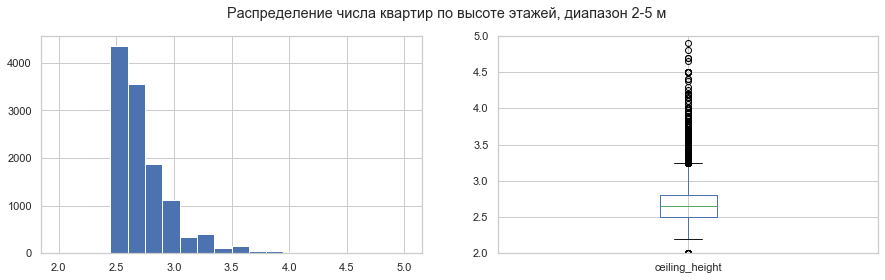

In [95]:
plt.figure(figsize=(15 , 4))
plt.subplot(1,2,1)
flat_data_good.loc[:, "ceiling_height"].hist(bins=20, range=(2, 5))

plt.subplot(1,2,2)
flat_data_good["ceiling_height"].plot(kind="box")
plt.ylim(2, 5)
plt.grid(True)

plt.suptitle("Распределение числа квартир по высоте этажей, диапазон 2-5 м")
plt.show()

Согласно СНиП 31-01-2003 "Здания жилые многоквартирные" 

>"Высота (от пола до потолка) жилых помещений и кухни (кухни-столовой) в климатических районах IА, IБ, IГ, IД и IVA должна быть не менее 2,7 м, а в других климатических районах - не менее 2,5 м. Высота внутриквартирных коридоров, холлов, передних, антресолей (и под ними) определяется условиями безопасности передвижения людей и должна составлять не менее 2,1 м."

Т.е., не вдаваясь в подробности строительной климатологии, всё, что ниже 2.1 метра не соответствует СНиП, да и здравому смыслу. А стандартная высота - от 2.5 метров и выше. Скорее всего, прочие значения - это ошибки в данных. Возможно, опечатки или проблемы несоответствия форматов при выгрузке.
Гистограмма без учёта выбросов выглядит вполне правдоподобно.

Непонятно, по какому принципу можно заполнить пропущенные значения по высоте потолков. Скорее всего, пропуски и выбросы случайны и связаны с ошибками при заполнении объявлений.

Можно, наверное, очистить данные от выбросов.  Посмотрим, сколько и каких объектов с потолками меньше 2 и больше 5 метров высотой:

In [96]:
flat_data_good.query("ceiling_height < 2")

total_images  last_price  total_area first_day_exposition  rooms  \
5712              5        1500        42.8           2017-08-14      2   
16934             5        4100        40.0           2017-10-17      1   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
5712             1.20           2.0         27.5      1          NaN   False   
16934            1.75          37.0         17.4      5          NaN   False   

       open_plan  kitchen_area  balcony  airports_nearest  \
5712       False          5.20      0.0               NaN   
16934      False          8.34      0.0           18732.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
5712                   NaN               NaN            NaN               NaN   
16934              20444.0               0.0            NaN               3.0   

       ponds_nearest  days_exposition locality_name_new  \
5712             NaN            248.0               Мга   
16934           80.0             71.0   Санкт-Петербург   

             locality_type_new        locality_fullname_new  \
5712   поселок городского типа  поселок городского типа Мга   
16934                    город        город Санкт-Петербург   

       price_per_square_meter  start_year  start_month start_month_year  \
5712                       35        2017            8          2017-08   
16934                     102        2017           10          2017-10   

       observation_time  
5712                 21  
16934                19

2 объекта, 1 в СПб, 1 в ПГТ Мга. Похоже, опечатки.

In [97]:
flat_data_good.query("ceiling_height > 5").head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
355             17        3600        55.2           2018-07-12      2   
1026            20      155000       310.0           2018-10-12      5   
3148            14        2900        75.0           2018-11-12      3   
3474             3        1400        30.0           2018-03-16      1   
4643             0        4300        45.0           2018-02-01      2   
4876             7        3000        25.0           2017-09-27      0   
5669             4        4400        50.0           2017-08-08      2   
5807            17        8150        80.0           2019-01-09      2   
5863            20        5650        45.0           2018-08-15      1   
6246             6        3300        44.4           2019-03-25      2   

      ceiling_height  floors_total  living_area  floor is_apartment  studio  \
355             25.0           5.0         32.0      2        False   False   
1026             5.3           3.0        190.0      3          NaN   False   
3148            32.0           3.0         53.0      2          NaN   False   
3474             8.0           5.0         15.3      2        False   False   
4643            25.0           9.0         30.0      2          NaN   False   
4876            27.0          25.0         17.0     17          NaN   False   
5669            26.0           9.0         21.3      3          NaN   False   
5807            27.0          36.0         41.0     13          NaN   False   
5863             8.3          16.0         19.3     14          NaN   False   
6246            25.0           5.0         31.3      5          NaN   False   

      open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
355       False           NaN      2.0               NaN                  NaN   
1026      False          63.0      2.0      24899.000000               4785.0   
3148      False           8.0      0.0               NaN                  NaN   
3474      False           7.3      0.0               NaN                  NaN   
4643      False           7.0      1.0      12016.000000              13256.0   
4876       True           NaN      2.0      50869.279479                  NaN   
5669      False           7.0      2.0      28981.000000              10912.0   
5807      False          12.0      5.0      18732.000000              20444.0   
5863      False           8.3      1.0      13069.000000              10763.0   
6246      False           5.7      0.0      68923.000000              50649.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
355                NaN            NaN               NaN            NaN   
1026               0.0            NaN               1.0          603.0   
3148               NaN            NaN               NaN            NaN   
3474               NaN            NaN               NaN            NaN   
4643               1.0          658.0               1.0          331.0   
4876               NaN            NaN               NaN            NaN   
5669               1.0          305.0               0.0            NaN   
5807               0.0            NaN               3.0           80.0   
5863               0.0            NaN               1.0          613.0   
6246               1.0          417.0               2.0           73.0   

      days_exposition locality_name_new locality_type_new  \
355             259.0           Гатчина             город   
1026           -100.0   Санкт-Петербург             город   
3148           -100.0            Волхов             город   
3474            125.0             Нурма           деревня   
4643            181.0   Санкт-Петербург             город   
4876             28.0            Мурино             город   
5669            267.0   Санкт-Петербург             город   
5807             38.0   Санкт-Петербург             город   
5863             14.0   Санкт-Петербург             город   
6246

In [98]:
flat_data_good.query("ceiling_height > 5")["total_area"].count()

28

28 объектов. Большинство с высотами 25, 27 и проч. метров напоминают опечатки (2.5, 2.7 и т.д., т.к. находятся на средних этажах 3 из 5, 4 из 5, 3 из 10) Несколько объектов с высотами 5-15м, возможно, какие-то апартаменты вроде выставочных помещений, мансарды или двухуровневые квартиры. 100м - выброс, вероятно, опечатка (10м), т.к. в пуле представлены объекты с высотами, близкими к 10 м. Тоже мансардные этажи.

Чтобы не использовать постоянно срезы и учитывая вполне вероятный механизм появления выбросов (единичные опечатки), все высоты более 20 м поделим на 10, а к высотам менее 2м прибавим метр.

In [99]:
flat_data_good.loc[flat_data_good.loc[:, "ceiling_height"] > 20, "ceiling_height"] /= 10

In [100]:
flat_data_good.loc[flat_data_good.loc[:, "ceiling_height"] < 2, "ceiling_height"] += 1

In [101]:
display('ниже 2м:', flat_data_good.query("ceiling_height < 2"),
        'выше 5м:', flat_data_good.query("ceiling_height > 5"))

'ниже 2м:'

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_name_new, locality_type_new, locality_fullname_new, price_per_square_meter, start_year, start_month, start_month_year, observation_time]
Index: []

'выше 5м:'

total_images  last_price  total_area first_day_exposition  rooms  \
1026             20      155000       310.0           2018-10-12      5   
3474              3        1400        30.0           2018-03-16      1   
5863             20        5650        45.0           2018-08-15      1   
15061            19        5600        56.4           2018-05-11      2   
15743            14        5600        67.0           2016-11-11      3   
17442             0        5350        54.0           2015-06-16      2   
17496            15        6700        92.9           2019-02-19      3   
20264            17      119000       187.6           2017-07-10      4   
21227             0        8200        71.0           2017-07-21      0   
22309            20        5300        45.0           2017-09-30      1   
22869             0       15000        25.0           2018-07-25      1   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
1026              5.3           3.0        190.0      3          NaN   False   
3474              8.0           5.0         15.3      2        False   False   
5863              8.3          16.0         19.3     14          NaN   False   
15061            14.0          14.0         32.4      5          NaN   False   
15743             8.0          16.0         41.0      1          NaN   False   
17442             8.0           5.0         29.0      2          NaN   False   
17496            20.0          17.0         53.2     14          NaN   False   
20264             6.0           7.0        147.0      7          NaN   False   
21227             5.8           5.0         68.0      5          NaN    True   
22309            10.3          16.0         15.5     15          NaN   False   
22869            10.0           5.0         14.0      5         True   False   

       open_plan  kitchen_area  balcony  airports_nearest  \
1026       False          63.0      2.0           24899.0   
3474       False           7.3      0.0               NaN   
5863       False           8.3      1.0           13069.0   
15061      False           9.1      2.0           14814.0   
15743      False           8.0      0.0           32691.0   
17442      False           NaN      1.0           24638.0   
17496      False          12.0      5.0           16295.0   
20264      False          15.6      0.0           26902.0   
21227      False           NaN      0.0           20170.0   
22309      False           NaN      0.0           36353.0   
22869      False          11.0      5.0           34963.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
1026                4785.0               0.0            NaN               1.0   
3474                   NaN               NaN            NaN               NaN   
5863               10763.0               0.0            NaN               1.0   
15061              13610.0               0.0            NaN               0.0   
15743              11035.0               1.0          723.0               0.0   
17442              28062.0               0.0            NaN               0.0   
17496              15092.0               1.0          967.0               0.0   
20264               5605.0               3.0          484.0               1.0   
21227               1261.0               2.0          295.0               3.0   
22309              11936.0               2.0          440.0               2.0   
22869               8283.0               1.0          223.0               3.0   

       ponds_nearest  days_exposition locality_name_new locality_type_new  \
1026           603.0           -100.0   Санкт-Петербург             город   
3474             NaN            125.0             Нурма           деревня   
5863           613.0             14.0   Санкт-Петербург             город   
15061            NaN            315.0   Санкт-Петербург             город   
15743            NaN            474.0   Санкт-Петербур

In [102]:
display(
    f'от 2.5 до 3.2м: {flat_data_good.query("2.5 <= ceiling_height <= 3.2")["ceiling_height"].count()}',
    f'всего данных без пропусков: {flat_data_good.loc[~flat_data_good.loc[:, "ceiling_height"].isna(), "ceiling_height"].count()}'
)

'от 2.5 до 3.2м: 11436'

'всего данных без пропусков: 12111'

Вполне реальными выглядят большие высоты для объектов последних и первых этажей. Тем более в объявлениях Яндекс.Недвижимость и ЦИАН встречаются объекты с 5-6 метровыми потолками. 
Очень странный объект - с 14м потолком на 5 этаже 14 этажного дома.

Далее очевидных решений по исправлению этих данных нет. Можно отсутствующие значения заполнить средними, но есть опасность, что не указаны низкие потолки, чтобы не отпугнуть клиента сразу. Оставим в текущем виде.

**Вывод:**

Исправлен ряд ошибочных данных. Благодаря этому убраны ошибочные выпадающие значения. Пропуски можно заполнить средними. Не заполнено из-за опасности искажения данных: отсутствующие значения могут быть умышленно не указаны, т.к. потолки низкие

### 2.2.9 Жилая площадь и площадь кухни
### living_area и kitchen_area 	

При наличии данных об общей площади (а они у нас есть) данные по жилой площади можно попытаться восстановить на основании данных о площади кухни и наоборот. Это возможно, если доля всей нежилой площади в квартире и доля кухни связаны. Кухня - это часть нежилой площади, к которой также относятся санузлы, балконы и проч. Если доля нежилой площади пропорциональна доли кухни в ней, то $\ Sобщая = Sжилая + k*Sкухни$, где $\ k = Sнежилая \div Sкухни$
Можно проверить корреляцию между $\ Sкухни$ и $\ Sобщая - Sжилая$. Если она есть, то можно найти коэффициент и заполнить пропуски. Посмотрим, сколько пропусков так можно заполнить:

In [103]:
display(
    f'пропуски в площади кухни: {flat_data_good.loc[flat_data_good.loc[:, "kitchen_area"].isna(), "total_area"].count()}',
    f'пропуски в жилой площади: {flat_data_good.loc[flat_data_good.loc[:, "living_area"].isna(), "total_area"].count()}',
    f"""можно попытаться заполнить: {flat_data_good.loc[
    flat_data_good.loc[:, "kitchen_area"].isna() 
    & ~flat_data_good.loc[:, "living_area"].isna(),
    "total_area"].count()}"""
)

'пропуски в площади кухни: 1947'

'пропуски в жилой площади: 1644'

'можно попытаться заполнить: 662'

In [104]:
flat_data_good["total_minus_living"] = flat_data_good["total_area"] - flat_data_good["living_area"]

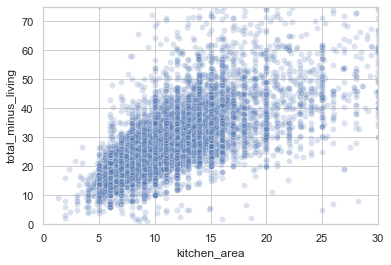

In [105]:
sns.scatterplot(x='kitchen_area', y="total_minus_living", data=flat_data_good, alpha=0.2)
plt.xlim(0,30)
plt.ylim(0,75)
plt.show()

In [106]:
display(
    f'корреляция между Sкухни и (Sобщая - Sжилая) {flat_data_good["total_minus_living"].corr(flat_data_good["kitchen_area"])}',
    f'корреляция между Sкухни и Sобщая {flat_data_good["total_area"].corr(flat_data_good["kitchen_area"])}',
    f'корреляция между Sкухни и Sжилая {flat_data_good["living_area"].corr(flat_data_good["kitchen_area"])}'
)

'корреляция между Sкухни и (Sобщая - Sжилая) 0.733567001370227'

'корреляция между Sкухни и Sобщая 0.6049385052739695'

'корреляция между Sкухни и Sжилая 0.4185757684867669'

Корреляция, чуть выше среднего и разброс значений на графике довольно большой. Плотность значений в основной области высокая, реальных значений достаточно. Сомнительно, что нужно делать замены.

Проверим вообще, все ли данные в норме. Отношение разности $\ Sобщая - Sжилая$ к $\ Sкухни$ должно быть больше единицы, иначе что-то неверно указано.

In [107]:
flat_data_good["check_area"] = flat_data_good["total_minus_living"] / flat_data_good["kitchen_area"]

In [108]:
flat_data_good["check_area"].describe()

count    17543.000000
mean         2.518021
std          0.746631
min          0.112069
25%          2.090909
50%          2.428571
75%          2.833333
max         24.410072
Name: check_area, dtype: float64

Есть и аномально большие и аномально маленькие значения. Рассмотрим гистограмму и ящик с усами:

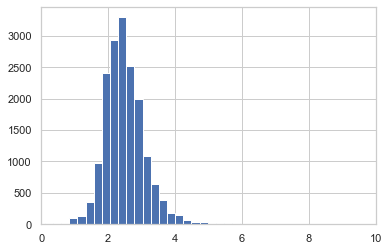

In [109]:
flat_data_good["check_area"].hist(bins=100)
plt.xlim(0,10)
plt.show()

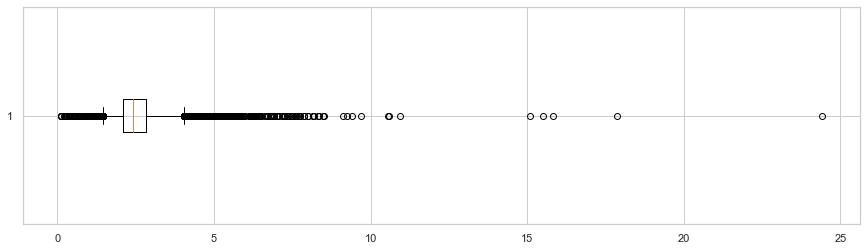

In [110]:
plt.figure(figsize=(15, 4))
plt.boxplot(flat_data_good.loc[~flat_data_good.loc[:, "check_area"].isna(), "check_area"], vert=False, whis=(2.5, 97.5))
plt.grid(True)
plt.show()

Много выбросов за пределами усов (усы установлены на 2,5 и 97,5 процентили, т.е. содержат 95% значений)

In [111]:
flat_data_good.loc[flat_data_good.loc[:, "check_area"] <= 1, "check_area"].count()

105

105 значений меньше 1.. Нужно убрать ошибки из таблицы, т.к., если неверно оценена площадь недвижимости, то и мы получим неверные результаты анализа. Вряд ли нежилая площадь без кухни (это санузлы, коридоры, балконы и проч.) может быть в 10 раз меньше, чем сама кухня. Даже при условии большой кухни, остальные площади тоже не должны быть маленькими, это крайне нелогично. В 10 раз больше кухни - тоже сомнительно.

In [112]:
flat_data_good["check_area"].quantile(0.01)

1.1666666666666667

In [113]:
flat_data_good["check_area"].quantile(0.999)

8.151477419354846

99% значений находятся в интервале от 1.17 до 8,2. Гораздо правдоподобнее, чем 0.08 - 24. 

Посмотрим, что больше 8:

In [114]:
flat_data_good.query('8 < check_area')

total_images  last_price  total_area first_day_exposition  rooms  \
866               5       25000      363.00           2017-12-23     14   
2003             23       21000      215.00           2017-11-11      4   
3365             13       22190      197.00           2017-11-20      7   
3440             19       14980      200.00           2018-10-17      4   
4435             13       22190      191.20           2017-12-05      8   
6107             20       13200      236.00           2018-07-20      4   
12859            20      140000      631.20           2019-04-09      7   
13354             1       28521      163.33           2017-06-06      4   
14706            15      401300      401.00           2016-02-20      5   
14991            19       45000      413.50           2018-09-20      7   
16179            11       28000      336.00           2017-09-27      5   
17834             5        2940       34.70           2017-10-09      1   
18701             2       25490      165.20           2018-11-28      3   
19183             5       18500      190.00           2018-02-08      4   
20820             7       73900      342.00           2015-06-18      5   
21955            19      130000      431.00           2017-10-02      7   
22037            15       10900      145.00           2017-04-17      2   
22804             4       81960      205.00           2017-09-29      4   
23555             5       15350      158.50           2019-03-07      7   
23574            14       64990      139.00           2015-11-24      3   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
866              3.16           5.0        222.0      4          NaN   False   
2003              NaN           5.0         55.0      2          NaN   False   
3365             2.90           6.0        107.6      1          NaN   False   
3440             2.90           4.0        102.2      2          NaN   False   
4435             2.90           6.0        115.8      1          NaN   False   
6107             2.80           3.0         78.0      3          NaN   False   
12859            3.90           4.0        322.3      4          NaN   False   
13354            3.00          19.0         68.8     19          NaN   False   
14706             NaN           9.0        204.0      9        False   False   
14991             NaN          20.0         74.2     18          NaN   False   
16179            3.00           3.0        106.1      2          NaN   False   
17834             NaN          26.0         15.5     14          NaN   False   
18701             NaN          19.0         41.1     19          NaN   False   
19183             NaN          18.0         78.0     17          NaN   False   
20820             NaN           4.0        187.0      2        False   False   
21955            3.70           8.0        220.0      5          NaN   False   
22037            3.50           2.0         39.0      2        False   False   
22804            3.20           9.0        108.0      3          NaN   False   
23555            2.95           7.0         57.4      7          NaN   False   
23574            3.00           8.0          3.0      8          NaN   False   

       open_plan  kitchen_area  balcony  airports_nearest  \
866        False          16.6      0.0      38076.000000   
2003       False          17.0      0.0      24842.000000   
3365       False           5.0      0.0      21583.000000   
3440       False          12.0      0.0      37277.000000   
4435       False           5.0      0.0      21589.000000   
6107       False          19.0      1.0               NaN   
12859      False          19.5      1.0      25707.000000   
13354      False          11.8      0.0      18995.000000   
14706      False          24.0      3.0      21912.000000   
14991      False          13.9      0.0      18748.000000   
16179      False          21.0      1.0      15036.000000   
17834      False  

Большие элитные квартиры.

In [115]:
flat_data_good.loc[flat_data_good["check_area"] <= 1.2, "check_area"].count()

203

In [116]:
flat_data_good.loc[flat_data_good.loc[:, "check_area"] <= 1.2, :].head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
220              8        3890       37.00           2018-07-09      1   
511              7        5950       69.00           2017-12-21      1   
545              9        4700       23.80           2018-12-28      1   
551              8        3100       31.59           2018-03-08      1   
601             12        5600       53.70           2017-04-18      2   
793             20      135000      310.00           2018-05-22      4   
1060            10        5200       50.00           2015-11-06      2   
1085            16       75000      323.00           2017-07-10      5   
1155            11        7000       38.00           2019-04-09      1   
1210             7        4550       29.80           2019-03-15      1   

      ceiling_height  floors_total  living_area  floor is_apartment  studio  \
220             2.50          25.0        28.00      6          NaN   False   
511              NaN          16.0        13.00     12          NaN   False   
545              NaN          18.0        20.00      9          NaN   False   
551             2.70          19.0        30.55      2          NaN   False   
601             2.50          12.0        48.30      5          NaN   False   
793             3.30           5.0       250.00      2          NaN   False   
1060             NaN          35.0        39.00     15        False   False   
1085            4.00           5.0       255.70      4          NaN   False   
1155            3.20           5.0        33.00      1          NaN   False   
1210            2.85           4.0        21.40      1          NaN   False   

      open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
220       False          9.00      0.0      25408.000000              16166.0   
511       False         50.00      1.0      50869.279479                  NaN   
545       False          5.00      0.0       9731.000000              11849.0   
551       False          9.28      2.0      50869.279479                  NaN   
601       False          7.00      2.0      50477.000000              13252.0   
793       False         50.00      0.0      34159.000000               7251.0   
1060      False         20.50      2.0      18732.000000              20444.0   
1085      False         66.00      0.0      23713.000000                594.0   
1155      False         12.00      0.0      31501.000000               3670.0   
1210      False          7.10      0.0      22276.000000               3996.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
220                0.0            NaN               0.0            NaN   
511                NaN            NaN               NaN            NaN   
545                0.0            NaN               0.0            NaN   
551                NaN            NaN               NaN            NaN   
601                2.0          220.0               1.0         1250.0   
793                2.0          295.0               3.0          190.0   
1060               0.0            NaN               3.0           80.0   
1085               3.0          398.0               2.0          515.0   
1155               1.0          183.0               3.0          689.0   
1210               1.0          627.0               0.0            NaN   

      days_exposition locality_name_new locality_type_new  \
220              28.0   Санкт-Петербург             город   
511              56.0            Мурино             город   
545             108.0   Санкт-Петербург             город   
551              70.0            Мурино             город   
601             167.0   Санкт-Петербург             город   
793             342.0   Санкт-Петербург             город   
1060            281.0   Санкт-Петербург             город   
1085            259.0   Санкт-Петербург             город   
1155           -100.0   Санкт-Петербург             город   
1210

Похоже, часть выбросов - опечатки или ошибки. Вместо 50м наверняка 5м. Но полной уверенности нет. Исключим эти данные.

In [117]:
len(flat_data_good)

19849

In [118]:
flat_data_good = flat_data_good[(flat_data_good["check_area"] >= 1.2) | (flat_data_good["check_area"].isna())]

In [119]:
len(flat_data_good)

19650

**Вывод:**

Оценена возможность восстановления данных на базе линейной связи площадей: кухни, общей и жилой. Корреляция чуть выше среднего, большая вариабельность значений и их достаточная плотность в центральной зоне. Решено не выполнять замен, т.к. пользы не видно, а навредить смещением можно.

<h2 style="color:DodgerBlue"> Выводы по обработке пропущенных значений</h2>

***
В данных большое количество пропусков. Часть пришлось удалить, часть удалось обработать. Остальные оставили без изменений.

**Удалены:**
- исключены из рассмотрения быстрые (меньше 14 дней) и медленные (более 17 месяцев) закрытия объявлений; исключены пропуски в графе 'days_exposition', соответствующие медленным продажам (вынужденно потеряно около 18% записей)
- 49 записей без указания названия населённого пункта, 86 - без указания этажности дома (возможно, пересекающиеся множества записей)
- исключены записи с ошибками в площади кухни и общей площади (около 200)
    

Осталось записей: 19650


**Заполнены:**
- пропуски по количеству балконов заполнены нулями, на основе анализа гистограмм распределения балконов по этажам. Анализ подтвердил предположение об отсутствии балконов для записей с пропусками.
- пропуски в 'days_exposition' заполнены нехарактерными значениями: -100
- расстояния до аэропорта для ряда населённых пунктов из топ-20, прилегающих к СПб заполнены по данным яндекс.карт с использованием random.uniform
    
    
**Исправлены:**
- 31 запись с нереалистичной высотой потолков, т.к. при ближайшем рассмотрении очень похоже на опечатки с понятным механизмом появления
    
    
**Досчитано, изменены типы и округлены**
- столбец с датой и временем "first_day_exposition" приведён к формату "datetime"
- досчитаны столбцы: <code>start_year, start_month, start_month_year, observation_time</code>: год, месяц, месяц + год подачи объявления, время прошедшее с подачи объявления до выгрузки базы ("время наблюдения" за объявлением в месяцах)
- округлена стоимость жилья до тысяч рублей, цена квадратного метра до тысяч рублей


**Обнаружено:**
- **проблемы с распределением числа продаж по продолжительности**. Много продаж за короткое время, четверть - за менее чем 45 дней при среднем времени продажи - 180 дней. Минимальный срок продажи - 1 день. Вид распределения не соответствует ожидаемому. "Хвост" сильно вытянут в сторону длительных продаж. Максимальная продолжительность продажи - более 4х лет. - **исправлено**
    
- **за 2019 г есть данные только за полных 4 месяца, т.к. в мае была выгружена предоставленная база**
    
- **проблемы с площадями: более чем в 500 записях отношение нежилой площади к площади кухни меньше 1, что физически невозможно. Записи удалены из рассмотрения.
    
- отсутствуют полностью данные о парках, водоёмах и расстоянии до центра города для деревень, сёл, посёлков городского типа. Есть данные только для городов и посёлков.
    
- если парков и водоёмов вблизи 3км нет, информация о расстоянии до ближайших из них отсутствует (данные пропущены)
    
- одинаковое количество пропущенных данных для числа парков и водоёмов в радиусе 3 км и для расстояния до центра города (пропущено для одних и тех же записей)
    
- для большинства удалённых от Санкт-Петербурга населённых пунктов, а также - для ряда крупных населённых пунктов внутри и возле КАДа нет данных о расстоянии до ближайшего аэропорта. Странно полное отсутствие данных для таких локаций, как Мурино, Кудрово, Янино-1, Новое Девяткино, Бугры, деревня Старая. Т.к. это, фактически СПб и очень близкие к нему районы. 
    
- для 40-60% записей нет данных о высоте потолков. Этот процент примерно схож для всех типов населённых пунктов. Вероятно, данные просто не заполнены продавцом. Основная доля записей (94%) - с потолками 2.5 - 3.2 метра, что соответствует СНиП и здравому смыслу. При необходимости можно заполнить пропуски средними (но есть опасность, что не указаны низкие потолки, чтобы не отпугнуть клиента сразу).
    
Данные о парках, водоёмах, расстоянии до центра города и ближайшего аэропорта получены автоматически на основе картографических данных. Возможно пропуски из-за того, что имеют место неполные картографические данные или неточность в работе алгоритмов. Странно, что алгоритм не смог определить расстояние до аэропорта, например, для Мурино или Кудрово, но определили, при этом, для Пушкина или Шушар.
    
Пропуски в данных о числе балконов, типе жилья (апартаменты/не апартаменты), высоте потолка, жилой площади, площади кухни обусловлены, вероятно, человеческим фатором. Возможно, отметка не делалась из-за непонимания, о чём речь (вероятно для апартаментов). Вероятно, продавцы не хотели указывать отрицательные, на их взгляд, характеристики (например, отсутствие балкона или низкий потолок). Вероятно, у кого-то просто не было информации, например, о площади кухни.
***

<h2 style="color:DodgerBlue"> 2.3 Дообработка: (до)изменение типов и (до)категоризация данных </h2>

### 2.3.1 Коррекция ещё не скорректированных типов данных

Выведем ещё раз информацию о датафрейме и первые 5 строк

In [120]:
flat_data_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19650 entries, 0 to 23696
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            19650 non-null  int64         
 1   last_price              19650 non-null  int32         
 2   total_area              19650 non-null  float64       
 3   first_day_exposition    19650 non-null  datetime64[ns]
 4   rooms                   19650 non-null  int64         
 5   ceiling_height          11986 non-null  float64       
 6   floors_total            19650 non-null  float64       
 7   living_area             18006 non-null  float64       
 8   floor                   19650 non-null  int64         
 9   is_apartment            2227 non-null   object        
 10  studio                  19650 non-null  bool          
 11  open_plan               19650 non-null  bool          
 12  kitchen_area            17703 non-null  float6

Приведём столбцы с натуральными числами без пропусков к соответствующим типам данных, используем <code>pd.to_numeric(downcast="integer")</code>:

In [121]:
to_integer_list=["total_images", 
                 "last_price",
                 "rooms", 
                 "floors_total", 
                 "floor", 
                 "balcony",
                 "days_exposition",
                 "price_per_square_meter"]
for int_element in to_integer_list:
    flat_data_good.loc[:, int_element] = pd.to_numeric(flat_data_good.loc[:, int_element], downcast="integer")

In [122]:
flat_data_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19650 entries, 0 to 23696
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            19650 non-null  int8          
 1   last_price              19650 non-null  int32         
 2   total_area              19650 non-null  float64       
 3   first_day_exposition    19650 non-null  datetime64[ns]
 4   rooms                   19650 non-null  int8          
 5   ceiling_height          11986 non-null  float64       
 6   floors_total            19650 non-null  int8          
 7   living_area             18006 non-null  float64       
 8   floor                   19650 non-null  int8          
 9   is_apartment            2227 non-null   object        
 10  studio                  19650 non-null  bool          
 11  open_plan               19650 non-null  bool          
 12  kitchen_area            17703 non-null  float6

Расстояния до аэропортов, парков, водоёмов и центра города можно округлить. Посмотрим, какое распределение расстояний:

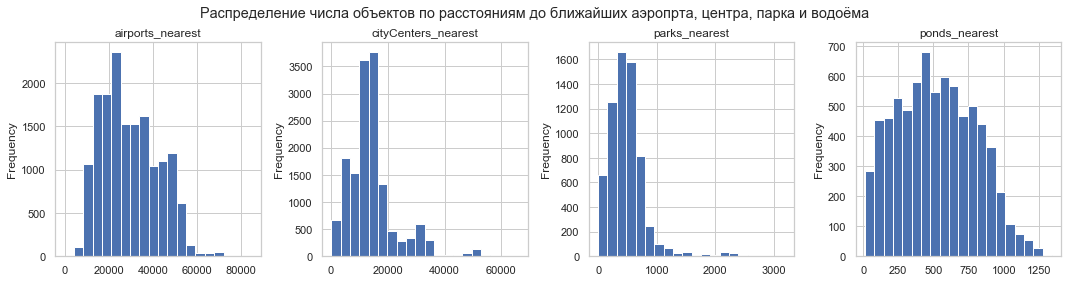

In [123]:
plt.figure(figsize=(15 , 4))
i = 1
for column in ["airports_nearest", "cityCenters_nearest", "parks_nearest", "ponds_nearest"]:
    plt.subplot(1,4,i)
    i += 1
    flat_data_good[column].plot(kind="hist", bins=20)
    plt.title(column)

plt.suptitle("Распределение числа объектов по расстояниям до ближайших аэропрта, центра, парка и водоёма")
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()
#сброшу счётчик
i=0

Можно округлить расстояние до аэропорта, там возле нуля почти ничего нет. Округлим до километров и сотен метров. С другими данными так поступать пока не будем, так как много объектов в районе нулей.

In [124]:
flat_data_good["airports_nearest"] = (flat_data_good["airports_nearest"] / 1000).round(1)

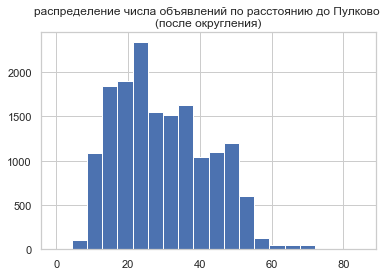

In [125]:
flat_data_good.loc[:, "airports_nearest"].hist(bins=20)
plt.title("распределение числа объявлений по расстоянию до Пулково \n(после округления)")
plt.show()

Вроде бы, ничего не испортили, вид гистограммы не изменился. А читать таблицу легче. 

Высоту потолков обычно принято указывать с точностью 0.1м. Округлим. 

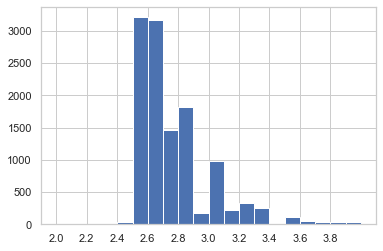

In [126]:
flat_data_good["ceiling_height"] = flat_data_good["ceiling_height"].round(1)
flat_data_good.loc[:, "ceiling_height"].hist(bins=20, range=(2,4))
plt.xticks(np.arange(2,4,0.2))
plt.show()

### 2.3.2 Добавление некоторых категорий данных

locality_type_new можно сменить тип на категориальный, это снизит объём памяти, который занимает таблица. К тому же, категории уже созданы при обработке скрытых дублей.

In [127]:
flat_data_good["locality_type_new"] = flat_data_good["locality_type_new"].astype("category")

Также можно ввести категории для этажей: "первый", "последний", "другой".

In [128]:
#всему столбцу присваиваем значение "другой"
flat_data_good.loc[:, "floor_categ"] = "другой"

#в строках, для которых этаж=1 переприсваиваем на "первый"
flat_data_good.loc[flat_data_good.loc[:, "floor"] == 1, "floor_categ"] = "первый"

#в строках, где этаж - всего этажей =0 переприсваиваем на "последний"
flat_data_good.loc[(flat_data_good.loc[:, "floor"] - 
                    flat_data_good.loc[:, "floors_total"]) == 0, "floor_categ"] = "последний"

flat_data_good.loc[:, "floor_categ"] = flat_data_good.loc[:, "floor_categ"].astype("category")

Проверим, всё ли прошло успешно:

In [129]:
flat_data_good.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000       108.0           2019-03-07      3   
1             7        3350        40.4           2018-12-04      1   
3             0       64900       159.0           2015-07-24      3   
4             2       10000       100.0           2018-06-19      2   
5            10        2890        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0             2.7            16         51.0      8          NaN   False   
1             NaN            11         18.6      1          NaN   False   
3             NaN            14          NaN      9          NaN   False   
4             3.0            14         32.0     13          NaN   False   
5             NaN            12         14.4      5          NaN   False   

   open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
0      False          25.0        0              18.9              16028.0   
1      False          11.0        2              12.8              18603.0   
3      False           NaN        0              28.1               6800.0   
4      False          41.0        0              31.9               8098.0   
5      False           9.1        0              28.1                  NaN   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0               1.0          482.0               2.0          755.0   
1               0.0            NaN               0.0            NaN   
3               2.0           84.0               3.0          234.0   
4               2.0          112.0               1.0           48.0   
5               NaN            NaN               NaN            NaN   

   days_exposition locality_name_new        locality_type_new  \
0             -100   Санкт-Петербург                    город   
1               81            Шушары                  поселок   
3              424   Санкт-Петербург                    город   
4              121   Санкт-Петербург                    город   
5               55           Янино-1  поселок городского типа   

             locality_fullname_new  price_per_square_meter  start_year  \
0            город Санкт-Петербург                     120        2019   
1                   поселок Шушары                      83        2018   
3            город Санкт-Петербург                     408        2015   
4            город Санкт-Петербург                     100        2018   
5  поселок городского типа Янино-1                      95        2018   

   start_month start_month_year  observation_time  total_minus_living  \
0            3          2019-03                 2                57.0   
1           12          2018-12                 5                21.8   
3            7          2015-07                46                 NaN   
4            6          2018-06                11                68.0   
5            9          2018-09                 8                16.0   

   check_area floor_categ  
0    2.280000      другой  
1    1.981818      первый  
3         NaN      другой  
4    1.658537      другой  
5    1.758242      другой

In [130]:
flat_data_good.loc[flat_data_good.loc[:, "floor"] == 1, :].head()

total_images  last_price  total_area first_day_exposition  rooms  \
1              7        3350        40.4           2018-12-04      1   
14             1        4400        36.0           2016-06-23      1   
16            11        6700        82.0           2017-11-23      3   
24             8        6500        97.2           2015-10-31      2   
28             8        4170        44.0           2017-12-13      1   

    ceiling_height  floors_total  living_area  floor is_apartment  studio  \
1              NaN            11         18.6      1          NaN   False   
14             NaN             6         17.0      1          NaN   False   
16             3.0             5         55.6      1          NaN   False   
24             NaN             3         46.5      1          NaN   False   
28             2.9             6         20.8      1          NaN   False   

    open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
1       False          11.0        2              12.8              18603.0   
14      False           8.0        0              20.8              30759.0   
16      False           9.0        0              22.1              10698.0   
24      False          19.6        0              20.1               2336.0   
28      False          11.7        1              18.6              30710.0   

    parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
1                0.0            NaN               0.0            NaN   
14               0.0            NaN               1.0           96.0   
16               3.0          420.0               0.0            NaN   
24               3.0          411.0               3.0          124.0   
28               0.0            NaN               1.0          118.0   

    days_exposition locality_name_new locality_type_new  \
1                81            Шушары           поселок   
14              203            Пушкин             город   
16              397   Санкт-Петербург             город   
24              265   Санкт-Петербург             город   
28               74            Пушкин             город   

    locality_fullname_new  price_per_square_meter  start_year  start_month  \
1          поселок Шушары                      83        2018           12   
14           город Пушкин                     122        2016            6   
16  город Санкт-Петербург                      82        2017           11   
24  город Санкт-Петербург                      67        2015           10   
28           город Пушкин                      95        2017           12   

   start_month_year  observation_time  total_minus_living  check_area  \
1           2018-12                 5                21.8    1.981818   
14          2016-06                35                19.0    2.375000   
16          2017-11                18                26.4    2.933333   
24          2015-10                43                50.7    2.586735   
28          2017-12                17                23.2    1.982906   

   floor_categ  
1       первый  
14      первый  
16      первый  
24      первый  
28      первый

In [131]:
flat_data_good.loc[(flat_data_good.loc[:, "floor"] - flat_data_good.loc[:, "floors_total"]) == 0, :].head()

total_images  last_price  total_area first_day_exposition  rooms  \
12            10        3890        54.0           2016-06-30      2   
13            20        3550        42.8           2017-07-01      2   
36            13        3790        45.0           2017-01-25      2   
59            15        6300        46.5           2017-03-06      1   
64            13        3100        44.3           2017-11-07      2   

    ceiling_height  floors_total  living_area  floor is_apartment  studio  \
12             NaN             5         30.0      5          NaN   False   
13             2.6             5         27.0      5          NaN   False   
36             NaN             9         27.0      9        False   False   
59             NaN            13          NaN     13          NaN   False   
64             2.5             5         29.0      5          NaN   False   

    open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
12      False           9.0        0               NaN                  NaN   
13      False           5.2        1              37.9              33058.0   
36      False           6.3        2              49.6              16461.0   
59      False           NaN        0              11.1              14501.0   
64      False           5.3        0               NaN                  NaN   

    parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
12               NaN            NaN               NaN            NaN   
13               1.0          294.0               3.0          298.0   
36               1.0          459.0               0.0            NaN   
59               0.0            NaN               0.0            NaN   
64               NaN            NaN               NaN            NaN   

    days_exposition locality_name_new locality_type_new  \
12               90         Сертолово             город   
13              366          Петергоф             город   
36              139   Санкт-Петербург             город   
59              336   Санкт-Петербург             город   
64              143           Гатчина             город   

    locality_fullname_new  price_per_square_meter  start_year  start_month  \
12        город Сертолово                      72        2016            6   
13         город Петергоф                      83        2017            7   
36  город Санкт-Петербург                      84        2017            1   
59  город Санкт-Петербург                     135        2017            3   
64          город Гатчина                      70        2017           11   

   start_month_year  observation_time  total_minus_living  check_area  \
12          2016-06                35                24.0    2.666667   
13          2017-07                22                15.8    3.038462   
36          2017-01                28                18.0    2.857143   
59          2017-03                26                 NaN         NaN   
64          2017-11                18                15.3    2.886792   

   floor_categ  
12   последний  
13   последний  
36   последний  
59   последний  
64   последний

<h2 style="color:DodgerBlue"> Вывод по дообработке данных</h2>

***
- Типы данных в столбцах, содержащих натуральные числа, заменены на integer с downcast="integer" для снижения потребления памяти. Столбцы с NaN оставлены как есть, так как с NaN замена типа не работает.

    
- Расстояния до ближайшего аэропорта переведены в километры и округлены до сотен метров (десятых долей км)

    
- Категоризованы типы населённых пунктов (5 категорий: "город", "деревня", "поселок", "поселок городского типа", "село")
    
    
- Категоризован этаж, на котором расположена недвижимость (3 категории: "первый", "последний", "другой")
***

<h1 style="color:SteelBlue"> 3. Подготовка таблицы для исследовательского анализа </h1>

<h2 style="color:DodgerBlue"> 3.1 Расчёт недостающих показателей </h2>

**Ранее в таблицу добавлены:**

- цена квадратного метра общей площади (общей, т.к. не для всех записей есть данные по жилой)
- тип населённого пункта ("город", "деревня", "поселок", "поселок городского типа", "село")
- этаж расположения недвижимости ("первый", "последний", "другой")
- месяц и год публикации объявления

**В анализе, кроме присутствующих, могут пригодится:**

- отношение жилой площади к общей
- отношение площади кухни к общей площади
- день недели публикации объявления

Добавим параметры:

In [132]:
flat_data_good["living_div_total_area"] = flat_data_good["living_area"] / flat_data_good["total_area"]

In [133]:
flat_data_good["kitchen_div_total_area"] = flat_data_good["kitchen_area"] / flat_data_good["total_area"]

In [134]:
flat_data_good["start_weekday"] = pd.DatetimeIndex(flat_data_good["first_day_exposition"]).weekday

In [135]:
flat_data_good.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000       108.0           2019-03-07      3   
1             7        3350        40.4           2018-12-04      1   
3             0       64900       159.0           2015-07-24      3   
4             2       10000       100.0           2018-06-19      2   
5            10        2890        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0             2.7            16         51.0      8          NaN   False   
1             NaN            11         18.6      1          NaN   False   
3             NaN            14          NaN      9          NaN   False   
4             3.0            14         32.0     13          NaN   False   
5             NaN            12         14.4      5          NaN   False   

   open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
0      False          25.0        0              18.9              16028.0   
1      False          11.0        2              12.8              18603.0   
3      False           NaN        0              28.1               6800.0   
4      False          41.0        0              31.9               8098.0   
5      False           9.1        0              28.1                  NaN   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0               1.0          482.0               2.0          755.0   
1               0.0            NaN               0.0            NaN   
3               2.0           84.0               3.0          234.0   
4               2.0          112.0               1.0           48.0   
5               NaN            NaN               NaN            NaN   

   days_exposition locality_name_new        locality_type_new  \
0             -100   Санкт-Петербург                    город   
1               81            Шушары                  поселок   
3              424   Санкт-Петербург                    город   
4              121   Санкт-Петербург                    город   
5               55           Янино-1  поселок городского типа   

             locality_fullname_new  price_per_square_meter  start_year  \
0            город Санкт-Петербург                     120        2019   
1                   поселок Шушары                      83        2018   
3            город Санкт-Петербург                     408        2015   
4            город Санкт-Петербург                     100        2018   
5  поселок городского типа Янино-1                      95        2018   

   start_month start_month_year  observation_time  total_minus_living  \
0            3          2019-03                 2                57.0   
1           12          2018-12                 5                21.8   
3            7          2015-07                46                 NaN   
4            6          2018-06                11                68.0   
5            9          2018-09                 8                16.0   

   check_area floor_categ  living_div_total_area  kitchen_div_total_area  \
0    2.280000      другой               0.472222                0.231481   
1    1.981818      первый               0.460396                0.272277   
3         NaN      другой                    NaN                     NaN   
4    1.658537      другой               0.320000                0.410000   
5    1.758242      другой               0.473684                0.299342   

   start_weekday  
0              3  
1              1  
3              4  
4              1  
5              0

<h2 style="color:DodgerBlue"> 3.2 Окончательная очистка от выбросов и сборка таблицы для анализа</h2>

### 3.2.1 Выпадающие значения

In [136]:
numeric_columns = flat_data_good.quantile(0).index.tolist()
quantiles_list = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]
flat_data_good[numeric_columns].quantile(quantiles_list)

total_images  last_price  total_area  rooms  ceiling_height  \
0.00           0.0       430.0      12.000    0.0             2.0   
0.01           0.0      1000.0      25.949    1.0             2.5   
0.10           2.0      2450.0      33.000    1.0             2.5   
0.25           6.0      3400.0      40.000    1.0             2.5   
0.50          10.0      4600.0      52.000    2.0             2.6   
0.75          14.0      6650.0      68.400    3.0             2.8   
0.90          19.0     10500.0      90.820    3.0             3.0   
0.99          20.0     33000.0     188.457    5.0             3.7   
1.00          50.0    763000.0     900.000   19.0            20.0   

      floors_total  living_area  floor  studio  open_plan  kitchen_area  \
0.00           1.0         2.00    1.0     0.0        0.0          1.30   
0.01           2.0        13.00    1.0     0.0        0.0          5.00   
0.10           5.0        16.30    1.0     0.0        0.0          6.00   
0.25           5.0        18.50    2.0     0.0        0.0          7.00   
0.50           9.0        30.00    4.0     0.0        0.0          9.00   
0.75          16.0        42.00    8.0     0.0        0.0         11.85   
0.90          22.0        53.65   13.0     0.0        0.0         15.20   
0.99          26.0       112.39   23.0     0.0        0.0         33.90   
1.00          60.0       409.70   32.0     1.0        1.0        112.00   

      balcony  airports_nearest  cityCenters_nearest  parks_around3000  \
0.00      0.0               0.0               181.00               0.0   
0.01      0.0               9.6              1483.00               0.0   
0.10      0.0              13.7              4870.00               0.0   
0.25      0.0              19.0              9592.25               0.0   
0.50      0.0              27.5             13239.00               0.0   
0.75      1.0              38.8             16424.75               1.0   
0.90      2.0              49.7             26497.50               2.0   
0.99      5.0              58.4             50023.00               3.0   
1.00      5.0              84.9             65952.00               3.0   

      parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0.00            1.0               0.0          13.00           -100.0   
0.01           23.0               0.0          43.52           -100.0   
0.10          159.5               0.0         148.00           -100.0   
0.25          288.0               0.0         296.00             32.0   
0.50          455.0               0.0         509.00             76.0   
0.75          613.0               1.0         734.00            175.0   
0.90          762.5               2.0         898.00            317.0   
0.99         2102.0               3.0        1157.48            481.0   
1.00         3190.0               3.0        1344.00            510.0   

      price_per_square_meter  start_year  start_month  observation_time  \
0.00                     8.0      2015.0          1.0               0.0   
0.01                    22.0      2015.0          1.0               1.0   
0.10                    55.0      2016.0          2.0               3.0   
0.25                    76.0      2017.0          3.0               8.0   
0.50                    95.0      2018.0          6.0              16.0   
0.75                   113.0      2018.0         10.0              22.0   
0.90                   137.0      2019.0         11.0              35.0   
0.99                   250.0      2019.0         12.0              43.0   
1.00                  1908.0      2019.0         12.0              51.0   

      total_minus_living  check_area  living_div_total_area  \
0.00                0.00    1.200000               0.021583   
0.01                8.10    1.405776               0.307712   
0.10               14.00    1.857143               0.426166   
0.25               17.00    2.100000               0.493872   
0.50               22.00  

Выпадающих значений достаточно. У части объявлений нет фото. Есть объявления с жилой площадью 2, расстоянием до парка 1 метр, с нулевой разницей общей и жилой площади.

В данных есть явно экстремальные значения. Наиболее проблемны - выбросы в большую сторону, т.к. там мало данных. Возможно, они вполне реальны, например огромные площади элитных квартир или больших частных домов. Возможно, это опечатки. Но выделить все опечатки среди 20000 записей не удастся. Не входит в наши цели и изучение экстремальных значений. Поэтому очистим от них данные.

In [137]:
extrem_params_list = ['last_price', 'price_per_square_meter', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area']
extrem_quantile = 0.995

Взяв уровни 99% от 'last_price', 'price_per_square_meter', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area' получим:

In [138]:
flat_data_good[extrem_params_list].quantile([1, 0.99, 0.90, 0.5, 0.10, 0.01, 0]).round(2)

last_price  price_per_square_meter  total_area  ceiling_height  \
1.00    763000.0                  1908.0      900.00            20.0   
0.99     33000.0                   250.0      188.46             3.7   
0.90     10500.0                   137.0       90.82             3.0   
0.50      4600.0                    95.0       52.00             2.6   
0.10      2450.0                    55.0       33.00             2.5   
0.01      1000.0                    22.0       25.95             2.5   
0.00       430.0                     8.0       12.00             2.0   

      living_area  kitchen_area  
1.00       409.70         112.0  
0.99       112.39          33.9  
0.90        53.65          15.2  
0.50        30.00           9.0  
0.10        16.30           6.0  
0.01        13.00           5.0  
0.00         2.00           1.3

2.5-15 кратные разницы значений в пределах 0.5%. Вероятно, элитные квартиры, которых единицы. В наши задачи не входит изучение экстремальных значений, поэтому очистим от них данные.

In [139]:
display(f'размер датафрейма до очистки: {len(flat_data_good)}')

'размер датафрейма до очистки: 19650'

In [140]:
for param in extrem_params_list:
    param_limit = flat_data_good[param].quantile(extrem_quantile)
    flat_data_good = flat_data_good.loc[flat_data_good.loc[:, param].isna() | (flat_data_good.loc[:, param] <= param_limit), :]

In [141]:
display(f'размер датафрейма после очистки: {len(flat_data_good)}')

'размер датафрейма после очистки: 19135'

Касательно выбросов в минимуме, тут тоже есть о чём подумать. Минимальная жилая площадь определена Жилищным кодексом РФ и не может быть менее 6 кв. метров. Так что всё, что меньше, можно очистить. Это ошибки/опечатки и их мало.

In [142]:

flat_data_good = flat_data_good.loc[flat_data_good.loc[:, 'living_area'].isna() | (flat_data_good.loc[:, 'living_area'] >= 6), :]

### Итоги очистки выбросов:

In [143]:
flat_data_good[extrem_params_list].agg(['max','mean','median', 'min', 'count']).round(1)

last_price  price_per_square_meter  total_area  ceiling_height  \
max        45900.0                   266.0       204.0             3.9   
mean        5479.6                    95.1        56.3             2.7   
median      4500.0                    94.0        51.0             2.6   
min          430.0                     8.0        12.0             2.0   
count      19130.0                 19130.0     19130.0         11612.0   

        living_area  kitchen_area  
max           106.5          36.0  
mean           32.1           9.9  
median         30.0           9.0  
min             6.0           1.3  
count       17542.0       17231.0

In [144]:
display(f'размер датафрейма после очистки: {len(flat_data_good)}')

'размер датафрейма после очистки: 19130'

Максимумы снизились в несколько раз. При этом медианы почти не пострадали. Средние близки к медианам. Всё проверено и похоже на правду. Около 550 выбросов удалено.

### 3.2.2 Сборка таблицы для исследовательского анализа. Исключение столбцов

В таблице есть ряд столбцов, которые для аналза не пригодятся. 

In [145]:
flat_data_good.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000       108.0           2019-03-07      3   
1             7        3350        40.4           2018-12-04      1   
5            10        2890        30.4           2018-09-10      1   
6             6        3700        37.3           2017-11-02      1   
7             5        7915        71.6           2019-04-18      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0             2.7            16         51.0      8          NaN   False   
1             NaN            11         18.6      1          NaN   False   
5             NaN            12         14.4      5          NaN   False   
6             NaN            26         10.6      6          NaN   False   
7             NaN            24          NaN     22          NaN   False   

   open_plan  kitchen_area  balcony  airports_nearest  cityCenters_nearest  \
0      False          25.0        0              18.9              16028.0   
1      False          11.0        2              12.8              18603.0   
5      False           9.1        0              28.1                  NaN   
6      False          14.4        1              53.0              19143.0   
7      False          18.9        2              24.0              11634.0   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0               1.0          482.0               2.0          755.0   
1               0.0            NaN               0.0            NaN   
5               NaN            NaN               NaN            NaN   
6               0.0            NaN               0.0            NaN   
7               0.0            NaN               0.0            NaN   

   days_exposition locality_name_new        locality_type_new  \
0             -100   Санкт-Петербург                    город   
1               81            Шушары                  поселок   
5               55           Янино-1  поселок городского типа   
6              155         Парголово                  поселок   
7             -100   Санкт-Петербург                    город   

             locality_fullname_new  price_per_square_meter  start_year  \
0            город Санкт-Петербург                     120        2019   
1                   поселок Шушары                      83        2018   
5  поселок городского типа Янино-1                      95        2018   
6                поселок Парголово                      99        2017   
7            город Санкт-Петербург                     111        2019   

   start_month start_month_year  observation_time  total_minus_living  \
0            3          2019-03                 2                57.0   
1           12          2018-12                 5                21.8   
5            9          2018-09                 8                16.0   
6           11          2017-11                18                26.7   
7            4          2019-04                 1                 NaN   

   check_area floor_categ  living_div_total_area  kitchen_div_total_area  \
0    2.280000      другой               0.472222                0.231481   
1    1.981818      первый               0.460396                0.272277   
5    1.758242      другой               0.473684                0.299342   
6    1.854167      другой               0.284182                0.386059   
7         NaN      другой                    NaN                0.263966   

   start_weekday  
0              3  
1              1  
5              0  
6              3  
7              3

В таблице есть studio и open_plan, их не оценивали, посмотрим:

In [146]:
flat_data_good.studio.sum()

119

In [147]:
flat_data_good.open_plan.sum()

52

Мало, чтобы что-то утверждать о влиянии на стоимость. Тем не менее, посмотрим гистограммы, чтобы иметь представление о ситуации.

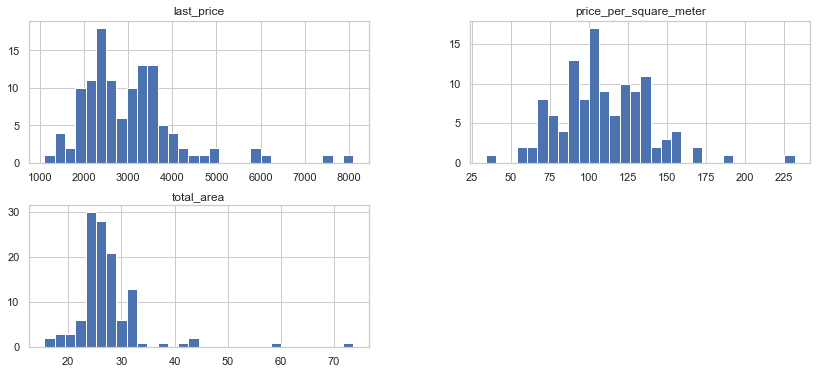

In [148]:
flat_data_good.loc[flat_data_good.loc[:, 'studio'], ['price_per_square_meter', 'last_price', 'total_area']].hist(figsize=(14,6), bins=30)
plt.show()

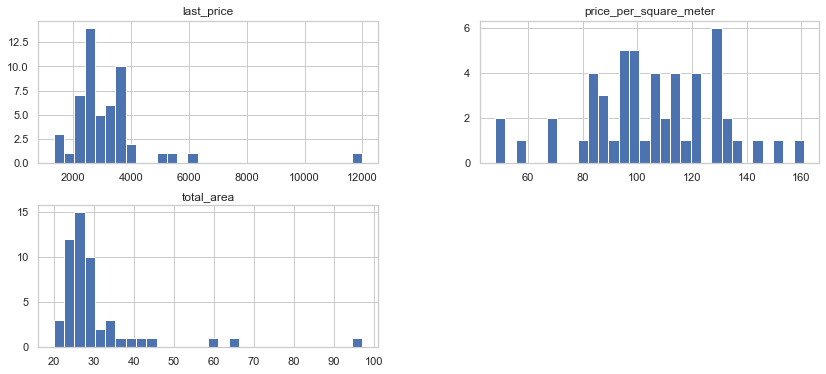

In [149]:
flat_data_good.loc[flat_data_good.loc[:, 'open_plan'], ['price_per_square_meter', 'last_price', 'total_area']].hist(figsize=(14,6), bins=30)
plt.show()

И студии и свободные планировки в основном небольшие, 20-30 метров. Но есть и большие дорогие экземпляры. Цена квадратного метра посторяет форму общей гистограммы (для всех квартир). Гистограмма площадей, похоже, тоже имеет тенденция к хвосту справа. Можно эти столбцы исключить, т.к. для поиска параметров, влияющих на стоимость они не подходят. Слишком мало данных.

Таким образом, не понадобятся в итоговой таблице: is apartment, в котором почти нет подтверждённых апартаментов, open_plan и studio, которых 55 и 113 (по этим цифрам только уверенно можно сказать, что основной пул квартир на рынке - не студии и не свободные планировки) total_minus_living, который использовался для проверки check_area (это вся нежилая площадь по отношению только к площади кухни), "locality_fullname_new".


Прочие нужно перегруппировать, чтобы было удобно работать с таблицей.

In [150]:
flat_data_good.drop(["start_month_year", "is_apartment", "locality_fullname_new", 
                     "total_minus_living", "check_area", "studio", "open_plan"], 
                    axis='columns', inplace=True)

In [151]:
flat_data_good.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20       13000       108.0           2019-03-07      3   
1             7        3350        40.4           2018-12-04      1   
5            10        2890        30.4           2018-09-10      1   
6             6        3700        37.3           2017-11-02      1   
7             5        7915        71.6           2019-04-18      2   

   ceiling_height  floors_total  living_area  floor  kitchen_area  balcony  \
0             2.7            16         51.0      8          25.0        0   
1             NaN            11         18.6      1          11.0        2   
5             NaN            12         14.4      5           9.1        0   
6             NaN            26         10.6      6          14.4        1   
7             NaN            24          NaN     22          18.9        2   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0              18.9              16028.0               1.0          482.0   
1              12.8              18603.0               0.0            NaN   
5              28.1                  NaN               NaN            NaN   
6              53.0              19143.0               0.0            NaN   
7              24.0              11634.0               0.0            NaN   

   ponds_around3000  ponds_nearest  days_exposition locality_name_new  \
0               2.0          755.0             -100   Санкт-Петербург   
1               0.0            NaN               81            Шушары   
5               NaN            NaN               55           Янино-1   
6               0.0            NaN              155         Парголово   
7               0.0            NaN             -100   Санкт-Петербург   

         locality_type_new  price_per_square_meter  start_year  start_month  \
0                    город                     120        2019            3   
1                  поселок                      83        2018           12   
5  поселок городского типа                      95        2018            9   
6                  поселок                      99        2017           11   
7                    город                     111        2019            4   

   observation_time floor_categ  living_div_total_area  \
0                 2      другой               0.472222   
1                 5      первый               0.460396   
5                 8      другой               0.473684   
6                18      другой               0.284182   
7                 1      другой                    NaN   

   kitchen_div_total_area  start_weekday  
0                0.231481              3  
1                0.272277              1  
5                0.299342              0  
6                0.386059              3  
7                0.263966              3

In [152]:
fdg_columns_list_old = flat_data_good.columns.tolist()

fdg_columns_list_new = ['start_weekday','start_month', 'start_year', 
                        'first_day_exposition', 'days_exposition', 'observation_time',
                        'total_images',
                        'last_price',
                        'total_area', 'living_area', 'kitchen_area',
                        'price_per_square_meter', 'living_div_total_area', 'kitchen_div_total_area',
                        'floor', 'floors_total', 'floor_categ',
                        'rooms', 'balcony', 'ceiling_height',
                        'cityCenters_nearest',
                        'airports_nearest',
                        'parks_around3000', 'parks_nearest',
                        'ponds_around3000', 'ponds_nearest',
                        'locality_name_new', 'locality_type_new'
                       ]

In [153]:
flat_data_good = flat_data_good[fdg_columns_list_new]

Понадобится флаг для выделения столицы. Создадим столбец:

In [154]:
flat_data_good['SPb_flag'] = flat_data_good['locality_name_new'].where(flat_data_good['locality_name_new'] == 'Санкт-Петербург', 'иное')

In [155]:
flat_data_good.head()

start_weekday  start_month  start_year first_day_exposition  \
0              3            3        2019           2019-03-07   
1              1           12        2018           2018-12-04   
5              0            9        2018           2018-09-10   
6              3           11        2017           2017-11-02   
7              3            4        2019           2019-04-18   

   days_exposition  observation_time  total_images  last_price  total_area  \
0             -100                 2            20       13000       108.0   
1               81                 5             7        3350        40.4   
5               55                 8            10        2890        30.4   
6              155                18             6        3700        37.3   
7             -100                 1             5        7915        71.6   

   living_area  kitchen_area  price_per_square_meter  living_div_total_area  \
0         51.0          25.0                     120               0.472222   
1         18.6          11.0                      83               0.460396   
5         14.4           9.1                      95               0.473684   
6         10.6          14.4                      99               0.284182   
7          NaN          18.9                     111                    NaN   

   kitchen_div_total_area  floor  floors_total floor_categ  rooms  balcony  \
0                0.231481      8            16      другой      3        0   
1                0.272277      1            11      первый      1        2   
5                0.299342      5            12      другой      1        0   
6                0.386059      6            26      другой      1        1   
7                0.263966     22            24      другой      2        2   

   ceiling_height  cityCenters_nearest  airports_nearest  parks_around3000  \
0             2.7              16028.0              18.9               1.0   
1             NaN              18603.0              12.8               0.0   
5             NaN                  NaN              28.1               NaN   
6             NaN              19143.0              53.0               0.0   
7             NaN              11634.0              24.0               0.0   

   parks_nearest  ponds_around3000  ponds_nearest locality_name_new  \
0          482.0               2.0          755.0   Санкт-Петербург   
1            NaN               0.0            NaN            Шушары   
5            NaN               NaN            NaN           Янино-1   
6            NaN               0.0            NaN         Парголово   
7            NaN               0.0            NaN   Санкт-Петербург   

         locality_type_new         SPb_flag  
0                    город  Санкт-Петербург  
1                  поселок             иное  
5  поселок городского типа             иное  
6                  поселок             иное  
7                    город  Санкт-Петербург

In [156]:
flat_data_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19130 entries, 0 to 23696
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   start_weekday           19130 non-null  int64         
 1   start_month             19130 non-null  int64         
 2   start_year              19130 non-null  int64         
 3   first_day_exposition    19130 non-null  datetime64[ns]
 4   days_exposition         19130 non-null  int16         
 5   observation_time        19130 non-null  int64         
 6   total_images            19130 non-null  int8          
 7   last_price              19130 non-null  int32         
 8   total_area              19130 non-null  float64       
 9   living_area             17542 non-null  float64       
 10  kitchen_area            17231 non-null  float64       
 11  price_per_square_meter  19130 non-null  int16         
 12  living_div_total_area   17542 non-null  float6

19102 записей, с которыми можно работать. Около 80% из числа начальных записей. Основные потери связаны с наличием аномально быстрых и слишком долгих продаж. Были также ошибки и опечатки в данных и экстремальные значения.

### 3.2.3 Гистограммы очищенных данных

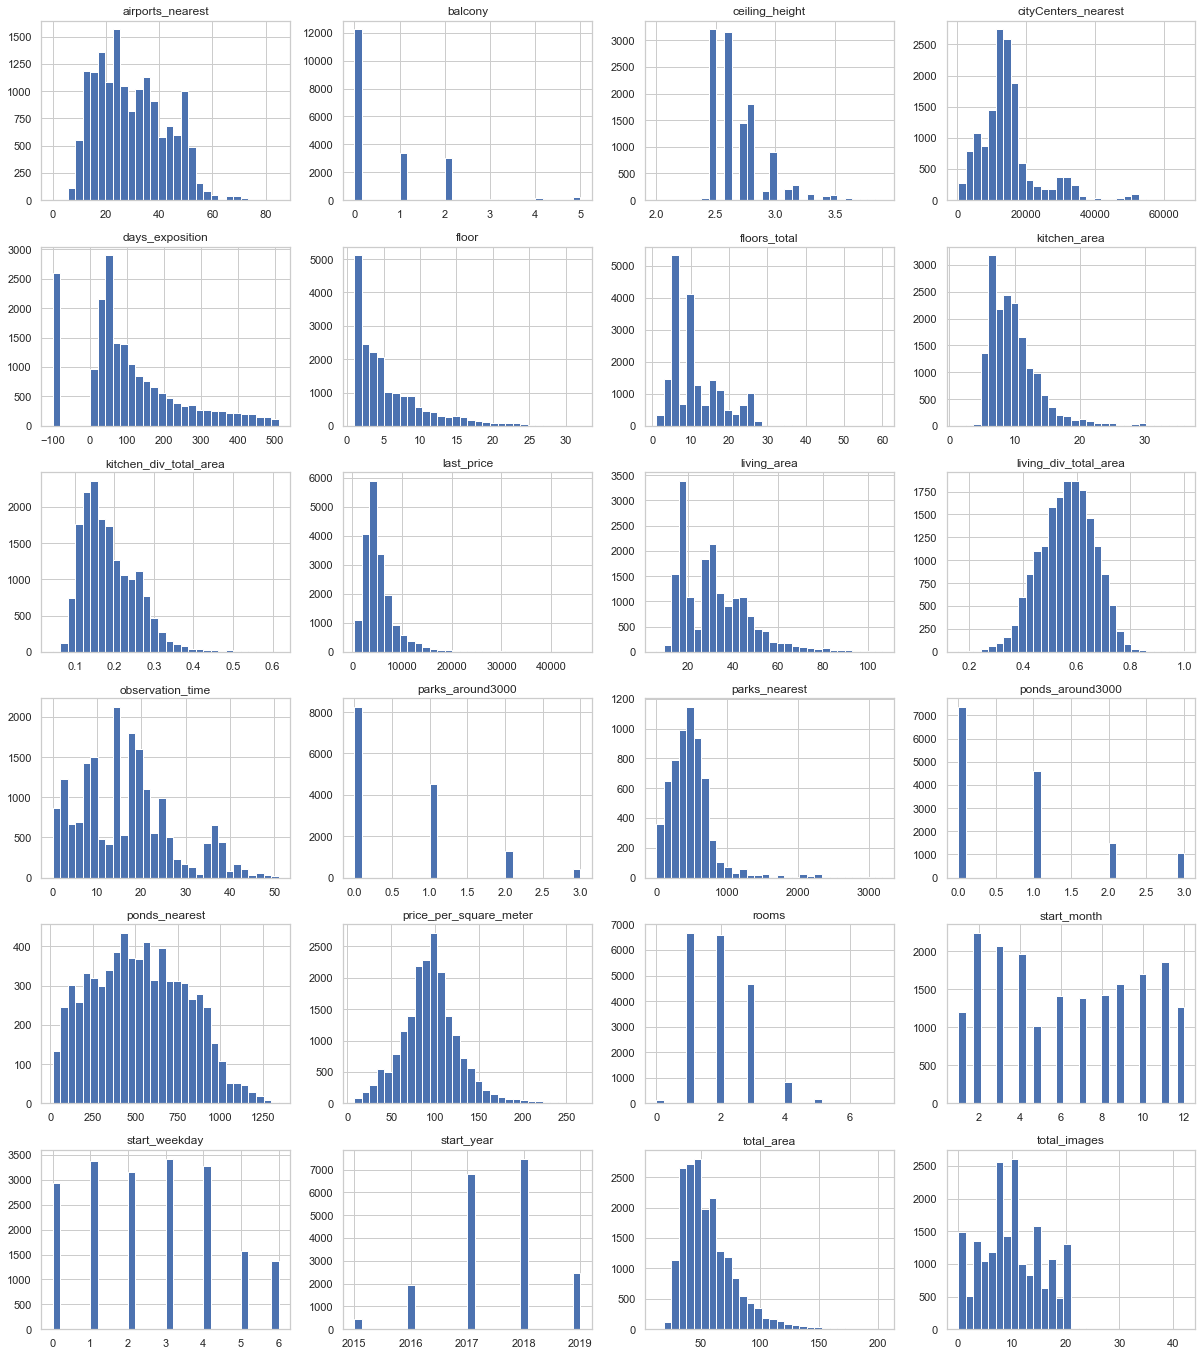

In [157]:
flat_data_good.hist(figsize=(17, 20), bins = 30, layout=(6,4))
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Часть гистограмм уже изучили ранее. Гистограмма продолжительности продаж также разобрана выше. Какие ещё интересные тенденции можно заметить:

1. Максимум объявлений о продаже недвижимости пришелся на 2018 год. Тем не менее, сложно отделить динамику рынка от динамики развития продающей платформы. В 2015-16гг платформа была менее популярна, это разобрано в разделе удаления пропусков. Низкий уровень 2019 связан с тем, что на момент выгрузки базы прошло  только 4 полных месяца 2019 года. Судя по уровню на эти 4 месяца, 2019 год аналогичен 2017 и 2018.

2. Видны периодические колебания в числе открытых объявлений для разных дней недели и месяцев года. На выходные приходится в 2 раза меньше объявлений. Видно, что пики стартов продаж приходятся на февраль и ноябрь, причём в декабре, январе и мае - самый сильный спад (спад мая может объясняться кризисом 2018, когда резко вырас доллар)

3. Гистограммы отношения жилой площади к общей и кухни к общей площади зеркально похожи. Так и должно быть, это показывает корректность данных: чем больше жилая площадь относительно общей, тем меньше площадь нежилых помещений, в том числе - кухни. Видно, что в определённый момент прибавка жилой полщади происходит за счёт кухни. Одна гистограмма гладкая, другая - с провалом.

4. Большая часть жилья - вдали от парков. Те, кому повезло, могут дойти до парка за 10 минут или быстрее: расстояние до ближайших парков в основном в пределах 1000 метров. Но есть и хвост распределения, вплоть до 3км.

5. Ситуация с водоёмами - как с парками. В основном вблизи продающегося жилья их нет. Однако, если есть, то в пределах 1250 метров и никаких хвостов. Чаще водоём ближе к жилью, чем дальше: распределение смещено влево.

6. Больше всего на рынке одно- и двухкомнатных квартир. Трёхкомнатных примерно на треть меньше, а большее число комнат - уже редкость.

7. Гистограмма расстояний до центра демонстрирует один основной пик и два соседних. Видимо, центр, спальные районы и пригород, соответственно.

8. На гистограмме расстояний до аропорта, аналогично гистограмме расстояний до центра города, просматривается, хотя и менее выраженно, три пика. Видимо, объяснение аналогично центру.

9. Площади квартир: на гистограммах жилой и общей площади справа "тяжелый хвост". Есть два пика и там и там. Площадь кухни тоже имеет пики и провал. Похоже, пики жилой площади и провалы кухонной компенсируют друг друга. На гистограмме общей площади они в зоне немного больших значений и менее выражены. Видимо, стандартные планировки небольших квартир. 

10. По гистограмме observation_time видно, что удалось сохранить довольно много записей от 2019 года и что число записей на площадке по месяцам непостоянно


Гистограммы выглядят правдоподобно, значит, данные обработаны в верном ключе.

<h1 style="color:DodgerBlue"> Вывод по подготовке таблицы для анализа </h1>

***
**В рамках этапа выполнена доочистка данных:**


- обработаны экстремальные значения (ещё около 0.5% потерь)
    

**Досчитали ряд параметров и добавили в таблицу. Часть старых и вспомогательных столбцов удалили. Итоговая таблица содержит:**


- 'start_weekday' - день недели старта объявления
- 'start_month' - месяц старта объявления
- 'start_year' - год старта объявления
- 'first_day_exposition' - полная дата старта объявления 
- 'days_exposition' - сколько дней было размещено объявление (от публикации до снятия; срок продажи)
- 'observation_time' - время наблюдений за записью в месяцах
- 'total_images' - число фотографий квартиры в объявлении
- 'last_price' - цена на момент снятия с публикации (тыс. руб.)
- 'total_area' - площадь квартиры в квадратных метрах (м²)
- 'living_area' - жилая площадь в квадратных метрах(м²)
- 'kitchen_area' - площадь кухни в квадратных метрах (м²)
- 'price_per_square_meter' - цена квадратного метра общей площади (тыс. руб.)
- 'living_div_total_area' - отношение жилой и общей площади
- 'kitchen_div_total_area' - отношение площади кухни к общей площади
- 'floor' - этаж расположения недвижимости
- 'floors_total' - всего этажей в доме
- 'floor_categ' - категория этажа (первый, последний, другой)
- 'rooms' - число комнат
- 'balcony' - число балконов
- 'ceiling_height' - высота потолка
- 'studio' - квартира-студия (булев тип)
- 'open_plan' - свободная планировка (булев тип)
- 'cityCenters_nearest' - расстояние до центра города (м)
- 'airports_nearest' - расстояние до ближайшего аэропорта в километрах (км)
- 'parks_around3000' - число парков в радиусе 3 км
- 'parks_nearest' - расстояние до ближайшего парка (м)
- 'ponds_around3000' - число водоёмов в радиусе 3 км
- 'ponds_nearest' -  расстояние до ближайшего водоёма (м)
- 'locality_name_new' - название населённого пункта (без указания типа)
- 'locality_type_new' - тип населённого пункта (город, поселок, село, деревня, поселок городского типа)


**Построили и проанализировали гистограммы для всех параметров таблицы** Гистограммы соответствуют ожиданиям, логично объяняются. Данные обработаны корректно и подходят для исследовательского анализа.
***

<h1 style="color:SteelBlue"> 4. Исследовательский анализ данных</h1>

**Ранее мы выяснили, что:**

В среднем продажа квартиры занимает около 140 дней (4.5 месяца). В 80% случаев сделка совершается в интервале примерно от 1 до 11 месяцев. Половина продаж приходится на первые 3 месяца, а остальные растягиваются во времени почти на год.

Внешний вид гисторамм даёт основания полагать, что данные обработаны корректно. Осталось разобраться в сути вопроса: какие параметры определяют рыночную стоимость недвижимости?

<h2 style="color:DodgerBlue">4.1 Общий кросс-корреляционный анализ. Линейные связи.</h2>

Для начала нужно выяснить, какие линейные кросс-взаимосвязи среди них есть? Если показатели взаимосвязаны, среди них нужно выбрать лучшие для оценки стоимости. Если сила линейной связи очень высокая, можно выбрать только один из двух связанных  параметров.

Посчитаем коэффициент корреляции Пирсона методом .corr() pandas. Параметров много и, чтобы облегчить анализ, построим на базе полученной таблицы корреляций тепловую карту с помощью библиотеки seaborn

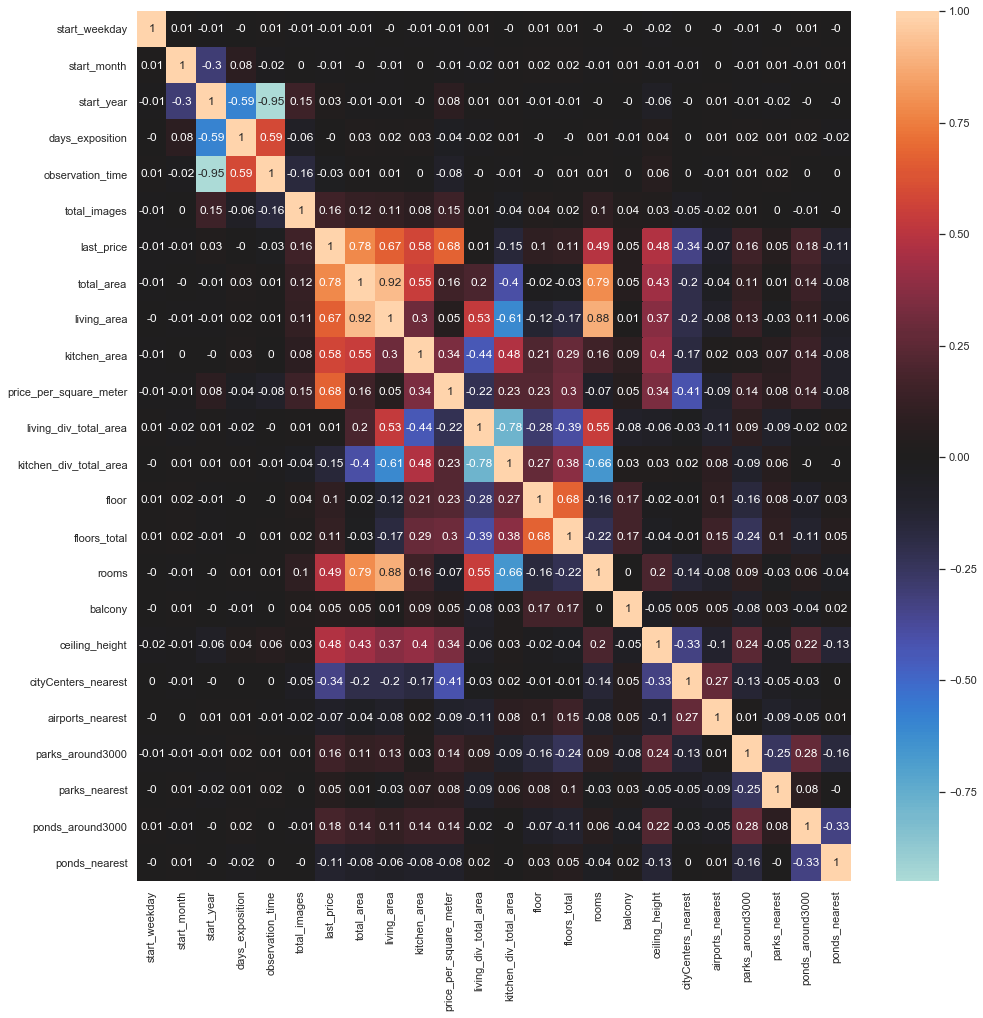

In [158]:
full_corr_matrix = flat_data_good.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(data=full_corr_matrix.round(2), center=0, annot=True)
plt.show()

Непросто даже с тепловой картой. Сделаем матрицы корреляций по значению коэффициента корреляции Пирсона PCC:
- от 0,3 до 0,5 - weak
- от 0, 5 до 0,7 - moderate
- от 0,7 до 0, 9 - strong
- от 0,9 до 1 - perfect

Корреляции с days_exposition некорректны в общем анализе, т.к там есть пул за 2019 год, отмеченный как -100. Корреляции days_exposition рассчитаем отдельно. Корреляция между временем наблюдения и годом: так и есть, чем ближе ко времени выгрузки ("старше" год), тем меньше время наблюдения за объявлениями этого года.

In [159]:
#убираю единицу, чтобы не показывались автокорреляции
#готовлю список условий
perefect_corr_cond = (abs(full_corr_matrix) >= 0.9) & (full_corr_matrix != 1)
strong_corr_cond = (abs(full_corr_matrix) >= 0.7) & (abs(full_corr_matrix) < 0.9) & (full_corr_matrix != 1)
moderate_corr_cond = (abs(full_corr_matrix) >= 0.5) & (abs(full_corr_matrix) < 0.7) & (full_corr_matrix != 1)
weak_corr_cond = (abs(full_corr_matrix) >= 0.3) & (abs(full_corr_matrix) < 0.5) & (full_corr_matrix != 1)

In [160]:
#срезы матрицы корреляций
perfect_corr = full_corr_matrix[perefect_corr_cond].dropna(how="all").dropna(axis=1, how="all")
strong_corr = full_corr_matrix[strong_corr_cond].dropna(how="all").dropna(axis=1, how="all")
moderate_corr = full_corr_matrix[moderate_corr_cond].dropna(how="all").dropna(axis=1, how="all")
weak_corr = full_corr_matrix[weak_corr_cond].dropna(how="all").dropna(axis=1, how="all")
corr_matrixes_list = [perfect_corr, strong_corr, moderate_corr, weak_corr]

Тепловые матрицы силы линейных взаимосвязей


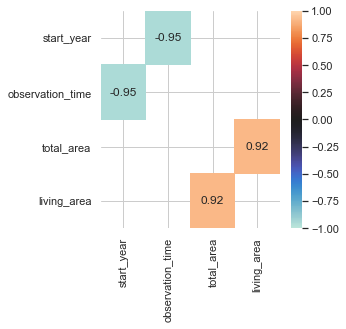

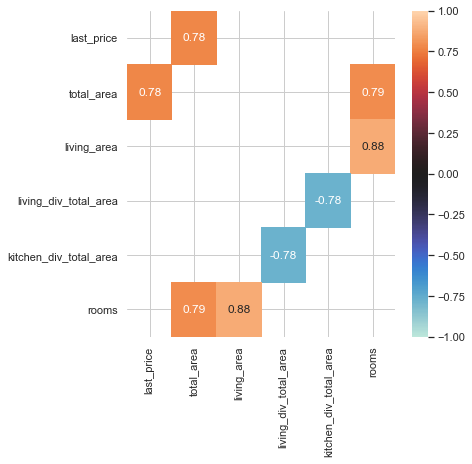

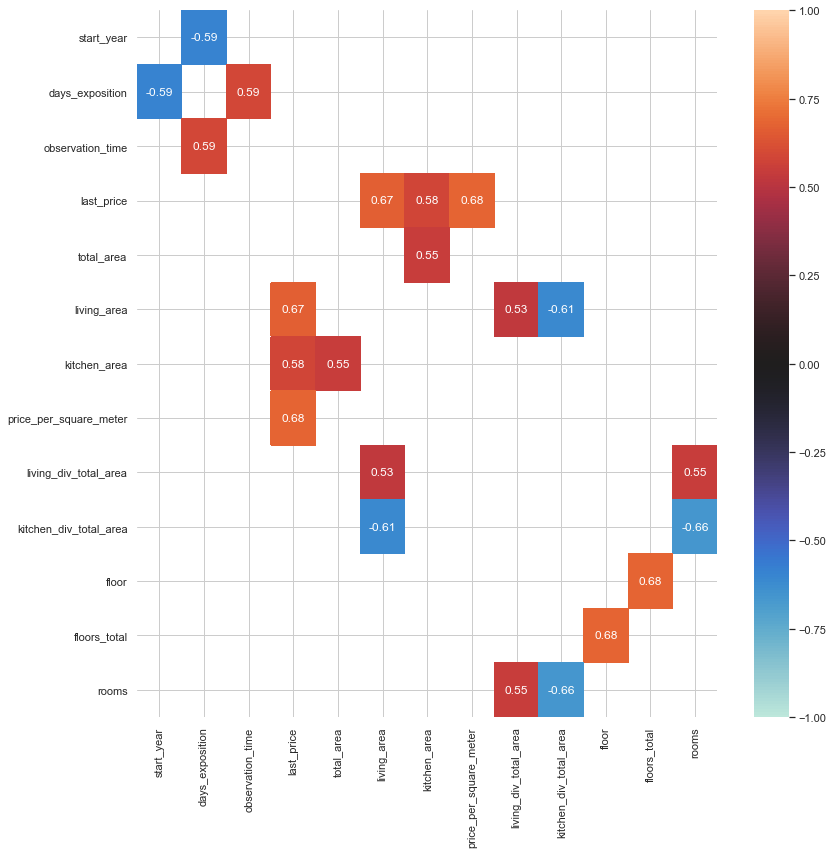

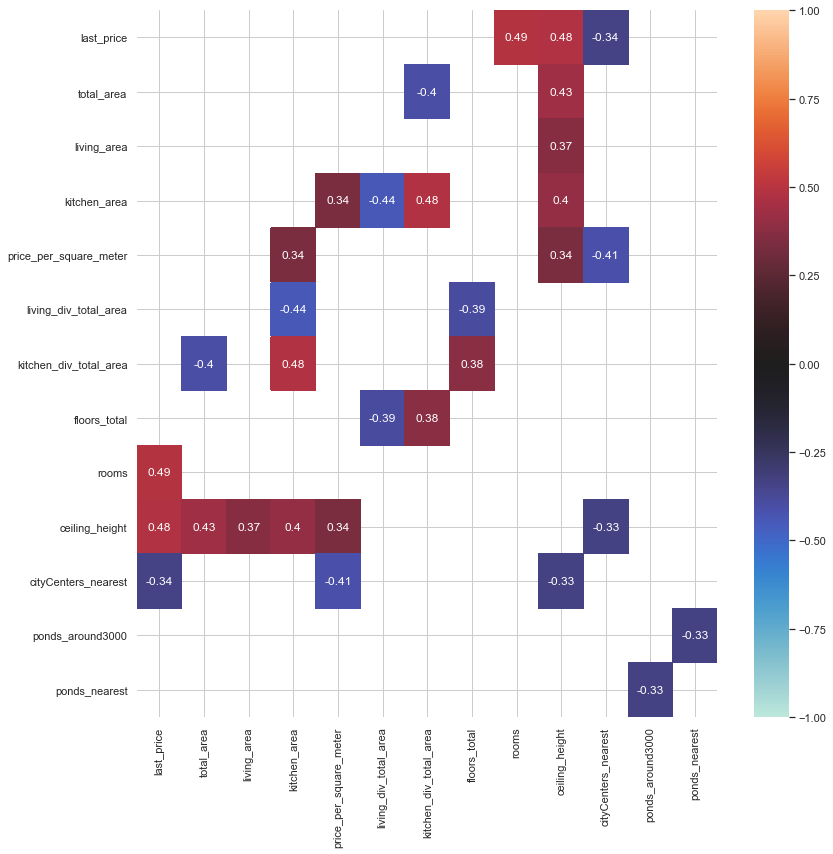

In [161]:
print('Тепловые матрицы силы линейных взаимосвязей')
for corr_matrix in corr_matrixes_list:
    plt.figure(figsize=(len(corr_matrix),len(corr_matrix)))
    sns.heatmap(data=corr_matrix.round(2), center=0, vmin=-1, vmax=1, annot=True)
    plt.grid(True)
    plt.show()

In [162]:
flat_data_good.loc[flat_data_good.loc[:, 'days_exposition'] > 0, :].corr()['days_exposition']

start_weekday            -0.018109
start_month              -0.035612
start_year               -0.426029
days_exposition           1.000000
observation_time          0.444179
total_images              0.010857
last_price                0.085431
total_area                0.114627
living_area               0.108185
kitchen_area              0.058963
price_per_square_meter    0.000491
living_div_total_area     0.017671
kitchen_div_total_area   -0.041368
floor                    -0.040693
floors_total             -0.050591
rooms                     0.087785
balcony                  -0.013995
ceiling_height            0.083209
cityCenters_nearest      -0.017455
airports_nearest         -0.006663
parks_around3000          0.041937
parks_nearest             0.016657
ponds_around3000          0.035398
ponds_nearest            -0.040791
Name: days_exposition, dtype: float64

На самом деле срок продаж слабо линейно связан с годом размещения. Мы видели эту зависимость в разделе удаления дублей, когда строили график доли продаж в зависимости от времени наблюдения. В ранние годы там наблюдается много "долгих" объявлений.

Много информации но, на самом деле, нового мало. 
Есть очевидные линейные связи, которые подтверждают корректность данных и уже замечены ранее на гистограммах 


Отметим основные моменты:


- **Очень сильные линейные связи (perfect)**
    - больше общая площадь - больше жилая и наоборот. Это ожидаемо. Значит, показатели, рассчитанные на основе общей или жилой площади будут тоже связаны.


- **Сильные линейные связи (strong)** 
    - **<font style="Color:OrangeRed">больше общая площадь - выше цена объекта</font>.**
    - больше жилая/общая площадь - больше комнат
    - больше доля кухни в общей площади - меньше доля жилой площади и комнат(это заметили ещё на гистограммах: чем больше доля жилой площади, тем меньше доля нежилой, в том числе - кухни)
    

- **Линейные связи средней силы (moderate)**

    - **<font style="Color:OrangeRed">чем дороже объект, тем дороже квадратный метр его площади</font>.** Это говорит о том, что стоимость квартиры во многом зависит не только от её площади, и это важный момент в исследовании. (если б было не так, то цена квадратного метра оставалась бы константой и не показывала бы взаимосвязей) **<font style="Color:OrangeRed">Следствие: на стоимость объекта недвижимости влияет не только его площадь.</font>** Логичное умозаключение, из которого следует, что нужно найти, что же ещё влияет.
    - между размерами и долями кухни и жилой площади и числом комнат (хорошо вписываются в уже найденные тенденции)
    - чем больше в доме этажей тем на большем этаже может располагаться квартира (вновь закономерность, подтверждающая качество данных)
    

- **Слабые линейные связи (weak)**
    - срок продажи с годами снижается. Это обманчивая тенденция, скорее всего связанная с временем выгрузки базы. Т.е. в базу попали только объекты, проданные до выгрузки. "Медленные" подажи из 2019 года посто не попали в базу, т.к. не успели произойти.
    - **<font style="Color:OrangeRed">наблюдается тенденция, что в дорогих объектах больше комнат, выше потолки и они ближе к центру</font>**
    - также есть слабая связь высоты потолков с площадью и ценой квадратного метра, а также с близостью центра города (чем ближе, тем выше; вероятно, 2 фактора: архитектура и элитное жильё)
    - **<font style="Color:OrangeRed">С приближение к центру цена квадратного метра имеет тенденцию расти</font>**
    - логичный факт: чем больше рядом водоёмов и парков, тем ближе до ближайшего
    - чем выше дом, тем больше доля кухни в общей площади (возможно, особенность современных планировок: маленькие кухни при обилии техники непрактичны (посудомоечная машина или плита с духовым шкафом? - не хотелось бы решать такую проблему))

<h2 style="color:DodgerBlue"> Выводы из общего линейного корреляционного анализа:</h2>

***
- **Обнаружен ряд взаимосвязей, подтверждающих корректность набора данных.** Например, связь этажности дома и этажа расположения квартиры (банально "в высоком доме есть квартиры на высоких этажах; чем выше дом, тем выше есть квартиры"). Связь кухня - жилая - нежилая площадь (по принципу кусков общего пирога: больше один - меньше другой) и т.д. Правильные данные - правильные зависимости


- **Не обнаружено "странных" связей** - опять же, данные в норме


- **Обнаружены важные линейные взаимосвязи, касающиеся стоимости жилья**:

    - **<font style="Color:OrangeRed">сильная линейная связь площади и стоимости объекта (r = 0,78)</font>**
    - на стоимость влияет не только площадь, т.к. есть **<font style="Color:OrangeRed">связь средней силы между стоимостью объекта и ценой квадратного метра (r = 0,68) </font>**
    - **<font style="Color:OrangeRed">слабая связь стоимости квартиры и высоты потолков (r = 0,48) </font>**
    - **<font style="Color:OrangeRed">слабая связь стоимости квартиры и числа комнат (r = 0,49) </font>**
    - **<font style="Color:OrangeRed">слабая обратная связь стоимости квартиры и расстояния до центра города (r = - 0,34)</font>**
    - **<font style="Color:OrangeRed">слабая обратная связь цены квадратного метра и расстояния до центра города (r = - 0,41)</font>**


Таким образом: можно ожидать, что **<font style="Color:OrangeRed">площадь, расстояние до центра города, высота потолков и число комнат - важные параметры</font>**, по которым можно верифицировать стоимость жилья, отследить выбросы и ложные данные. На них в первую очередь и сосредоточим внимание
***

<h2 style="color:DodgerBlue">4.2 Анализ региона в целом. Сравнение Санкт-Петербурга и прочих населённых пунктов.</h2>

Сосредоточим внимание на изучении выявленных связей. Выделим сразу датафреймы для СПб и прочих населённых пунктов. В дальнейшем пригодится.

In [163]:
flat_data_wo_SPb = flat_data_good.query('locality_name_new != "Санкт-Петербург"')

In [164]:
flat_data_only_SPb = flat_data_good.query('locality_name_new == "Санкт-Петербург"')

Убедимся, что средняя стоимость недвижимости сильно зависит от типа населённого пункта. В том числе, столица это или нет.

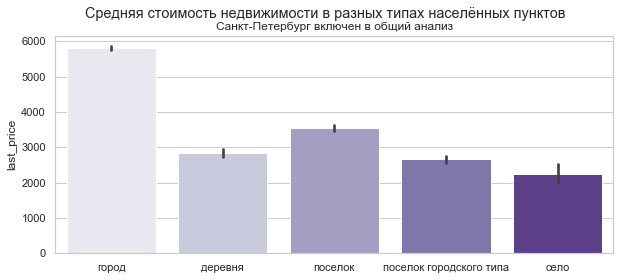

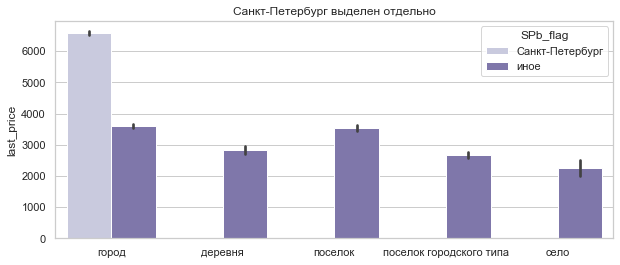

In [165]:
plt.figure(figsize=(10,4))
sns.barplot(x='locality_type_new', y='last_price',  
                   data=flat_data_good, palette="Purples")
plt.suptitle('Средняя стоимость недвижимости в разных типах населённых пунктов')
plt.title('Санкт-Петербург включен в общий анализ')
plt.xlabel('')
plt.figure(figsize=(10,4))
sns.barplot(x='locality_type_new', y='last_price',  
                   data=flat_data_good, hue='SPb_flag', palette="Purples")
plt.title('Санкт-Петербург выделен отдельно')
plt.xlabel('')
plt.show()

## 4.2.1 Связь стоимости и цены квадратного метра. Сравнение Санкт-Петербурга и региона

В контексте задачи интересно, какова связь стоимости жилья и цены квадратного метра (слабую линейную связь показал корреляционный анализ). Наличие такой связи показывает, что жильё может быть дороже или дешевле при одинаковой площади, что себестоимость жилья различается по региону.

Налияие связи понятно, т.к. цена квадратного метра рассчитана на базе стоимости и площади. Однако связь бы отсутствовала, не будь у себестоимости вариаций (т.е. если бы цена квадратного метра была примерно постоянной величиной)

Посмотрим на диаграммы рассеяния для этих показателей, чтобы оценить, насколько велика вариабелность себестоимости в регионах и в Санкт-Петербурге.

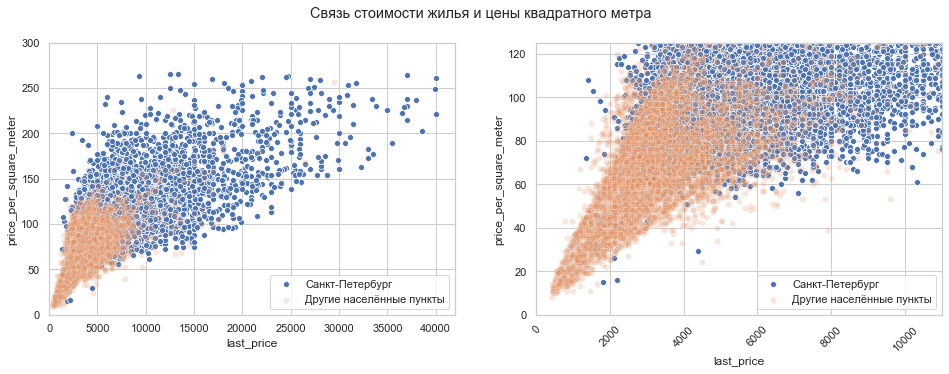

In [166]:
plt.figure(figsize=(16,5))

ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

plt.xticks(rotation=45)
plt.xticks(rotation=45)

ax1.set_xlim(0,42000)
ax1.set_ylim(0,300)

ax2.set_xlim(0,11000)
ax2.set_ylim(0,125)

plt.suptitle('Связь стоимости жилья и цены квадратного метра')

for ax in [ax1, ax2]:
    sns.scatterplot(ax=ax, x='last_price', y='price_per_square_meter', 
                    data=flat_data_only_SPb, label='Санкт-Петербург')
    sns.scatterplot(ax=ax, x='last_price', y='price_per_square_meter', 
                    data=flat_data_wo_SPb, label='Другие населённые пункты', alpha=0.2)

plt.show()

In [167]:
display('Корреляция стоимости и цены кв. метра. Спирмен')
display(f"Регион (без СПб): {flat_data_wo_SPb['price_per_square_meter'].corr(flat_data_wo_SPb['last_price'])}")
display(f"Только СПб: {flat_data_only_SPb['price_per_square_meter'].corr(flat_data_only_SPb['last_price'])}")


'Корреляция стоимости и цены кв. метра. Спирмен'

'Регион (без СПб): 0.6373148966151994'

'Только СПб: 0.6092356336570534'

Стоимость и цена квадратного метра почти одинаково связаны как в северное столице, так и в других населённых пунктах региона. В среднем квадратный метр "дорогого" жилья стоит дороже, чем квадратный метр "дешевого". Связь средняя, облако точек постепенно "рассеивается" в сторону с увеличением стоимости. В области минимальных цен рассеяние меньше. Что это значит: что жильё может стоить дороже не потому, что оно больше, а почему-то ещё. Верно и обратное. Хотя площадь оказывает выраженное влияние на стоимость. В регионах в недорогом сегменте рынка влияние иных факторов, похоже, выражено сильнее (вероятно важно, в каком населённом пункте расположена квартира)

Что ещё можно увидеть на диаграмме: 
- площадь жилья ограничена сверху (это нижняя граница облака точек; например, квартир больше 200 кв. м в базе данных нет).
- чем выше себестоимость, тем выше граница максимальной площади жилья (но 200 кв. м - это максимум)
- граница минимальной площади тоже есть, но она становится заметной при цене выше 150 тыс за кв. метр. Например, 20 метровая квартира за 4 млн - почти без вариантов. А вот за 3 млн. варианты ещё есть.


Таким образом, и в регионt и в столице кроме площади есть другие факторы, влияющие на стоимость. В столице их, похоже, больше, т.к. вариабельность больше. Определить их - как раз задача анализа.

## 4.2.2 Площадь. Санкт-Петебург и регион.

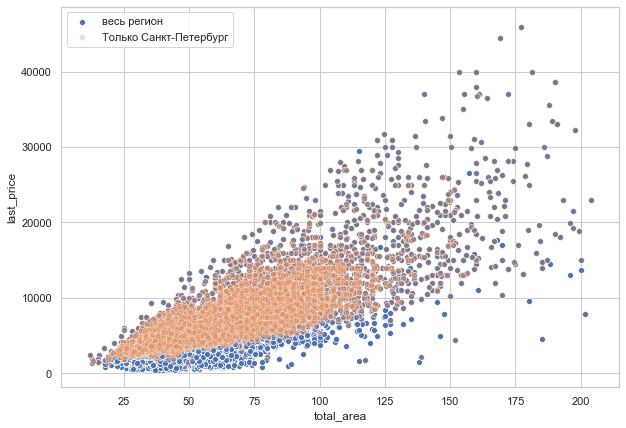

In [168]:
plt.figure(figsize=(10,7))
sns.scatterplot(y='last_price', x='total_area', 
                data=flat_data_good, alpha=1, palette="Set2", label="весь регион")
sns.scatterplot(y='last_price', x='total_area', 
                data=flat_data_only_SPb, alpha=0.3, palette="Set2", label="Только Санкт-Петербург")
plt.show()

Площадь, несомненно, важный параметр. С ростом площади цена растёт. И для региона в целом и в отдельности для столицы можно установить порог максимальной стоимости квартиры для определённой площади (верхняя граница диаграммы демонстрирует линейный рост). Но для региона в целом фактически нет различий в нижней границе стоимости квартир площадью до 75 кв. метров. При этом в Санкт-Петербурге связь более явная. Больших бюджетных квартир значительно меньше, нижняя граница облака точек линейно "растёт". Показатель площади для анализа адекватности цены в Санкт-Петербурге будет более эффективен, ценовой коридор будет уже. В анализе стоит отделять Санкт-Петербург от остального региона, т.к. видны значительные отличия и в предыдущем и в текущем пункте.

## 4.2.3 Число комнат. Санкт-Петебург и регион.

In [169]:
display(
    f'4-комнатные: {len(flat_data_good.query("rooms == 4"))}',
    f'5-комнатные: {len(flat_data_good.query("rooms == 5"))}',
    f'6-комнатные: {len(flat_data_good.query("rooms == 6"))}',
    f'более 6 комнат: {len(flat_data_good.query("rooms > 6"))}'
)

'4-комнатные: 858'

'5-комнатные: 161'

'6-комнатные: 25'

'более 6 комнат: 9'

Больше 4 комнат - это действительно редкость, по этим цифрам вряд ли что-то можно сказать. Объединим квартиры с 5 и более комнатами под общим идентификатором "5".

In [170]:
flat_data_good.loc[flat_data_good.loc[:, 'rooms'] >= 5 , 'rooms'] = 5

In [171]:
flat_data_wo_SPb.loc[flat_data_wo_SPb.loc[:, 'rooms'] >= 5 , 'rooms'] = 5
flat_data_only_SPb.loc[flat_data_only_SPb.loc[:, 'rooms'] >= 5 , 'rooms'] = 5

In [172]:
display(
    f'5 и более комнат: {len(flat_data_good.query("rooms == 5"))}'
)

'5 и более комнат: 195'

С комнатами разобрались, приступим к анализу.

Согласно результатам корреляционного анализа, в среднем число комнат влияет на стоимость квартир в регионе аналогично площади. Больше площадь-больше комнат-больше цена. В среднем так.

По факту, могут встречаться самые разные варианты. Оценим боксплот и столбчатую диаграмму для средних значений: 

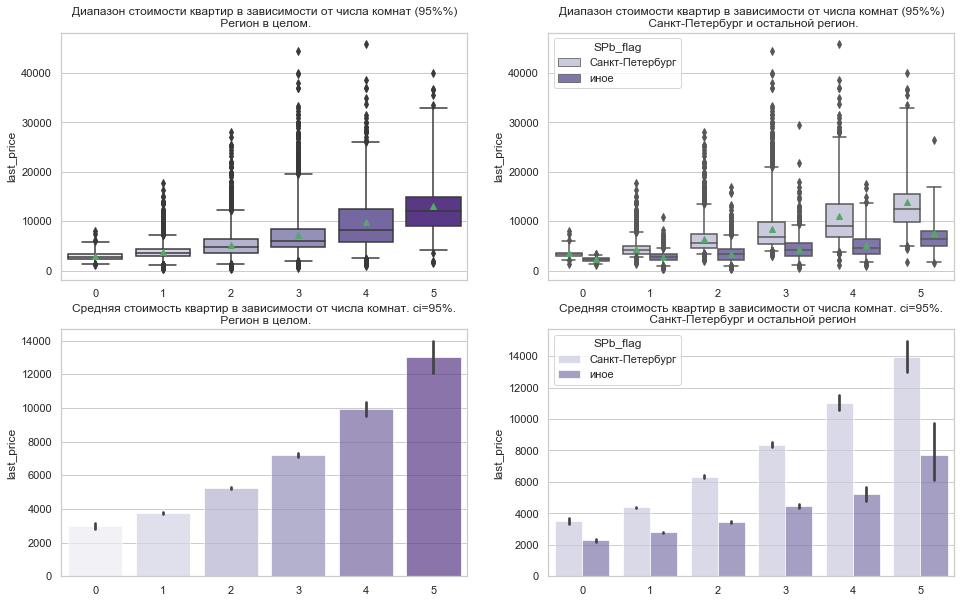

In [173]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.set_title(f"""Диапазон стоимости квартир в зависимости от числа комнат (95%%)\n Регион в целом.""")
ax3.set_title(f"""Средняя стоимость квартир в зависимости от числа комнат. ci=95%.\n Регион в целом.""")
ax2.set_title(f"""Диапазон стоимости квартир в зависимости от числа комнат (95%%)\n Санкт-Петербург и остальной регион.""")
ax4.set_title(f"""Средняя стоимость квартир в зависимости от числа комнат. ci=95%.\n Санкт-Петербург и остальной регион""")


sns.boxplot(ax=ax1, x='rooms', y='last_price',  
                   data=flat_data_good, whis=(2.5,97.5), showmeans=True, palette="Purples")

sns.boxplot(ax=ax2, x='rooms', y='last_price',  
                   data=flat_data_good, hue='SPb_flag', whis=(2.5,97.5), showmeans=True, palette="Purples")

sns.barplot(ax=ax3, x='rooms', y='last_price',  
                   data=flat_data_good, palette="Purples", alpha=0.7)

sns.barplot(ax=ax4, x='rooms', y='last_price',  
                   data=flat_data_good, hue='SPb_flag', palette="Purples", alpha=0.7)

for ax in ax.flatten():
    ax.set_xlabel('')

plt.show()

Закономерность роста стоимости с ростом числа комнат подтверждается. Но для отдельных квартир ценовые коридоры (вариабельность) довольно широкие. Тенденции одинаковые и по региону в целом и отдельно для региона и его столицы: чем больше комнат, тем выше средняя цена квартир. Цены в Санкт-Петербурге тем выше региональных, чем больше комнат. 1и 2 комнатные квартиры дороже в среднем на треть, а 4 и более комнатные - почти в 2 раза.

Представляет интерес анализ совместного использования площади и числа комнат для оценки корректности заявленной стоимости квартиры. Такой анализ выполним ниже для Санкт-Петербурга.

## 4.2.4 Этажи и стоимость жилья. Санкт-Петербург и регион

### Средние показатели по региону

In [174]:
def price_boxplot(data_price, category, main_title='', hue_param=None, ylim1=(0, 20000), ylim2=(0, 200), rot_angle=0):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax1, ax2 = ax.flatten()
    
    sns.boxplot(x=category, y='last_price', data=data_price, 
                ax=ax1, whis=(2.5, 97.5), linewidth=2, hue=hue_param, showmeans=True, palette="Purples")
    sns.boxplot(x=category, y='price_per_square_meter', data=data_price, 
                ax=ax2, whis=(2.5, 97.5), linewidth=2, hue=hue_param, showmeans=True, palette="Blues")

    ax1.set_title('Cтоимость недвижимости')
    ax1.set_ylim(ylim1)
    ax1.set_xlabel('')
    ax1.set_ylabel('Стоимость, тыс. руб.')

    ax2.set_title('Цена квадратного метра')
    ax2.set_ylim(ylim2)
    ax2.set_xlabel('')
    ax2.set_ylabel('Цена, тыс. руб.')
    plt.suptitle(main_title)
    
    for ax in ax.flatten():
        ax.tick_params(axis='x', rotation=rot_angle) 
    
    plt.show()

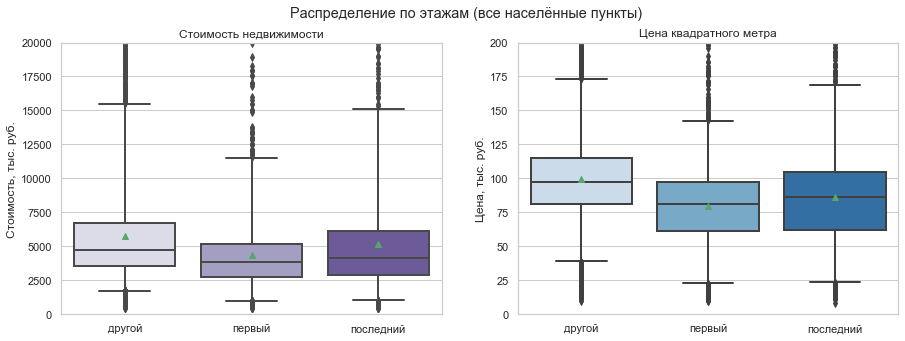

In [175]:
price_boxplot(flat_data_good, 'floor_categ', main_title='Распределение по этажам (все населённые пункты)')

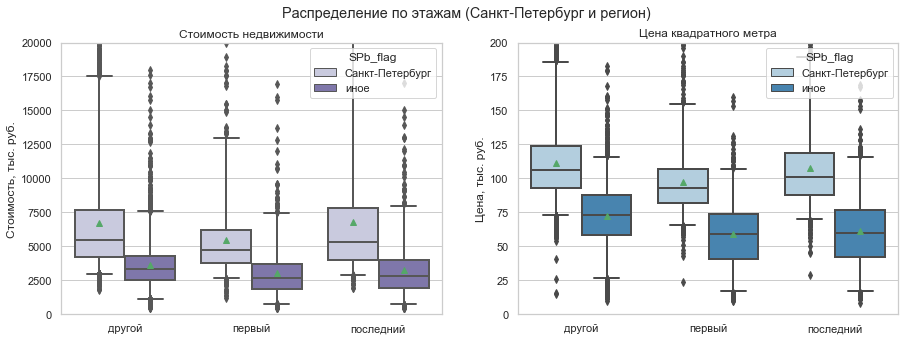

In [176]:
price_boxplot(flat_data_good, 'floor_categ', hue_param='SPb_flag',
              main_title='Распределение по этажам (Санкт-Петербург и регион)')

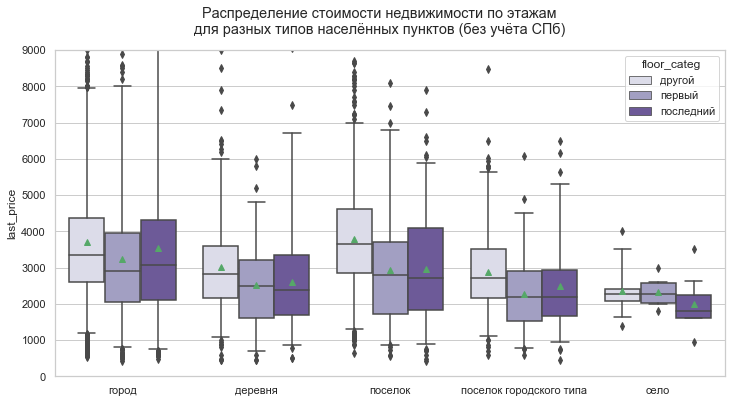

In [177]:
plt.figure(figsize=(12,6
                   ))
sns.boxplot(x='locality_type_new', y='last_price', hue='floor_categ', data=flat_data_wo_SPb, 
                whis=(2.5, 97.5), showmeans=True, palette="Purples")
plt.ylim(0,9000)
plt.xlabel('')
plt.suptitle("""Распределение стоимости недвижимости по этажам
для разных типов населённых пунктов (без учёта СПб)""")
plt.show()

In [178]:
flat_data_good.groupby('floor_categ')[['last_price', 'price_per_square_meter']].aggregate(['mean', 'std', 'median']).round(2)

last_price                 price_per_square_meter              
                  mean      std median                   mean    std median
floor_categ                                                                
другой         5728.39  3736.71   4700                  99.32  32.06     97
первый         4371.72  2750.26   3850                  79.92  30.41     81
последний      5155.08  3916.37   4150                  86.25  36.54     86

**В среднем по региону:**

Недвижимость, расположенная на 1 этаже - самая дешёвая, как и цена квадратного метра. Стоимость квартир на 1м этаже в среднем на 22% ниже, чем на промежуточных. Средняя стоимость квартир на последнем этаже тоже в среднем дешевле: на 11%. Самые дорогие квартиры - на промежуточных этажах. Средняя цена за квадратный метр - 99 тыс. руб., средняя стоимость - 5,7 млн.

**Санкт-Петербург:**

Ожидаемо всё дороже в 1.5 - 2 раза, чем в среднем по региону. В северной столице последние этажи стоят примерно как промежуточные, т.к. широко представлен дорогой сегмент. Видно, что в СПб средние выше медиан. Это обусловлено наличием дорогого сегмента жилья. Дорогих квартир мало, но они существенно влияют на среднее.

**Кроме Санкт-Петербурга:**

Вне Санкт-Петербурга самая дорогая недвижимость - в посёлках и городах, самая дешёвая - в сёлах. В сёлах мансардные этажи - самые дешёвые. В ПГТ и городах ситуация близка к общей картине. В посёлках и деревнях последний и первый этажи в среднем почти одной стоимости. Промежуточные этажи - везде самые дорогие, особенно выделяются посёлки.

## 4.2.5 Удалённость от центра

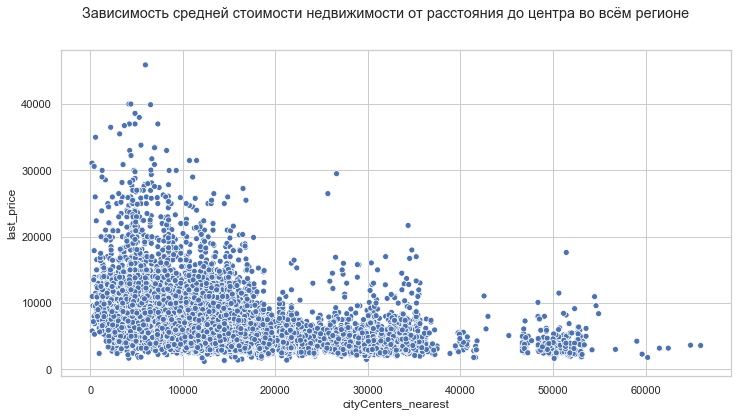

In [179]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='cityCenters_nearest', 
                                      y='last_price', 
                                      data=flat_data_good, 
                                      markers=True, style=0, legend=False, ci=95)

plt.suptitle("""Зависимость средней стоимости недвижимости от расстояния до центра во всём регионе""")
plt.show()

Чем ближе к центру, тем дороже. Этого и следовало ожидать. Однако до определённого расстояния разница несущественная. Явные отличия видны в зоне 25км от центра. Ближе этой отметки быстро растёт число дорогой недвижимости. Видны отдельные анклавы точек вдали от центра. Видимо, отдельные населённые пункты. Очевидна зависимость стоимости от расстояния до центра в Санкт-Петербурге.

## 4.2.6 Связь даты размещения объявлений и стоимости жилья. Весь регион

Интересно, может ли зависеть стоимость продажи жилья от того дня недели, месяца или года, когда было размещено объявление? Посмотрим графики.

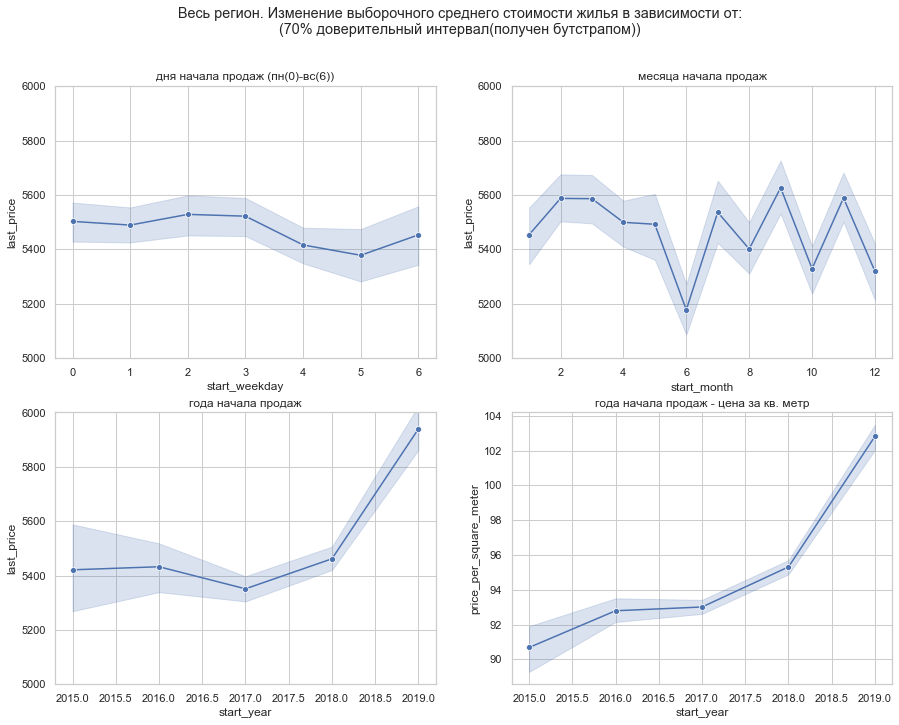

In [180]:
plt.figure(figsize=(15,11))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)
ci_value = 70

ax1.set_ylim(5000,6000)
ax2.set_ylim(5000,6000)
ax3.set_ylim(5000,6000)


sns.lineplot(ax=ax1, x='start_weekday', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_good)
sns.lineplot(ax=ax2, x='start_month', y='last_price',  
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_good)
sns.lineplot(ax=ax3,
             x='start_year', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_good)
sns.lineplot(ax=ax4,
             x='start_year', y='price_per_square_meter', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_good, label='весь город')

plt.suptitle(f"""Весь регион. Изменение выборочного среднего стоимости жилья в зависимости от:
({ci_value}% доверительный интервал(получен бутстрапом))
            """)
ax1.set_title('дня начала продаж (пн(0)-вс(6))')
ax2.set_title('месяца начала продаж')
ax3.set_title('года начала продаж')
ax4.set_title('года начала продаж - цена за кв. метр')
plt.show()

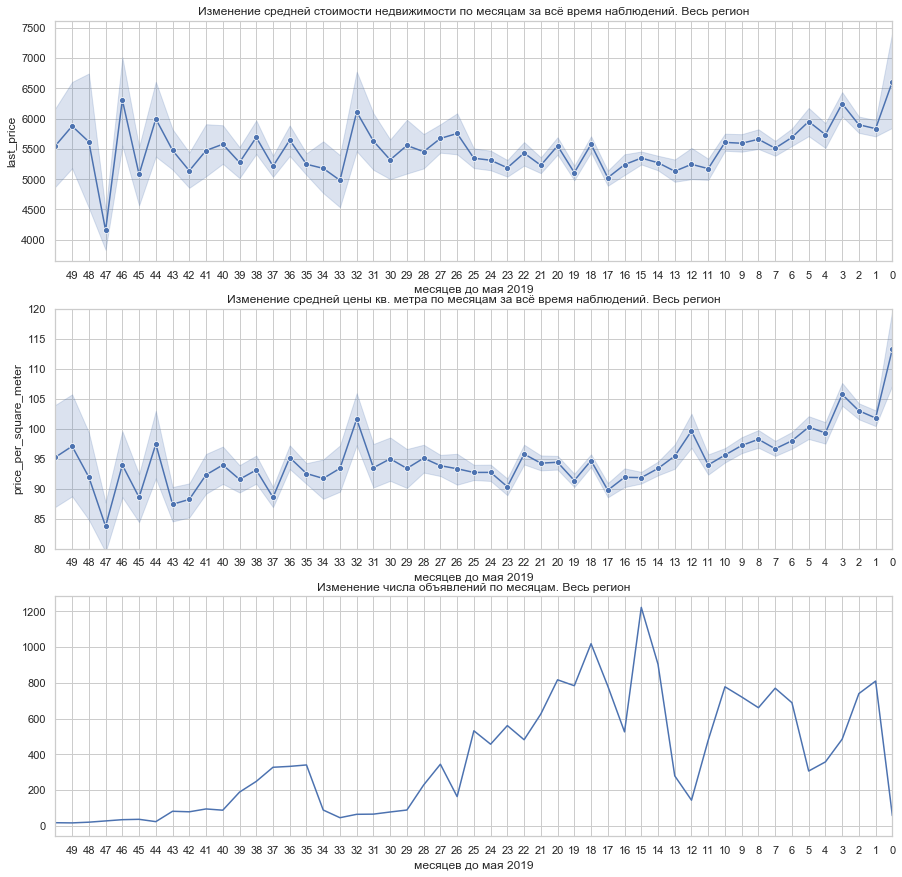

In [181]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1, ax2, ax3 = ax.flatten()

ax1.set_title('Изменение средней стоимости недвижимости по месяцам за всё время наблюдений. Весь регион')
ax2.set_title('Изменение средней цены кв. метра по месяцам за всё время наблюдений. Весь регион')
ax3.set_title('Изменение числа объявлений по месяцам. Весь регион')

ax2.set_ylim(80,120)

sns.lineplot(ax=ax1, x='observation_time', y='last_price', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_good)

sns.lineplot(ax=ax2, x='observation_time', y='price_per_square_meter', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_good)

sns.lineplot(ax=ax3,data=flat_data_good['observation_time'].value_counts())

for i in range (0,3):
    ax.flatten()[i].set_xlim(reversed(ax.flatten()[i].set_xlim(0,50)))
    ax.flatten()[i].set_xlabel('месяцев до мая 2019')
    ax.flatten()[i].set_xticks(range(0,50))

Чётко видно, что цена за кв. метр устойчиво и равномерно растёт с 2015 по 2019 год. Об этом можно говорить с уверенностью. Также хорошо видна тенденция роста цен по годам. Однако, надо помнить, что за 2014-2015 данных мало. 2019 год представлен неполно. На графиках по дням недели и месяцам большая вариабельность среднего значения. Хотя заметен спад в июне (как отмечали ранее в мае 2018 был скачок доллара; то время может оказывать влияние на данные) и спад в пятницу и субботу.

Динамика цен по месяцам хорошо видна на графике среднемесячных цен за всё время наблюдений. Прослеживаются уже установленные зависисмости: рост стоимости и рост цены за кв. метр. Сразу становится понятна изменчивость среднемесячных значений за все годы. Также на нижнем графике показана дикамика числа объявлений. Видно, что от месяца к месяцу происходят серьёзные колебания. Также отлично виден спад мая 2018, это 12 месяц на оси x. Число объявлений и стоимость жилья резко упала.

## 4.2.7 Топ-10 населённых пунктов по продажам недвижимости: отличия

В топ-10 по числу продаж входят:

In [182]:
flat_data_good['locality_name_new'].value_counts().head(10)

Санкт-Петербург    12435
Мурино               495
Кудрово              389
Шушары               383
Всеволожск           328
Колпино              294
Пушкин               290
Парголово            283
Гатчина              249
Выборг               206
Name: locality_name_new, dtype: int64

In [183]:
#создаю список топ-10 нас. пунктов по продажам
top10_localities_list = flat_data_good['locality_name_new'].value_counts().head(10).index.tolist()
#делаю срез на базе списка
flat_data_good_top10_loc = flat_data_good.query('locality_name_new == @top10_localities_list')
#делаю pivot table и считаю средние
flat_data_good_top10_loc.pivot_table(index='locality_name_new',
                                     values=['last_price','price_per_square_meter']).round(0).sort_values(by='last_price', ascending=False)


last_price  price_per_square_meter
locality_name_new                                    
Санкт-Петербург        6573.0                   109.0
Пушкин                 5943.0                   102.0
Парголово              4487.0                    90.0
Кудрово                4378.0                    96.0
Шушары                 4095.0                    78.0
Колпино                3900.0                    75.0
Всеволожск             3744.0                    67.0
Мурино                 3653.0                    86.0
Гатчина                3464.0                    68.0
Выборг                 3220.0                    58.0

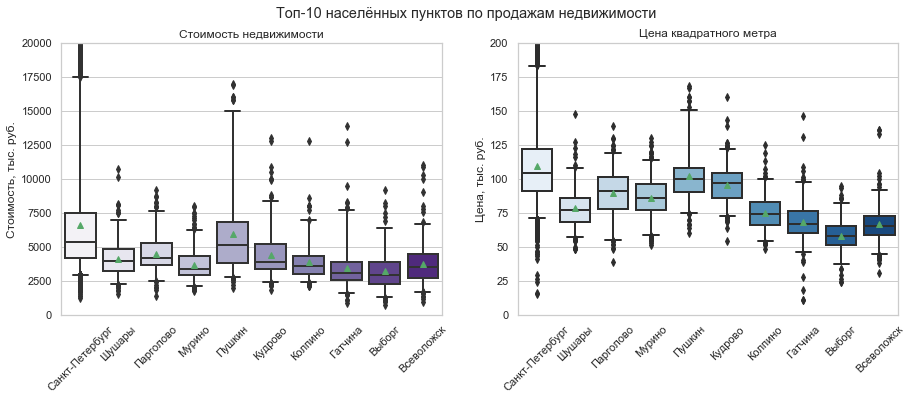

In [184]:
price_boxplot(flat_data_good_top10_loc, 'locality_name_new',
              main_title='Топ-10 населённых пунктов по продажам недвижимости', rot_angle=45)

Стоимость жилья существенно зависит от населённого пункта. Санкт-Петербург и Пушкин - самые дорогие города. Самая низкая стоимость жилья - в Выборге и Гатчине.

<h2 style="color:DodgerBlue">Выводы из анализа региона в целом и его отличий от столицы</h2>

***
В регионе отчётливо выделяется столица, Санкт-Петербург. Хотя большинство тенденций и связей справедливы для всех населённых пунктов, но стоимость жилья и число вариаций в столице существенно выше.


**Стоимость и цена квадратного метра** почти одинаково связаны как в северной столице, так и в других населённых пунктах региона. В среднем квадратный метр "дорогого" жилья стоит дороже, чем квадратный метр "дешевого". Диапазон цен в Санкт-Петербурге значительно шире. Связь стоимости и цены квадратного метра указывает, что и в регионе и в столице кроме площади есть другие факторы, влияющие на стоимость.


**Площадь**, несомненно, важный параметр. С ростом площади цена растёт. В Санкт-Петербурге связь более явная. В регионе шире представлены квартиры относительно высокой площади (до 75 кв. м) по бюджетным ценам, поэтому коридора площадь-цена значительно шире. Показатель площади для оценки стоимости недвижимости в Санкт-Петербурге будет более эффективен, т.к. ценовой коридор уже.


**Чем больше комнат, тем выше средняя цена квартир.** Тенденции одинаковые и по региону в целом и отдельно для региона и его столицы. Цены в Санкт-Петербурге тем выше региональных, чем больше комнат (в 1.3-2 раза в зависимости от числа комнат).  Перспективным выглядит совместное использование числа комнат и площади при анализе рынка на предмет аномалий.


**Первый, последний и промежуточные этажи** отличаются по стоимости. Это верно для всех населённых пунктов региона. Самые дорогие этажи - промежуточные. В среднем по региону 1 этаж на 22% дешевле, последний - на 11%. В Санкт-Петербурге всё дороже в 1.3 - 2 раза, последние этажи в среднем стоят примерно как промежуточные, т.к. шире представлен дорогой сегмент. Если посмотреть на типы населённых пунктов, то оказывается, что сёлах самые дешёвые - мансардные этажи, а не первые. В ПГТ и городах ситуация близка к усреднённой картине. В посёлках и деревнях последний и первый этажи в среднем почти одной стоимости.


Рост стоимости недвижимости явно наблюдается в области 25 км **от центра города**. Чем ближе к центру - тем больше дорогой недвижимости и выше стоимость.


**Зависимость от даты размещения** также прослеживается. Можно уверенно говорить о росте средней стоимости и средней цены квадратного метра в регионе от года к году. Однако при оценках нужно учитывать колебания числа объявлений и неполные данные за 2019 год. Прослеживается спад средней стоимости в 6 месяце года, но он может быть вызван кризисом мая 2018 года. Из-за колебаний от месяца к месяцу к средним оценкам по месяцам и дням недели слледует относиться с осторожностью и рассматривать их только в совокупности с числом объявлений на платформе.


**В топ-10 населённых пунктов** региона по числу объявлений наблюдается значительный разброс средней стоимости недвижимости и цены квадратного метра. Самые дорогие города - Санкт-Петербург (6.6млн/109т.р.) и Пушкин (5.9млн/102т.р.). Дешевле всего жильё в Выборге (3.2млн / 58тыс. р.) и Гатчине (3,5млн /68т.р.)
***

<h2 style="color:DodgerBlue">4.3 Санкт-Петербург. Площадь и число комнат, потолки, расстояние до центра</h2>

In [185]:
display(f"Доля объявлений Санкт-Петербурга среди всех: {round(len(flat_data_only_SPb)/len(flat_data_good)*100, 1)} %")

'Доля объявлений Санкт-Петербурга среди всех: 65.0 %'

Основное влияние на показатели региона оказывает, конечно, Санкт-Петербург. Большая часть объявлений представлена Санкт-Петербургом, там самые высокие цены и самые разные комбинации факторов. Сосредоточим внимание на северной столице. 

Уже очевидно, что большое влияние на стоимость оказывает расстояние до центра. Но хотелось бы сперва подробнее оценить эффективность совместного применения площади и числа комнат. Данные о парках и водоёмах (как и о расстоянии до центра) указаны в основном для Санкт-Петербурга. Их влияние тоже оценим.

## 4.3.1 Санкт-Петербург. Совместный анализ площади и числа комнат

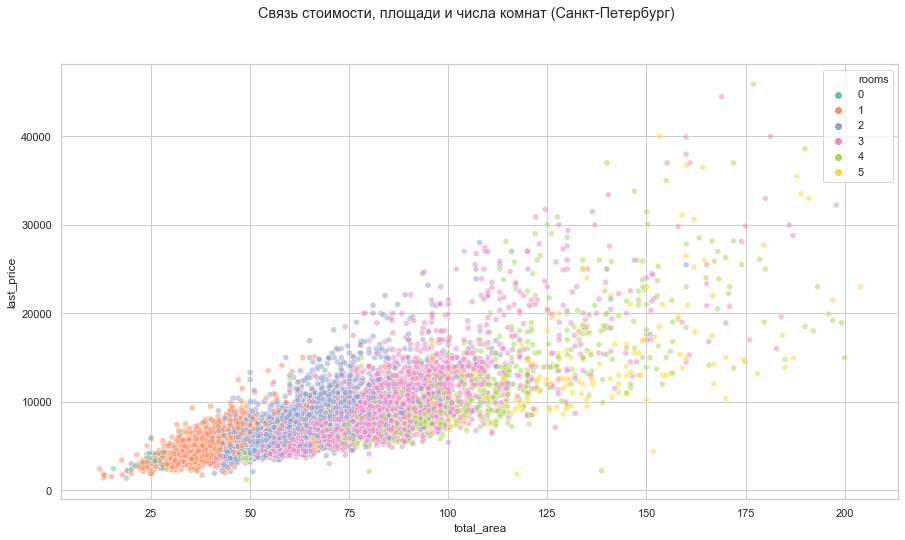

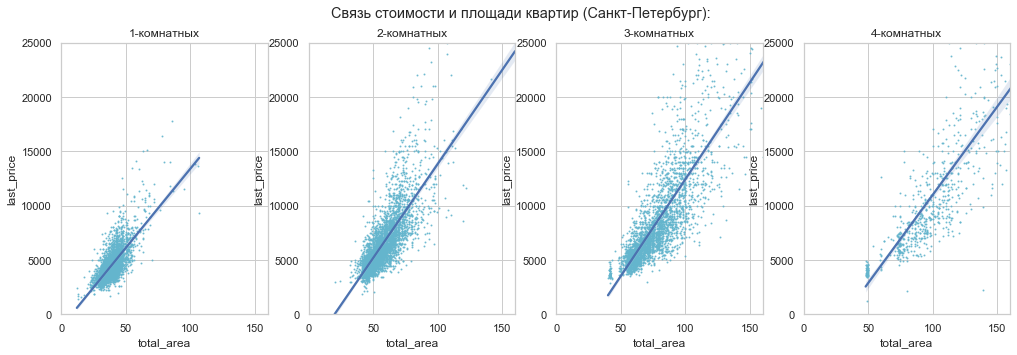

In [186]:
plt.figure(figsize=(15,8))
sns.scatterplot(y='last_price', x='total_area', hue='rooms', 
                   data=flat_data_only_SPb, alpha=0.5, palette="Set2")
plt.suptitle("Связь стоимости, площади и числа комнат (Санкт-Петербург)")

plt.figure(figsize=(17,5))
plt.suptitle("Связь стоимости и площади квартир (Санкт-Петербург):")

for i in range(1,5):
    plt.subplot(1,4,i)
    plt.xlim(0,160)
    plt.ylim(0,25000)
    plt.title(f"{i}-комнатных")
    sns.regplot(y='last_price', x='total_area',
                   data=flat_data_only_SPb.query('rooms == @i'), scatter_kws={"s": 1, "color":"c"})


plt.show()

In [187]:
#flat_data_only_SPb.query('rooms == @i')
display("Коэффициент корреляции Спирмена для площади и стоимости обобщённый по числу комнат (только СПб):")
display(flat_data_only_SPb['total_area'].corr(flat_data_only_SPb['last_price']))
display("Коэффициент корреляции Спирмена для площади и стоимости при разном числе комнат в квартире (только СПб):")
for i in range(1,5):
    display(f"""{i}: {flat_data_only_SPb.query('rooms == @i')['total_area'].corr(
                      flat_data_only_SPb.query('rooms == @i')['last_price'])}""")

'Коэффициент корреляции Спирмена для площади и стоимости обобщённый по числу комнат (только СПб):'

0.831426310728475

'Коэффициент корреляции Спирмена для площади и стоимости при разном числе комнат в квартире (только СПб):'

'1: 0.7458386964955099'

'2: 0.7917764795581681'

'3: 0.8180420281340969'

'4: 0.7995292651701509'

Площадь связана со стоимостью жилья, линейная связь сильная (r=0.83). Совместное использование площади и числа комнат показывает, что сильная связь площади со стоимостью сохраняется при разделении на комнатность (r=0.75 - 0.82). Диаграммы аккуратные, овальные. Между диаграммами есть смещение.  Наличие смещения может помочь при контроле качества объявлений (т.е. зная число комнат и уравнение линии регрессии можно более точно, чем в общем случае (т.к. есть смещение), предсказать коридор допустимой цены; уравнения линий регрессии отличаются сдвигом (постоянной))

## 4.3.2 Санкт-Петербург. Высота потолков и стоимость квартир

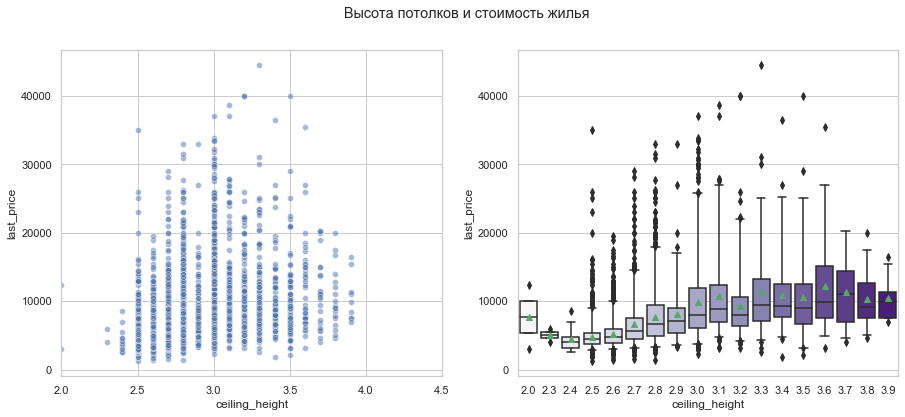

In [188]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.xlim(2,4.5)
sns.scatterplot(y='last_price', x='ceiling_height', 
                   data=flat_data_only_SPb, alpha=0.5, )
plt.subplot(1,2,2)

sns.boxplot(x='ceiling_height', y='last_price',  
                   data=flat_data_only_SPb, whis=(2.5,97.5), showmeans=True, palette="Purples")

plt.suptitle("Высота потолков и стоимость жилья")

plt.show()

In [189]:
#выделю интервал
ceiling_categ = pd.cut(flat_data_only_SPb['ceiling_height'], [0, 2.6, 2.8, 4])
flat_data_only_SPb['ceiling_categ'] = ceiling_categ

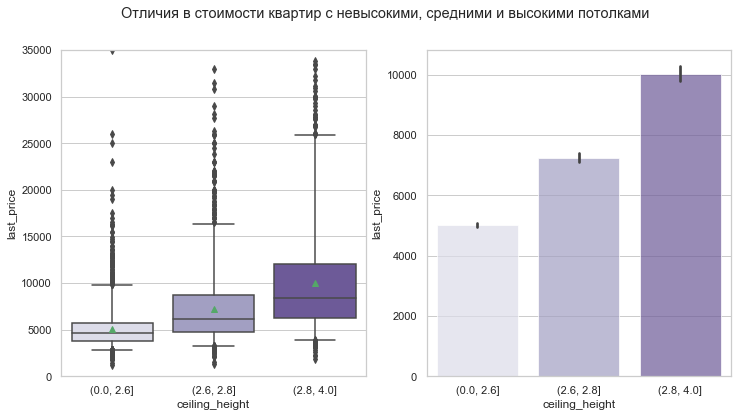

In [190]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1, ax2 = ax.flatten()

ax1.set_ylim(0, 35000)

sns.boxplot(ax=ax1, y='last_price', x=ceiling_categ,  
                   data=flat_data_only_SPb, whis=(2.5,97.5), showmeans=True, palette="Purples")

sns.barplot(ax=ax2, y='last_price', x=ceiling_categ,  
                   data=flat_data_only_SPb, palette="Purples", alpha=0.7)

plt.suptitle("Отличия в стоимости квартир с невысокими, средними и высокими потолками")

plt.show()

In [191]:
ceiling_height_param_list = ['cityCenters_nearest', 
                             'days_exposition', 
                             'floor', 
                             'floors_total', 
                             'last_price',
                             'price_per_square_meter',
                             'total_area', 
                             'parks_around3000', 
                             'ponds_around3000']

flat_data_only_SPb[ceiling_height_param_list].pivot_table(index=ceiling_categ)

cityCenters_nearest  days_exposition     floor  floors_total  \
ceiling_height                                                                 
(0.0, 2.6]             13424.962500        92.058926  5.492385     10.085643   
(2.6, 2.8]             12594.584028       102.650328  8.391247     15.885777   
(2.8, 4.0]              7180.050060       109.445177  4.266028      7.192930   

                  last_price  parks_around3000  ponds_around3000  \
ceiling_height                                                     
(0.0, 2.6]       5020.521598          0.502250          0.569250   
(2.6, 2.8]       7243.199125          0.501097          0.729706   
(2.8, 4.0]      10033.448173          1.004222          1.098311   

                price_per_square_meter  total_area  
ceiling_height                                      
(0.0, 2.6]                  100.312360   50.598245  
(2.6, 2.8]                  117.594311   61.493020  
(2.8, 4.0]                  124.163571   80.170252

С ростом высоты потолка в среднем растёт и стоимость жилья (выбивается 2м, там совсем мало значений). Вариабельность очень большая. Но если разделить на 3 интервала: (0,2.6] - и (2.6, 2.8] и (2.8, 4] (2.5 - это минимум по СНиП, 2.7 - тоже стандарт высоты из СНиП для других климатических зон, т.е. всё, что близко (10 см запаса на погрешность измерений и округлений) к строительным нормам по высоте и ниже - в отдельных категориях), видна довольно существенная разница. Если посмотреть таблицу, то можно много сказать о квартире по  высоте потолков. Наиболее выделяется, что высокие потолки - в среднем гораздо ближе к центру (по сути, в центрально зоне), дороже, дольше продаются, вокруг чаще встречаются парки и водоёмы.
У квартир с низкими потолками - самая низкая средняя себестоимость площади.

Наверняка, тут большую роль играет тип застройки и его преобладание в том или ином районе города. В центре больше зданий с высокими потолками, вне его дорогие и бюджетные дома и квартиры соседствуют. 

## 4.3.3 Санкт-Петербург. Близость парков и водоёмов

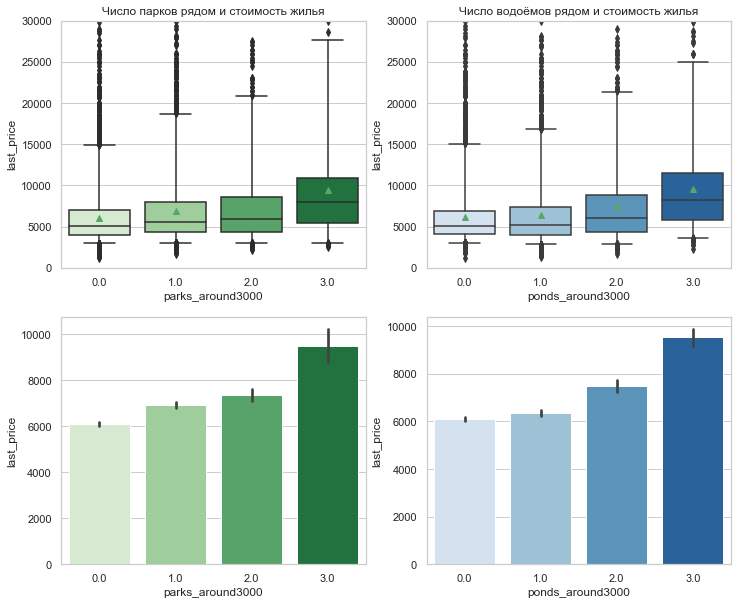

In [192]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax1, ax2, ax3, ax4 = ax.flatten()

for i in range (0,2):
    ax.flatten()[i].set_ylim(0,30000)

ax1.set_title("Число парков рядом и стоимость жилья")
ax2.set_title("Число водоёмов рядом и стоимость жилья")

sns.boxplot(ax=ax1, y='last_price', x='parks_around3000', 
                   data=flat_data_only_SPb, whis=(2.5,97.5), showmeans=True, palette="Greens")
sns.boxplot(ax=ax2, y='last_price', x='ponds_around3000', 
                   data=flat_data_only_SPb, whis=(2.5,97.5), showmeans=True, palette="Blues")
sns.barplot(ax=ax3, y='last_price', x='parks_around3000', 
                   data=flat_data_only_SPb, palette="Greens")
sns.barplot(ax=ax4, y='last_price', x='ponds_around3000', 
                   data=flat_data_only_SPb, palette="Blues")

plt.show()

В среднем, где жильё дороже - там больше парков и водоёмов. Вариабельность для отдельных квартир большая. В среднем для 3 парков и 3 водоёмов средняя цена значимо выше, чем для других вариантов

## 4.3.4 Санкт-Петербург. Расстояние до центра города

Все "дороги" проекта ведут к центру северной столицы. Проанализируем как расстояние до центра влияет на стоимость жилья. Посмотрим гистограмму числа продаж в зависимости от расстояния:

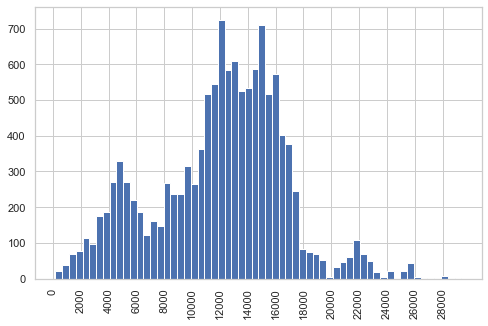

In [193]:
flat_data_only_SPb['cityCenters_nearest'].hist(figsize=(8, 5), bins = 60)
plt.xticks(range(0,30000,2000), rotation=90)
plt.show()

В районе 6-8 км от центра - провал продаж, затем подъём и пик в области 4-6 км. Видимо, это и есть центр. Проверим. Создадим столбец с округлённым расстоянием до центра (округлим до км) и посчитаем среднюю цену для каждого километра, построим график.

In [194]:
#для всего датасета тоже округлю
flat_data_good['distance_to_center_km'] = (flat_data_good['cityCenters_nearest'] / 1000).round(0)
flat_data_only_SPb['distance_to_center_km'] = (flat_data_only_SPb['cityCenters_nearest'] / 1000).round(0)

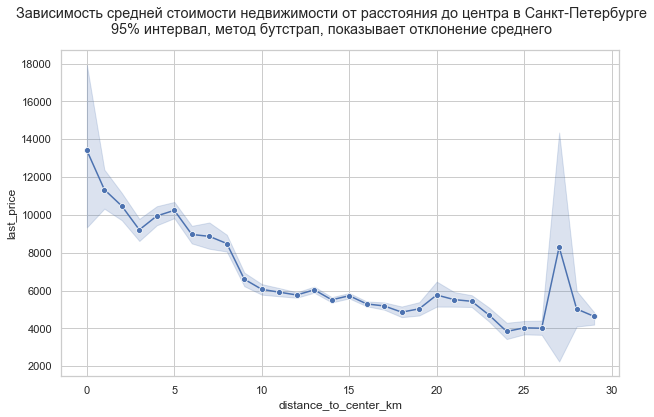

In [195]:
plt.figure(figsize=(10,6))
sns.lineplot(x='distance_to_center_km', 
                                      y='last_price', 
                                      data=flat_data_only_SPb, 
                                      markers=True, style=0, legend=False, ci=95)

plt.suptitle("""Зависимость средней стоимости недвижимости от расстояния до центра в Санкт-Петербурге
95% интервал, метод бутстрап, показывает отклонение среднего""")

plt.show()

Интересный выброс в дальней зоне. Однако, на общем графике региона его нет. Видимо, граница СПб и данные отсечены, попало что-то, что вызвало смещение. **При переходе отметки в 9 км средняя цена начинает расти и к 8 км увеличивается почти на 2млн. Примерно это и ожидали увидеть после анализа гистограммы. Примем 9 км за границу центральной зоны.**

<h2 style="color:DodgerBlue">Выводы по исследованию Санкт-Петербурга в отдельности:</h2>

***
**Комбинацию общей площади и числа комнат** можно эффективно использовать в системе поиска аномалий по Санкт-Петербургу. 
Между площадью и стоимостью квартир, сгруппированых по числу комнат, сохраняются сильные линейные связи *(r = 0.74..0.81).* Наклон линии регрессии примерно одинаков, а вот её смещение вдоль оси площади отличаются для каждой группы. Диаграммы рассеяния площадь-цена для групп аккуратные, овальные. Группы хорошо выделяются на диаграмме рассеяния с цветовым картированием. Наличие смещения и разделения групп позволяет использовать более узкий ценовой коридор для комбинаций площадь-число комнат.

В северной столице для **высоких потолков** в среднем характерна высокая стоимость недвижимости. Это особенно заметно, если выделить интервалы высот (0,2.6] - (2.6, 2.8] - (2.8, 4]. Высокие потолки, в среднем, гораздо ближе к центру (по сути, в центральной зоне), дороже, дольше продаются, вокруг чаще встречаются парки и водоёмы. У квартир с низкими потолками - самая низкая средняя цена за кв. метр.

В среднем, где жильё дороже - там **больше парков и водоёмов.**

**Граница центральной зоны стоимости жилья** проходит в радиусе около 9 км от центра. Недвижимость в 8 км от центра почти на 2 млн дороже, чем в 9 км. Тенденция к росту стоимости при дальнейшем движении к центру сохраняется.
***

<h2 style="color:DodgerBlue">4.4 Санкт-Петербург. Центр.</h2>

Для центра Петербурга создажим отдельный срез из flat_data_SPb_only

In [196]:
flat_data_SPb_center = flat_data_only_SPb.loc[flat_data_only_SPb.loc[: ,'distance_to_center_km'] <=9, :]

In [197]:
flat_data_SPb_center.head()

start_weekday  start_month  start_year first_day_exposition  \
24              5           10        2015           2015-10-31   
63              1            9        2018           2018-09-11   
70              2            9        2018           2018-09-05   
85              0           11        2018           2018-11-26   
99              1            9        2017           2017-09-26   

    days_exposition  observation_time  total_images  last_price  total_area  \
24              265                43             8        6500        97.2   
63               37                 8             2       20000       118.0   
70               14                 8             9        3400        30.0   
85               65                 6            13        5200        46.3   
99              104                20            32        9600        90.0   

    living_area  kitchen_area  price_per_square_meter  living_div_total_area  \
24         46.5          19.6                      67               0.478395   
63         68.0          16.0                     169               0.576271   
70         16.0           7.0                     113               0.533333   
85         27.8           8.0                     112               0.600432   
99         67.0           8.0                     107               0.744444   

    kitchen_div_total_area  floor  floors_total floor_categ  rooms  balcony  \
24                0.201646      1             3      первый      2        0   
63                0.135593      7             9      другой      3        0   
70                0.233333      1             5      первый      1        0   
85                0.172786      5             5   последний      2        0   
99                0.088889      2             5      другой      4        0   

    ceiling_height  cityCenters_nearest  airports_nearest  parks_around3000  \
24             NaN               2336.0              20.1               3.0   
63             3.0               4800.0              26.1               1.0   
70             NaN               8313.0              39.1               1.0   
85             3.0               9319.0              13.3               0.0   
99             NaN               2818.0              23.3               0.0   

    parks_nearest  ponds_around3000  ponds_nearest locality_name_new  \
24          411.0               3.0          124.0   Санкт-Петербург   
63          648.0               1.0          779.0   Санкт-Петербург   
70          382.0               0.0            NaN   Санкт-Петербург   
85            NaN               1.0          682.0   Санкт-Петербург   
99            NaN               0.0            NaN   Санкт-Петербург   

   locality_type_new         SPb_flag ceiling_categ  distance_to_center_km  
24             город  Санкт-Петербург           NaN                    2.0  
63             город  Санкт-Петербург    (2.8, 4.0]                    5.0  
70             город  Санкт-Петербург           NaN                    8.0  
85             город  Санкт-Петербург    (2.8, 4.0]                    9.0  
99             город  Санкт-Петербург           NaN                    3.0

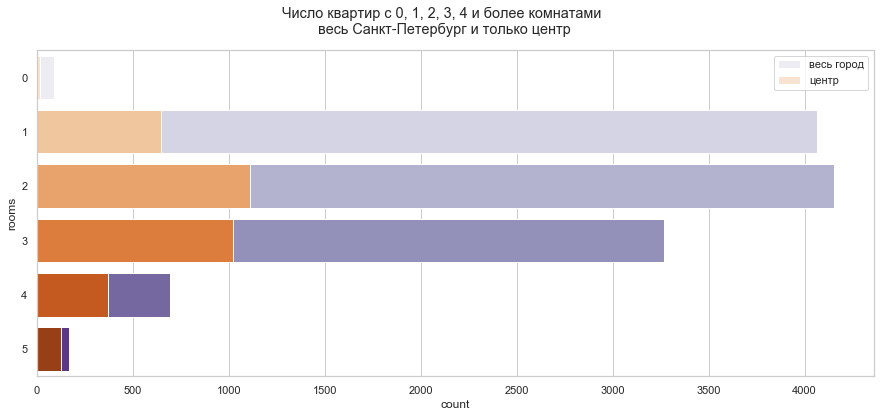

In [198]:
plt.figure(figsize=(15,6))
ax1=plt.subplot()
sns.countplot(ax=ax1, y='rooms', palette="Purples", alpha=1, 
              data=flat_data_only_SPb, label='весь город')
sns.countplot(ax=ax1, y='rooms', palette="Oranges", alpha=1,
              data=flat_data_SPb_center, label='центр')

plt.legend()
plt.suptitle('Число квартир с 0, 1, 2, 3, 4 и более комнатами\n весь Санкт-Петербург и только центр')
plt.show()

Квартир, не разделённых на комнаты, мало и во всём городе, и в центре. Доля однокомнатных в центре существенно меньше, чем в городе в целом, а доля 3х комнатных - выше. Более половины квартир с 4 и более комнатами сосредоточена в центре. 5 и более комнат - почти все в центре. Доля квартир с 4 и более комнатами среди прочих центральных квартир значительно выше, чем доля аналогичных квартир во всём городе.

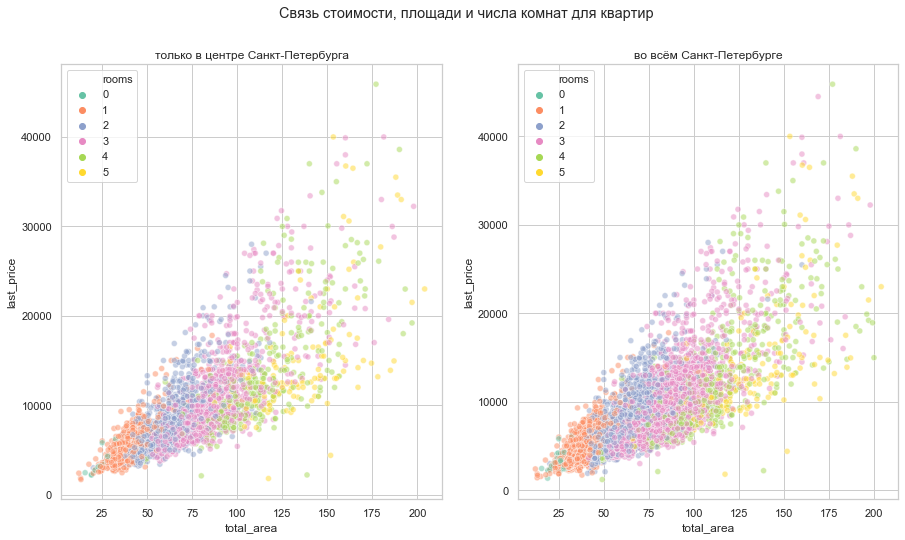

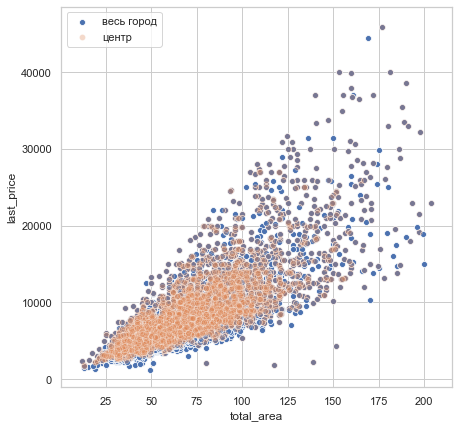

In [199]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.scatterplot(y='last_price', x='total_area', hue='rooms', 
                   data=flat_data_SPb_center, alpha=0.5, palette="Set2")
plt.title("только в центре Санкт-Петербурга")

plt.subplot(1,2,2)
sns.scatterplot(y='last_price', x='total_area', hue='rooms', 
                   data=flat_data_only_SPb, alpha=0.5, palette="Set2")
plt.suptitle("связь стоимости, площади и числа комнат для квартир Санкт-Петербурга")
plt.title("во всём Санкт-Петербурге")

plt.suptitle('Cвязь стоимости, площади и числа комнат для квартир')

plt.figure(figsize=(7,7))
sns.scatterplot(y='last_price', x='total_area', data=flat_data_only_SPb, alpha=1, palette="Set2", label="весь город")
sns.scatterplot(y='last_price', x='total_area', data=flat_data_SPb_center, alpha=0.3, palette="Set2", label="центр")

plt.show()

По сравнению с Петербургом в целом диаграмма рассеяния поредела и "похудела". Ушла область недорогих квартир (уменьшилось "подбрюшье диаграммы") В центре меньше бюджетных "трёшек" (так же, как в СПб меньше бюджетных больших квартир относительно региона в целом) Тендеция осталась прежней по зависимости стоимости как от площади, так и от числа комнат: больше площадь, больше комнат - недвижимость дороже

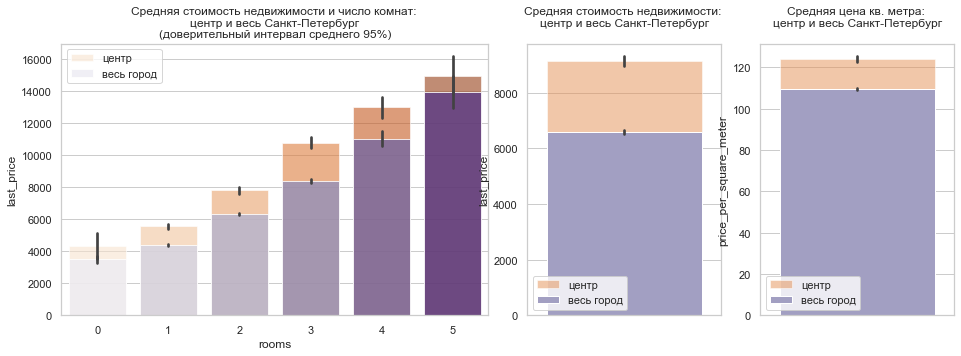

In [200]:
#сетка графиков 1 столб 4 ячейки
gridsize = (1, 4)
plt.figure(figsize=(16,5))

#оси; 1 - начинать с 0-0, занять 1 строку и 2 столбца; 2-начинать с 0-2, 3 - с 0-3
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 2), colspan=1, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (0, 3), colspan=1, rowspan=1)

ax1.set_title(f"""Средняя стоимость недвижимости и число комнат: 
центр и весь Санкт-Петербург
(доверительный интервал среднего 95%)""")
ax2.set_title(f"""Средняя стоимость недвижимости: 
центр и весь Санкт-Петербург
""")

ax3.set_title(f"""Средняя цена кв. метра: 
центр и весь Санкт-Петербург
""")

sns.barplot(ax=ax1, x='rooms', y='last_price',  
                   data=flat_data_SPb_center, ci=95, alpha=0.6, palette="Oranges", label='центр')
sns.barplot(ax=ax1, x='rooms', y='last_price',  
                   data=flat_data_only_SPb, ci=95, alpha=0.8, palette="Purples", label='весь город')

sns.barplot(ax=ax2, y='last_price',  
                   data=flat_data_SPb_center, ci=95, alpha=0.5, palette="Oranges", label='центр')
sns.barplot(ax=ax2, y='last_price',  
                   data=flat_data_only_SPb, ci=95, palette="Purples", label='весь город')

sns.barplot(ax=ax3, y='price_per_square_meter',  
                   data=flat_data_SPb_center, ci=95, alpha=0.5, palette="Oranges", label='центр')
sns.barplot(ax=ax3, y='price_per_square_meter',  
                   data=flat_data_only_SPb, ci=95, palette="Purples", label='весь город')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [201]:
for column in ['last_price', 'price_per_square_meter']:
    display(column + ': среднее в центре / среднее во всём городе')
    display(
        round((flat_data_SPb_center[column].mean() / flat_data_only_SPb[column].mean()), 2)
    )

'last_price: среднее в центре / среднее во всём городе'

1.39

'price_per_square_meter: среднее в центре / среднее во всём городе'

1.13

Средняя цена квартир в центре примерно в 1.4 раза выше средней цены по городу. Квадратный метр тоже дороже, но примерно в 1.13 раза. Средние цены значимо отличаются для 1-,2-,3-,4-комнатных квартир

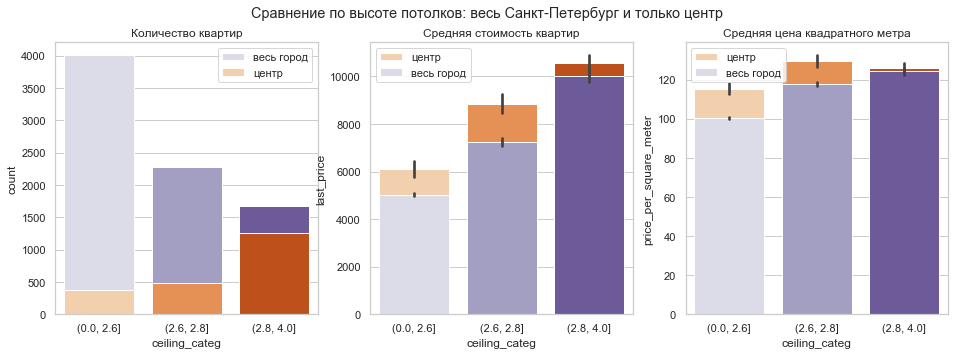

In [202]:
plt.figure(figsize=(16, 5))

ax1=plt.subplot(1,3,1)
sns.countplot(ax=ax1, x='ceiling_categ', palette="Purples", 
              alpha=1, data=flat_data_only_SPb, label='весь город')
sns.countplot(ax=ax1, x='ceiling_categ', palette="Oranges", 
              alpha=1, data=flat_data_SPb_center, label='центр')
plt.title('Количество квартир')


ax2=plt.subplot(1,3,2)
sns.barplot(ax=ax2, x='ceiling_categ', y='last_price', palette="Oranges", 
            alpha=1, data=flat_data_SPb_center, label='центр')
sns.barplot(ax=ax2, x='ceiling_categ', y='last_price', palette="Purples", 
            alpha=1, data=flat_data_only_SPb, label='весь город')

plt.title('Средняя стоимость квартир')

ax3=plt.subplot(1,3,3)
sns.barplot(ax=ax3, x='ceiling_categ', y='price_per_square_meter', palette="Oranges", 
            alpha=1, data=flat_data_SPb_center, label='центр')
sns.barplot(ax=ax3, x='ceiling_categ', y='price_per_square_meter', palette="Purples", 
            alpha=1, data=flat_data_only_SPb, label='весь город')

plt.title('Средняя цена квадратного метра')

plt.suptitle('Сравнение по высоте потолков: весь Санкт-Петербург и только центр')
ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

Почти все высокие потолки - в центре города. Логично, что цена на них в среднем по городу и в центре близка. А вот и низкие и средние потолки в центре в среднем дороже. С ценой квадратного метра ситуация аналогичная.

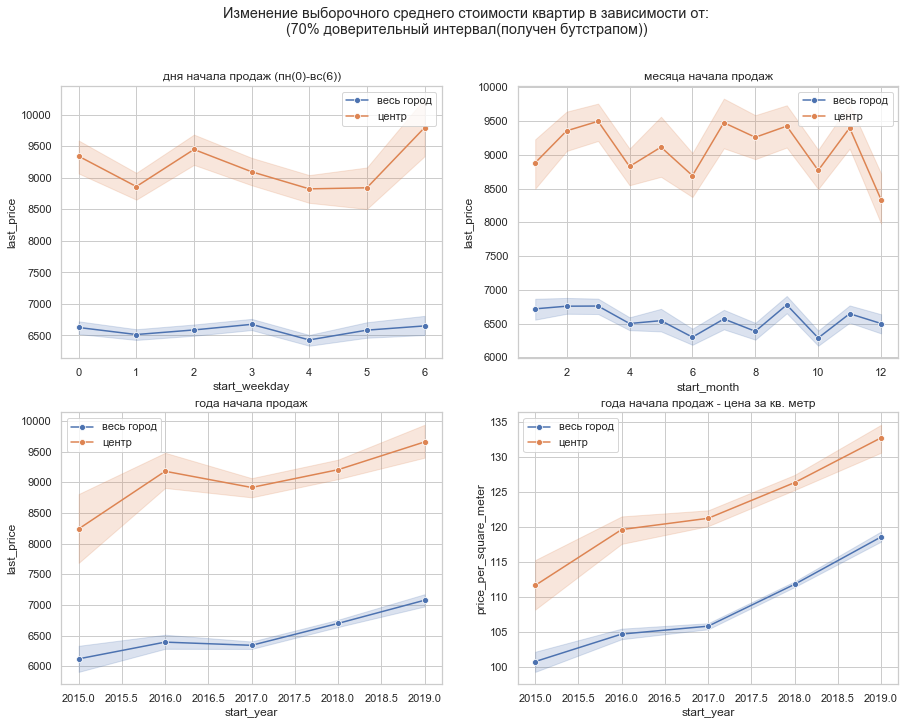

In [203]:
plt.figure(figsize=(15,11))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)
ci_value = 70

sns.lineplot(ax=ax1, x='start_weekday', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_only_SPb, label='весь город')
sns.lineplot(ax=ax1, x='start_weekday', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_SPb_center, label='центр')


sns.lineplot(ax=ax2, x='start_month', y='last_price',  
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_only_SPb, label='весь город')
sns.lineplot(ax=ax2, x='start_month', y='last_price',  
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_SPb_center, label='центр')


sns.lineplot(ax=ax3,
             x='start_year', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_only_SPb, label='весь город')
sns.lineplot(ax=ax3,
             x='start_year', y='last_price', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_SPb_center, label='центр')


sns.lineplot(ax=ax4,
             x='start_year', y='price_per_square_meter', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_only_SPb, label='весь город')
sns.lineplot(ax=ax4,
             x='start_year', y='price_per_square_meter', 
             style=0 , markers=True, legend=False, err_style="band",
             ci=ci_value, data=flat_data_SPb_center, label='центр')


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle(f"""Изменение выборочного среднего стоимости квартир в зависимости от:
({ci_value}% доверительный интервал(получен бутстрапом))
            """)
ax1.set_title('дня начала продаж (пн(0)-вс(6))')
ax2.set_title('месяца начала продаж')
ax3.set_title('года начала продаж')
ax4.set_title('года начала продаж - цена за кв. метр')
plt.show()

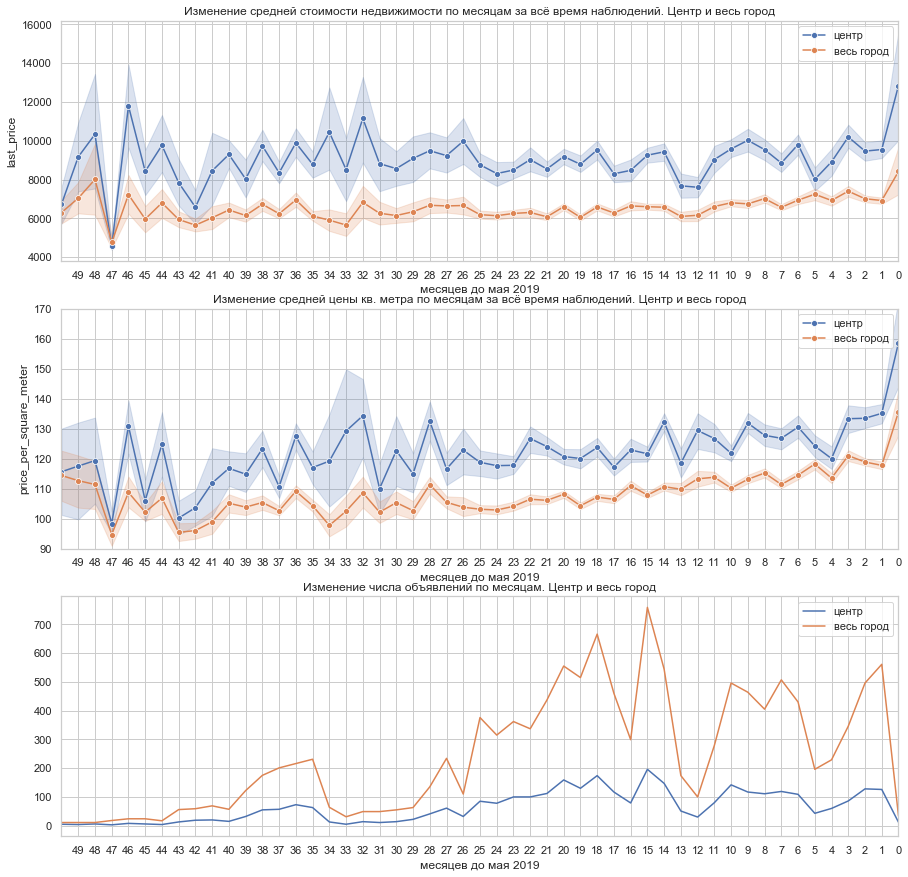

In [204]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1, ax2, ax3 = ax.flatten()

ax1.set_title('Изменение средней стоимости недвижимости по месяцам за всё время наблюдений. Центр и весь город')
ax2.set_title('Изменение средней цены кв. метра по месяцам за всё время наблюдений. Центр и весь город')
ax3.set_title('Изменение числа объявлений по месяцам. Центр и весь город')

ax2.set_ylim(90,170)

sns.lineplot(ax=ax1, x='observation_time', y='last_price', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_SPb_center,label='центр')

sns.lineplot(ax=ax2, x='observation_time', y='price_per_square_meter', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_SPb_center,label='центр')

sns.lineplot(ax=ax3,data=flat_data_SPb_center['observation_time'].value_counts(),label='центр')

sns.lineplot(ax=ax1, x='observation_time', y='last_price', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_only_SPb, label='весь город')

sns.lineplot(ax=ax2, x='observation_time', y='price_per_square_meter', 
              style=0 , markers=True, legend=False, err_style="band",
              ci=ci_value, data=flat_data_only_SPb, label='весь город')

sns.lineplot(ax=ax3,data=flat_data_only_SPb['observation_time'].value_counts(), label='весь город')

for i in range (0,3):
    ax.flatten()[i].set_xlim(reversed(ax.flatten()[i].set_xlim(0,50)))
    ax.flatten()[i].set_xlabel('месяцев до мая 2019')
    ax.flatten()[i].set_xticks(range(0,50))
    ax.flatten()[i].legend()

Как отмечали ранее, графики средней стоимости по дням недели месяцам вызывают вопросы в связи со значительной вариабельностью числа объявлений и цен от месяца к месяцу. По дням недели в среднем заметен спад со среды с ростом к воскресенью.


По сравнению с городом в целом в центре северной столицы среднегодовые тенденции выражены аналогично, но цены выше. С 2017 по 2019 год среднегодовая цена квартир в центре на 2 млн выше, чем в городе в целом. Среднегодовая цена квадратного метра выше на 15 тыс. рублей.

На графиках среднемесячной динамики видно, что изменчивость числа объявлений в центре значительно ниже, чем по городу в целом. Стоимость и цена квадратного метра недвижимости следуют общегородской динамике, но их вариабельность выше. Рынок недвижимости центра города гораздо болезненнее отреагировал на кризис лета 2018 года (сильный провал средней стоимости).

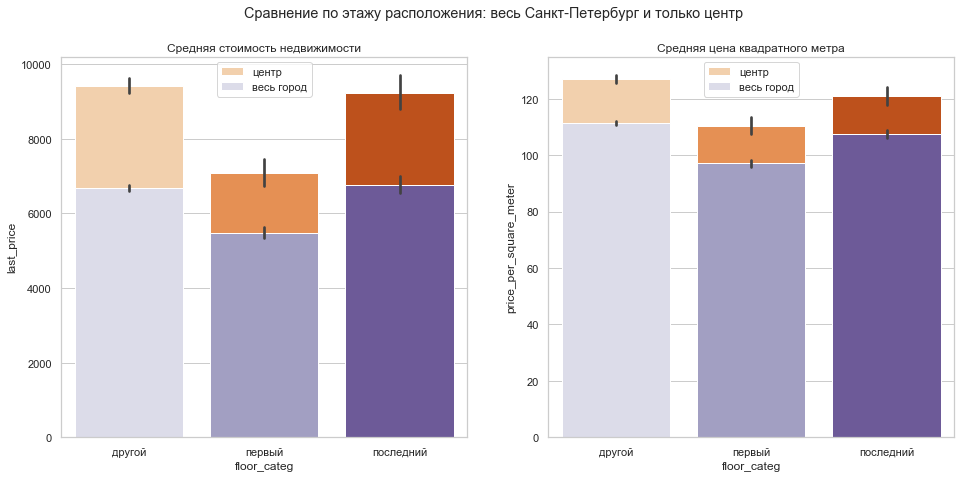

In [205]:
plt.figure(figsize=(16,7))

ax1=plt.subplot(1,2,1)
sns.barplot(ax=ax1, x='floor_categ', y='last_price', palette="Oranges", 
            alpha=1, data=flat_data_SPb_center, label='центр')
sns.barplot(ax=ax1, x='floor_categ', y='last_price', palette="Purples", 
            alpha=1, data=flat_data_only_SPb, label='весь город')
plt.title('Средняя стоимость недвижимости')


ax2=plt.subplot(1,2,2)
sns.barplot(ax=ax2, x='floor_categ', y='price_per_square_meter', palette="Oranges", 
            alpha=1, data=flat_data_SPb_center, label='центр')
sns.barplot(ax=ax2, x='floor_categ', y='price_per_square_meter', palette="Purples", 
            alpha=1, data=flat_data_only_SPb, label='весь город')

plt.title('Средняя цена квадратного метра')

plt.suptitle('Сравнение по этажу расположения: весь Санкт-Петербург и только центр')
ax1.legend()
ax2.legend()

plt.show()

Все этажи в центре в среднем дороже. Особенно мансарды и промежуточные этажи. Цена квадратного метра выросла на все этажи одинаково. Видимо, первые этажи в центре в среднем меньше по площади, чем остальные, поэтому у них меньше рост стоимости.

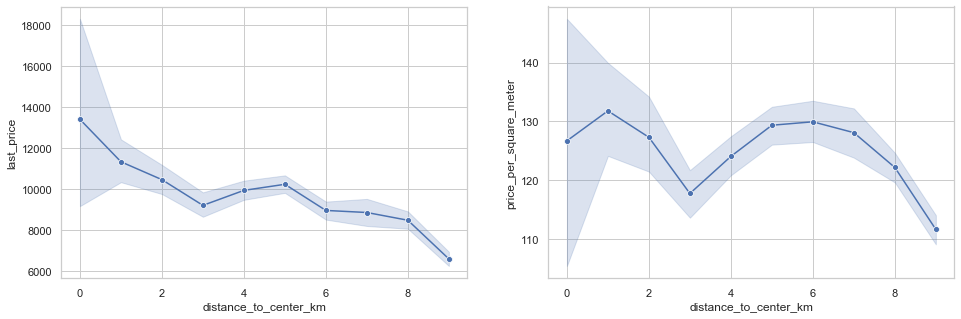

In [206]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.lineplot(y='last_price', x='distance_to_center_km', 
            data=flat_data_SPb_center, markers=True, style=0, legend=False)
plt.subplot(1,2,2)
sns.lineplot(y='price_per_square_meter', x='distance_to_center_km', 
            data=flat_data_SPb_center, markers=True, style=0, legend=False)
plt.show()

Средняя стоимость жилья имеет тенденцию расти к "центру центра". На 3 км наблюдается спад последующим ростом. Средняя цена квадратного метра растёт до 6 км, затем к 3 км плавно снижается и снова растёт. На графике стоимости как раз видна модуляция ценой квадратного метра. Видимо, рост стоимости вызван ростом площади, а колебания - колебаниями цены за кв. метр.

<h2 style="color:DodgerBlue">Результаты исследования центра Санкт-Петербурга</h2>

***
**В центре иное распределение квартир по числу комнат, чем в среднем по городу**. Доля однокомнатных в центре существенно меньше, чем в городе в целом, а доля 3х комнатных - больше. Более половины квартир с 4 и более комнатами сосредоточена в центре. 5 и более комнат - почти все в центре. **Средняя стоимость квартир в центре** примерно в 1.4 раза выше средней цены по городу. Квадратный метр тоже дороже, но примерно в 1.13 раза. Средние цены значимо отличаются для 1-,2-,3-,4-комнатных квартир. Почти все **квартиры с высокими потолками** находятся в центре города. Поэтому их стоимость по городу определяется центром. А вот квартиры с низкии и средними потолками в центре в среднем дороже. Цена квадратного метра в центре одинаково выше для всех этажей размещения недвижимости. Стоимость первых этажей при этом поднялась меньше других. Видимо, они меньше по площади. По сравнению с городом в целом в центре северной столицы годовые тенденции выражены аналогично, но цены выше. С 2017 по 2019 год среднегодовая цена квартир в центре на 2 млн выше, чем в городе в целом. Среднегодовая цена квадратного метра выше на 15 тыс. рублей. Рынок недвижимости центра города гораздо болезненнее отреагировал на кризис лета 2018 года (сильный провал средней стоимости). Средняя стоимость жилья имеет тенденцию расти к "центру центра". На 3 км наблюдается спад последующим ростом. Средняя цена квадратного метра растёт до 6 км, затем к 3 км плавно снижается и снова растёт


Относительно города в целом в центре сохраняются те же взаимосвязи. Стоимость квартир всё так же зависит от **площади и от числа комнат, высоты потолков, этажа расположения, расстояния до центра**
***

<h2 style="color:DodgerBlue">4.5 Проверка на удаление важных экстремумов</h2>

Во время работы на центром города возникли опасения, что при удалении экстремальных значений могли удалить много больших элитных квартир, и это повлияло на результат. Поэтому провели тест-сравнение сырых данных для столицы и обработанных.

In [207]:
flat_data_SPb_only_raw = flat_data.loc[flat_data.loc[:, 'locality_name_new'] == 'Санкт-Петербург', :]

In [208]:
flat_data_SPb_only_raw['distance_to_center_km'] = (flat_data_SPb_only_raw['cityCenters_nearest']/1000).round(0)

In [209]:
flat_data_SPb_center_raw = flat_data_SPb_only_raw.loc[flat_data_SPb_only_raw.loc[: ,'distance_to_center_km'] <=9, :]

In [210]:
flat_data_SPb_center_raw.loc[flat_data_SPb_center_raw.loc[:, 'rooms'] >=5, 'rooms'] = 5

In [211]:
flat_data_SPb_only_raw.loc[flat_data_SPb_only_raw.loc[:, 'rooms'] >=5, 'rooms'] = 5

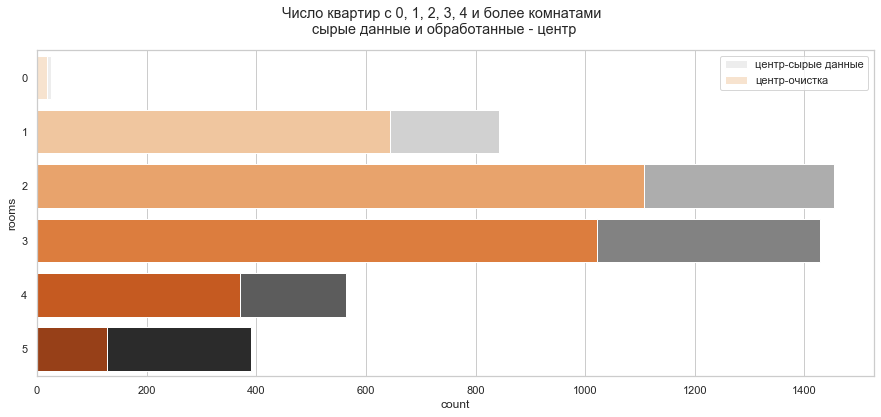

In [212]:
plt.figure(figsize=(15,6))
ax1=plt.subplot()
sns.countplot(ax=ax1, y='rooms', palette="Greys", alpha=1, 
              data=flat_data_SPb_center_raw, label='центр-сырые данные')
sns.countplot(ax=ax1, y='rooms', palette="Oranges", alpha=1,
              data=flat_data_SPb_center, label='центр-очистка')

plt.legend()
plt.suptitle('Число квартир с 0, 1, 2, 3, 4 и более комнатами\n сырые данные и обработанные - центр')
plt.show()

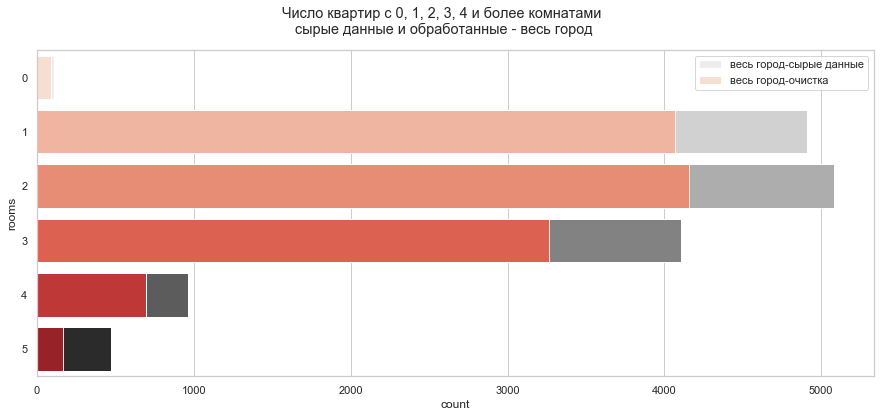

In [213]:
plt.figure(figsize=(15,6))
ax1=plt.subplot()
sns.countplot(ax=ax1, y='rooms', palette="Greys", alpha=1, 
              data=flat_data_SPb_only_raw, label='весь город-сырые данные')
sns.countplot(ax=ax1, y='rooms', palette="Reds", alpha=1,
              data=flat_data_only_SPb, label='весь город-очистка')

plt.legend()
plt.suptitle('Число квартир с 0, 1, 2, 3, 4 и более комнатами\n сырые данные и обработанные - весь город')
plt.show()

Удалили некоторое количество квартир с большим числом комнат (>4). Но перекоса нет, общая картина не поменялась. Лишнего не удалили.

<h1 style="color:SteelBlue; font-size:200%">Общий вывод</h1>

Задачей анализа было установить параметры, которые определяют рыночную стоимость недвижимости. Они нужны для системы отслеживания аномалий и мошеннической деятельности.


Между регионом и Санкт-Петербургом основные тенденции схожи. Однако Санкт-Петербург сильно выделяется в регионе уровнем цен, а в Санкт-Петербурге аналогично выделяется центральная зона. Поэтому место расположения объекта нужно обязательно учитывать. Анализ показал, что в основном рыночную стоимость определяют **место расположения и расстояние до центра города, площадь, число комнат, этаж**. Кроме того, на стоимость влияет **год подачи объявления и стимость квадратного метра**. 

Для Санкт-Петербурга дополнительно проанализированы **высота потолков, число парков и водоёмов в радиусе 3км** 



**Из них наиболее значимы:**


- **Место расположения и расстояние до центра города**


**Важный показатель, в зависимости от которого разница в средней стоимости может достигать до 2-3 раз.** Для Санкт-Петербурга важно расстояние до центра города. Для прочих населённых пунктов - что это за населённый пункт (тип, название; даже в топ-10 продаж средние стимости отличаются в 1.5-2 раза).

Самая дорогая недвижимость в регионе - в городах и посёлках (в среднем около 3.5 млн, если исключить из городов столицу), самая дешёвая - в сёлах (около 2.2 млн). Самые дорогие города региона - Санкт-Петербург и Пушкин.


В Санкт-Петербурге средняя стоимость недвижимости почти в 2 раза выше, чем средняя по региону и составляет 6,6 млн. руб. Близкие значения и для города Пушкин.


В Санкт-Петербурге стоимость недвижимости возрастает при приближении к центру. В нём выделяется центральная зона радиусом 9км, на границе которой заметен резкий скачок стоимости недвижимости (на 2 млн руб.). В среднем в этой зоне недвижимость в 1.4 раза дороже, чем по городу. Тенденция роста стоимости по мере приближения к "центру центра" сохраняется. На радиусе 3 км наблюдается спад с последующим ростом. Средняя цена квадратного метра тоже растёт до 6 км, затем к 3 км плавно снижается и снова растёт. На радиусе 3 км - провал с последующим ростом. В пределах северной столицы в зависимости от расстояния до центра средняя стоимость квартир отличается в 2.5-3 раза.


- **Площадь**


Между площадью и стоимостью обнаружена сильная линейная связь (коэффициент корреляции Пирсона *r = 0,78* ). Однако, для региона фактически нет различий в нижней границе стоимости квартир площадью до 75 кв. метров, могут быть сложности с построением ценового коридора для оценки аномалий. При этом в Санкт-Петербурге связь более явная. Однако коридор стоимости отдельных квартир для фиксированной площади достаточно широкий и растёт с ростом площади (может достигать 3-3.5 раза)


- **Число комнат**


И для региона и для Петербурга наблюдается тенденция: чем больше комнат, тем выше средняя цена квартир. Цены в Санкт-Петербурге тем выше региональных, чем больше комнат: 1 и 2 комнатные квартиры дороже в среднем на треть, а 4 и более комнатные - почти в 2 раза.


- **Площадь и число комнат в связке**


Для Санкт-Петербурга показано, что совместное использование площади и числа комнат позволяет более точно, чем в общем случае, предсказать коридор допустимой цены. Основа - заметное смещение данных, сгруппированых по числу комнат, друг относительно друга вдоль оси площади на диаграмме стоимость-площадь.


- **Этаж расположения**


Промежуточные этажи во всех населённых пунктах - самые дорогие относительно первого и последнего, особенно выделяются посёлки. В среднем по региону квартиры на 1м этаже на 22% дешевле, чем на промежуточных, на верхнем этаже - на 11%. В сёлах мансардные этажи - самые дешёвые. В ПГТ и городах ситуация близка к общей картине. В посёлках и деревнях последний и первый этажи в среднем почти одной стоимости. В северной столице последние этажи стоят примерно как промежуточные.


- **Высота потолков** (параметр исследован для Санкт-Петербурга)


Почти все квартиры с высокими потолками находятся в центре города. Поэтому их стоимость по городу определяется центром. И для Санкт-Петербурга в целом и для его центра с ростом высоты потолка в среднем растёт и стоимость жилья. Наиболее удачным параметром являются интервалы высот (0,2.6], (2.6, 2.8],  (2.8, 4]. Между ними наблюдаются значимые различия в средней стоимости жилья.


- **Число парков и водоёмов в радиусе 3 км** (параметр исследован для Санкт-Петербурга)

Данных о числе парков и водоёмов вне Санкт-Петербурга мало, поэтому их влияние исследовано только в столице. В среднем, где жильё дороже - там больше парков и водоёмов. Средняя стоимость недвижимости вблизи 3 парков выше, чем той, где 1-2 парка. В свою очередь, квартира возле 1-2 парков в среднем дороже той, возле которой парков нет. По водоёмам ситуация немного другая. Средняя стоимость недвижимости выше, но только там, где поблизости 2 или 3 водоёма. Наличие одного водоёма не даёт значимого повышения средней стоимости.


- **Год подачи объявления**


При построении системы анализа следует учитывать, что средняя стоимость недвижимости на момент продажи зависит от года подачи объявления и устойчиво растёт от года к году. Аналогичная ситуация с ценой квадратного метра. Что касается среднемесячной и среднедневной стоимости, их использовать надо с осторожностью, т.к. от месяца к месяцу наблюдаются сильные колебания числа объявлений и стоимости продаж.


Также стоит отметить, что найдена **линейная взаимосвязь средней силы между ценой квадратного метра и стоимостью недвижимости.** Т.е. чем дороже недвижимость, тем дороже квадратный метр её площади. Это позволяет установить коридор допустимых для заданной стоимости жилья площадей. Т.е. можно ограничивать площадь или напрямую или через цену квадратного метра, в зависимости от алгоритма (т.к. в тройке площадь - стоимость - цена квадратного метра один параметр считается на основе 2 других, то одновременно все 3 использовать нет смысла).


Таким образом, часть предварительных гипотез подтверждена (Гипотезы 1 - 3, с оговоркой, что не вошли в анализ число балконов и тип недвижимости (апартаменты/жилая; очень мало данных)). Для анализа гипотез 4 и 5 нужно больше данных по конкретным населённым пунктам, они выходят за рамки данного исследования.